# Team Based Model

## Imports

In [12]:
import pep8
import autopep8
import sqlite3
import joblib
import optuna
import plotly.graph_objects as go
import plotly.express as px
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
import pickle
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import learning_curve, validation_curve
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.compose import ColumnTransformer

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [14]:
def load_team_data(conn):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    return df


connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection)
connection.close()

In [15]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    df = df.dropna(subset=['E_OFF_RATING'])

    return df


clean_df = clean_team_data(df)
clean_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53947  2021-22  1610612756               PHX            Phoenix Suns   
53948  2021-22  1610612747               LAL      Los Angeles Lakers   
53949  2021-22  1610612757               POR  Portland Trail Blazers   
53950  2021-22  1610612745               HOU         Houston Rockets   
53951  2021-22  1610612743               DEN          Denver Nuggets   

          GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  FGA  FG_PCT  FG3M  \
0      0020000002 2000-10-31    CLE @ BKN   1  240   32   78   0.410     2   
1      0020000002 2000-10-31  BKN vs. CLE   0  240   31   85   0.365     3   
2      0020000008 2000-10-31  HOU vs. MIN   0  240   34   74   0.459     2   
3      0020000008 2000-10-31    MIN @ HOU   1  240   43   88   0.489     6   
4      0020000009 2000-10-31  SAS vs. IND   1  240   33   64   0.516     4   
...           ...        ...          ...  ..  ...  ...  ...     ...   ...   
53947  0022100137 2021-11-06  PHX vs. ATL   1  240   45   88   0.511    14   
53948  0022100138 2021-11-06    LAL @ POR   0  240   31   90   0.344     9   
53949  0022100138 2021-11-06  POR vs. LAL   1  240   36   95   0.379    15   
53950  0022100133 2021-11-06    HOU @ DEN   0  240   35   75   0.467     8   
53951  0022100133 2021-11-06  DEN vs. HOU   1  240   36   89   0.404     9   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  \
0         7    0.286   20   32   0.625    11    41   52   16    5    8   19   
1        10    0.300   17   26   0.654    12    35   47   24    9    8   15   
2         9    0.222   28   40   0.700    11    27   38   18    9    7   18   
3        11    0.545   14   16   0.875    13    31   44   29    7    1   16   
4         8    0.500   28   35   0.800     5    32   37   17    6    4   18   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
53947    43    0.326   17   21   0.810     5    37   42   26    8    6   12   
53948    32    0.281   19   24   0.792    11    48   59   20    8    6   19   
53949    55    0.273   18   24   0.750    12    40   52   22   14    7   12   
53950    28    0.286   16   24   0.667     7    40   47   19    8    6   17   
53951    40    0.225   14   17   0.824    10    35   45   19   10    5   11   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0      27   86           4          85.9        87.8          82.5   
1      31   82          -4          82.5        83.7          85.9   
2      17   98          -8          99.4       103.2         108.1   
3      25  106           8         108.1       110.4          99.4   
4      22   98          13         106.1       104.3          90.7   
...    ..  ...         ...           ...         ...           ...   
53947  22  121           4         116.1       114.2         111.3   
53948  17   90         -15          82.9        84.1          99.5   
53949  21  105          15          99.5        98.1          82.9   
53950  16   94          -1          98.4        95.9          97.5   
53951  20   95           1          97.5        97.9          98.4   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0            83.7           3.5         4.1    0.500     0.84       12.6   
1            87.8          -3.5        -4.1    0.774     1.60       17.7   
2           110.4          -8.7        -7.3    0.529     1.00       14.1   
3           103.2           8.7         7.3    0.674     1.81       20.7   
4            90.4          15.4     

In [16]:
# from src.data.make_team_dataset import prep_for_aggregation


def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40', 'MIN'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']

    df = df[['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
             'GAME_DATE', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL',
             'RECORD', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
             'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
             'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
             'E_NET_RATING', 'NET_RATING', 'POSS', 'PIE', 'PTS_2PT_MR',
             'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM', 'AST_3PM',
             'UAST_2PM', 'UAST_3PM']]

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53947  2021-22  1610612756               PHX            Phoenix Suns   
53948  2021-22  1610612747               LAL      Los Angeles Lakers   
53949  2021-22  1610612757               POR  Portland Trail Blazers   
53950  2021-22  1610612745               HOU         Houston Rockets   
53951  2021-22  1610612743               DEN          Denver Nuggets   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53947  0022100137 2021-11-06  PHX vs. ATL          1         121           4   
53948  0022100138 2021-11-06    LAL @ POR          0          90         -15   
53949  0022100138 2021-11-06  POR vs. LAL          1         105          15   
53950  0022100133 2021-11-06    HOU @ DEN          0          94          -1   
53951  0022100133 2021-11-06  DEN vs. HOU          1          95           1   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53947   1       1    31    45    14    43   17   21     5    37   42   26   
53948   0       0    22    58     9    32   19   24    11    48   59   20   
53949   1       1    21    40    15    55   18   24    12    40   52   22   
53950   0       0    27    47     8    28   16   24     7    40   47   19   
53951   1       1    27    49     9    40   14   17    10    35   45   19   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53947    8    6   12  22  121           4         116.1       114.2   
53948    8    6   19  17   90         -15          82.9        84.1   
53949   14    7   12  21  105          15          99.5        98.1   
53950    8    6   17  16   94          -1          98.4        95.9   
53951   10    5   11  20   95           1          97.5        97.9   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

## Add Betting Data 

In [17]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [18]:
spreads

SEASON     GM_DATE      HOME_TEAM     AWAY_TEAM  AWAY_SCOREBOARD  \
0      2006-07  2006-10-31          Miami       Chicago  22,37,21,28,108   
1      2006-07  2006-10-31    L.A. Lakers       Phoenix  41,17,21,27,106   
2      2006-07  2006-11-02         Dallas   San Antonio   26,19,27,25,97   
3      2006-07  2006-11-02  L.A. Clippers        Denver   24,24,22,25,95   
4      2006-07  2006-11-03        Memphis     Charlotte   21,26,23,13,83   
...        ...         ...            ...           ...              ...   
19018  2021-22  2021-11-06          Miami          Utah  24,28,26,37,115   
19019  2021-22  2021-11-06        Chicago  Philadelphia  22,35,27,30,114   
19020  2021-22  2021-11-06         Dallas        Boston  15,25,32,32,104   
19021  2021-22  2021-11-06        Phoenix       Atlanta  26,32,40,19,117   
19022  2021-22  2021-11-06       Portland   L.A. Lakers   14,22,26,28,90   

       HOME_SCOREBOARD                AWAY_SPREAD                HOME_SPREAD  
0       16,14,21,15,66              -,-,+4½-110,-              -,-,-4½-110,-  
1      26,27,34,27,114              -,-,-8½-110,-              -,-,+8½-110,-  
2       27,24,24,16,91               -,-,+3-110,-               -,-,-3-110,-  
3       18,31,16,31,96              -,-,+4½-110,-              -,-,-4½-110,-  
4       24,20,16,36,96               -,-,+5-110,-               -,-,-5-110,-  
...                ...                        ...                        ...  
19018  27,28,32,31,118     -1-105,-,+2-109,-3+120     +1-115,-,-2-112,+1-115  
19019  21,26,30,28,105     +4-115,-,+4-109,+6-165     -4-105,-,-4-112,-6+120  
19020  29,28,22,28,107  +3½-110,-,+3½-109,+5½-145  -3½-110,-,-3½-112,-5½+105  
19021  25,34,27,35,121    +3½-115,-,+4-109,+5-160    -3½-105,-,-4-112,-5+115  
19022  36,15,42,12,105   +5-110,-,+5½-110,+5½-110   -5-110,-,-5½-110,-5½-110  

[19023 rows x 8 columns]

In [19]:
moneylines

SEASON     GM_DATE    HOME_TEAM      AWAY_TEAM           AWAY_ML  \
0      2020-21  2020-12-22     Brooklyn   Golden State  +290,+275,+275,-   
1      2020-21  2020-12-22  L.A. Lakers  L.A. Clippers  +110,+110,+120,-   
2      2020-21  2020-12-23    Cleveland      Charlotte  -155,-156,-155,-   
3      2020-21  2020-12-23      Indiana       New York  +270,+300,+265,-   
4      2020-21  2020-12-23      Orlando          Miami  -195,-195,-210,-   
...        ...         ...          ...            ...               ...   
19016  2021-22  2021-11-06        Miami           Utah  -110,-,+108,-110   
19017  2021-22  2021-11-06      Chicago   Philadelphia  +150,-,+143,+150   
19018  2021-22  2021-11-06       Dallas         Boston  +140,-,+130,+140   
19019  2021-22  2021-11-06      Phoenix        Atlanta  +140,-,+138,+135   
19020  2021-22  2021-11-06     Portland    L.A. Lakers  +170,-,+175,+175   

                HOME_ML  
0      -360,-330,-350,-  
1      -130,-130,-140,-  
2      +135,+136,+135,-  
3      -330,-370,-330,-  
4      +170,+170,+175,-  
...                 ...  
19016  -110,-,-129,-110  
19017  -170,-,-175,-180  
19018  -160,-,-155,-165  
19019  -160,-,-165,-160  
19020  -200,-,-210,-220  

[19021 rows x 6 columns]

In [20]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [21]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)

    return moneylines

In [22]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


In [23]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')

        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')

        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)

    return spreads

In [24]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: All-NaN axis encountered


In [25]:
# clean_spreads = clean_spreads_df(spreads)

clean_spreads

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_SPREAD  \
0      2006-07  2006-10-31       MIA       CHI                 -4.5   
1      2006-07  2006-10-31       LAL       PHX                  8.5   
2      2006-07  2006-11-02       DAL       SAS                 -3.0   
3      2006-07  2006-11-02       LAC       DEN                 -4.5   
4      2006-07  2006-11-03       MEM       CHA                 -5.0   
...        ...         ...       ...       ...                  ...   
19018  2021-22  2021-11-06       MIA       UTA                  2.0   
19019  2021-22  2021-11-06       CHI       PHI                 -6.0   
19020  2021-22  2021-11-06       DAL       BOS                 -5.5   
19021  2021-22  2021-11-06       PHX       ATL                 -5.0   
19022  2021-22  2021-11-06       POR       LAL                 -5.5   

       HIGHEST_AWAY_SPREAD  
0                      4.5  
1                     -8.5  
2                      3.0  
3                      4.5  
4                      5.0  
...                    ...  
19018                  3.0  
19019                  6.0  
19020                  5.5  
19021                  5.0  
19022                  5.5  

[19023 rows x 6 columns]

In [26]:
clean_mls

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_ML  \
0      2020-21  2020-12-22       BKN       GSW         1.277778   
1      2020-21  2020-12-22       LAL       LAC         1.714286   
2      2020-21  2020-12-23       CLE       CHA         2.360000   
3      2020-21  2020-12-23       IND       NYK         1.270270   
4      2020-21  2020-12-23       ORL       MIA         2.750000   
...        ...         ...       ...       ...              ...   
19016  2021-22  2021-11-06       MIA       UTA         1.775194   
19017  2021-22  2021-11-06       CHI       PHI         1.555556   
19018  2021-22  2021-11-06       DAL       BOS         1.606061   
19019  2021-22  2021-11-06       PHX       ATL         1.606061   
19020  2021-22  2021-11-06       POR       LAL         1.454545   

       HIGHEST_AWAY_ML  
0             3.900000  
1             2.200000  
2             1.641026  
3             4.000000  
4             1.476190  
...                ...  
19016         2.100000  
19017         2.500000  
19018         2.400000  
19019         2.400000  
19020         2.750000  

[19021 rows x 6 columns]

In [27]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])
    temp['GM_DATE'] = pd.to_datetime(temp['GM_DATE'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)
    
#     merged_df.loc[merged_df['ATS_DIFF'] == 0.0, 'TEAM_COVERED'] = 0.5

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [28]:
merged_df['ATS_DIFF'].value_counts()

# merged_df.loc[merged_df['TEAM_COVERED']==0.5]

 2.0     775
-2.0     775
 1.0     704
-1.0     704
 0.0     700
        ... 
-53.0      1
-44.0      1
-46.0      1
-43.5      1
 49.5      1
Name: ATS_DIFF, Length: 207, dtype: int64

In [29]:
9+0

9

In [30]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'TEAM_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 
                             'POINT_DIFF_opp', 'WL_opp',
                             'ML_opp', 'SPREAD_opp', 'OFF_RATING_team',
                             'DEF_RATING_team', 'NET_RATING_team', 'OFF_RATING_opp',
                             'DEF_RATING_opp', 'NET_RATING_opp']
                 )
    
    return matchups


matchups = create_matchups(merged_df)

In [31]:
matchups

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1          2000-01    1610612739                    CLE   
2          2000-01    1610612751                    BKN   
5          2000-01    1610612745                    HOU   
6          2000-01    1610612750                    MIN   
9          2000-01    1610612759                    SAS   
...            ...           ...                    ...   
107890     2021-22    1610612756                    PHX   
107893     2021-22    1610612747                    LAL   
107894     2021-22    1610612757                    POR   
107897     2021-22    1610612745                    HOU   
107898     2021-22    1610612743                    DEN   

                TEAM_NAME_team     GAME_ID GAME_DATE_team MATCHUP_team  \
1          Cleveland Cavaliers  0020000002     2000-10-31    CLE @ BKN   
2              New Jersey Nets  0020000002     2000-10-31  BKN vs. CLE   
5              Houston Rockets  0020000008     2000-10-31  HOU vs. MIN   
6       Minnesota Timberwolves  0020000008     2000-10-31    MIN @ HOU   
9            San Antonio Spurs  0020000009     2000-10-31  SAS vs. IND   
...                        ...         ...            ...          ...   
107890            Phoenix Suns  0022100137     2021-11-06  PHX vs. ATL   
107893      Los Angeles Lakers  0022100138     2021-11-06    LAL @ POR   
107894  Portland Trail Blazers  0022100138     2021-11-06  POR vs. LAL   
107897         Houston Rockets  0022100133     2021-11-06    HOU @ DEN   
107898          Denver Nuggets  0022100133     2021-11-06  DEN vs. HOU   

        HOME_GAME_team  TEAM_SCORE_team  POINT_DIFF_team  WL_team  \
1                    0               86                4        1   
2                    1               82               -4        0   
5                    1               98               -8        0   
6                    0              106                8        1   
9                    1               98               13        1   
...                ...              ...              ...      ...   
107890               1              121                4        1   
107893               0               90              -15        0   
107894               1              105               15        1   
107897               0               94               -1        0   
107898               1               95                1        1   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 1         30         71          2          7        20   
2                 0         28         75          3         10        17   
5                 0         32         65          2          9        28   
6                 1         37         77          6         11        14   
9                 1         29         56          4          8        28   
...             ...        ...        ...        ...        ...       ...   
107890            1         31         45         14         43        17   
107893            0         22         58          9         32        19   
107894            1         21         40         15         55        18   
107897            0         27         47          8         28        16   
107898            1         27         49          9         40        14   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             32         11         41        52        16         5   
2             26         12         35        47        24         9   
5             40         11         27        38        18         9   
6             16         13         31        44        29         7   
9             35          5         32        37        17         6   
...          ...        ...        ...       ...       ...       ...   
107890        21          5         37        42        26         8   
107893        24         11         48        59        20         8   
107894 

In [32]:
def get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []
    for season in tqdm(df['SEASON_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values(
                'GAME_DATE_team')

            avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

            avg_ml = team_df['ML_team'].shift(1).expanding().mean()

            record = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec = team_df['TEAM_COVERED_team'].shift(
                1).expanding().mean()

            ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
                1).expanding().mean()

            records = pd.DataFrame({'WL_PCT': record,
                                   'ATS_PCT': ATS_rec,
                                    'AVG_SPREAD': avg_spread,
                                    'AVG_ML': avg_ml,
                                    'AVG_ATS_DIFF': ATS_avg_diff
                                    })

            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
                1).ewm(alpha=alpha, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)

            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df


avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=1, alpha=0.1)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:19<00:00,  1.12it/s]


In [33]:
avg_data_ewm_19

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team        TEAM_NAME_team  \
0         2000-01    1610612739                    CLE   Cleveland Cavaliers   
1         2000-01    1610612739                    CLE   Cleveland Cavaliers   
2         2000-01    1610612739                    CLE   Cleveland Cavaliers   
3         2000-01    1610612739                    CLE   Cleveland Cavaliers   
4         2000-01    1610612739                    CLE   Cleveland Cavaliers   
...           ...           ...                    ...                   ...   
53945     2021-22    1610612740                    NOP  New Orleans Pelicans   
53946     2021-22    1610612740                    NOP  New Orleans Pelicans   
53947     2021-22    1610612740                    NOP  New Orleans Pelicans   
53948     2021-22    1610612740                    NOP  New Orleans Pelicans   
53949     2021-22    1610612740                    NOP  New Orleans Pelicans   

          GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  \
0      0020000002     2000-10-31    CLE @ BKN               0   
1      0020000018     2000-11-01  CLE vs. SAC               1   
2      0020000038     2000-11-04  CLE vs. BOS               1   
3      0020000061     2000-11-08    CLE @ NYK               0   
4      0020000081     2000-11-10    CLE @ TOR               0   
...           ...            ...          ...             ...   
53945  0022100074     2021-10-29  NOP vs. SAC               1   
53946  0022100080     2021-10-30  NOP vs. NYK               1   
53947  0022100106     2021-11-02    NOP @ PHX               0   
53948  0022100118     2021-11-03    NOP @ SAC               0   
53949  0022100130     2021-11-05    NOP @ GSW               0   

       TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  SPREAD_team  \
0                   86                4        1      NaN          NaN   
1                  102                2        1      NaN          NaN   
2                   91                2        1      NaN          NaN   
3                   99                2        1      NaN          NaN   
4                   88              -27        0      NaN          NaN   
...                ...              ...      ...      ...          ...   
53945              109               -4        0     2.06          1.5   
53946              117               -6        0     3.90          9.5   
53947              100              -12        0     6.00         11.5   
53948               99              -13        0     2.90          6.0   
53949               85              -41        0     4.75          9.5   

       TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0          NaN        NaN        NaN        NaN   
1                      0     1.000000  30.000000  71.000000   2.000000   
2                      0     1.000000  35.263158  76.789474   0.947368   
3                      0     1.000000  33.321033  69.856089   0.966790   
4                      0     1.000000  33.809247  68.444024   2.430358   
...                  ...          ...        ...        ...        ...   
53945                  0     0.219775  26.778736  56.556934  11.417133   
53946                  1     0.172870  28.106480  58.145435  10.901268   
53947                  0     0.139735  28.661109  58.309238  10.920193   
53948                  0     0.115200  27.667118  57.201446  11.285370   
53949                  0     0.096394  27.231726  56.352341  11.402029   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1       7.000000  20.000000  32.000000  11.000000  41.000000  52.000000   
2       5.421053  21.052632  30.421053  14.157895  37.315789  51.473684   
3       6.741697  23.616236  32.848708  12.623616  34.616236  47.239852   
4       6.816807  19.947659  29.403315  11.569933  30.075313  41.645246   
...          ...        ...        .

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [34]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df


def add_rest_days(df):
    df['REST'] = np.nan

    for season in df['SEASON_team'].unique():
        season_df = df.loc[df['SEASON_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['REST'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'REST'] = team_df['REST']
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
            
    return df

In [35]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [36]:
def compute_matchup_diffs(avg_data):
    
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_team':'SEASON',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [37]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612755               PHI      Philadelphia 76ers   
1      2000-01  1610612752               NYK         New York Knicks   
2      2000-01  1610612739               CLE     Cleveland Cavaliers   
3      2000-01  1610612751               BKN         New Jersey Nets   
4      2000-01  1610612764               WAS      Washington Wizards   
...        ...         ...               ...                     ...   
53945  2021-22  1610612742               DAL        Dallas Mavericks   
53946  2021-22  1610612737               ATL           Atlanta Hawks   
53947  2021-22  1610612756               PHX            Phoenix Suns   
53948  2021-22  1610612747               LAL      Los Angeles Lakers   
53949  2021-22  1610612757               POR  Portland Trail Blazers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53945  0022100136 2021-11-06  DAL vs. BOS          1         107   
53946  0022100137 2021-11-06    ATL @ PHX          0         117   
53947  0022100137 2021-11-06  PHX vs. ATL          1         121   
53948  0022100138 2021-11-06    LAL @ POR          0          90   
53949  0022100138 2021-11-06  POR vs. LAL          1         105   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53945                3        1  1.606061         -5.5                  0   
53946               -4        0  2.400000          5.0                  1   
53947                4        1  1.606061         -5.0                  0   
53948              -15        0  2.750000          5.5                  0   
53949               15        1  1.454545         -5.5                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53945          0.136683       -1.038348       -3.635650       -0.777424   
53946         -0.246990       -1.759295        1.093029        0.317428   
53947          0.246990        1.759295       -1.093029       -0.317428   
53948          0.136479        6.711726       12.188118       -3.931585   
53949         -0.136479       -6.711726      -12.188118        3.931585   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
539

## Add ELO Rating

In [38]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [39]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON'] != df.loc[idx-1, 'SEASON']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [40]:
df_ewm_19_diffs = add_elo_ratings(df_ewm_19_diffs)

progress:: 53950it [01:48, 495.11it/s]


In [41]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612755               PHI      Philadelphia 76ers   
1      2000-01  1610612752               NYK         New York Knicks   
2      2000-01  1610612739               CLE     Cleveland Cavaliers   
3      2000-01  1610612751               BKN         New Jersey Nets   
4      2000-01  1610612764               WAS      Washington Wizards   
...        ...         ...               ...                     ...   
53945  2021-22  1610612742               DAL        Dallas Mavericks   
53946  2021-22  1610612737               ATL           Atlanta Hawks   
53947  2021-22  1610612756               PHX            Phoenix Suns   
53948  2021-22  1610612747               LAL      Los Angeles Lakers   
53949  2021-22  1610612757               POR  Portland Trail Blazers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53945  0022100136 2021-11-06  DAL vs. BOS          1         107   
53946  0022100137 2021-11-06    ATL @ PHX          0         117   
53947  0022100137 2021-11-06  PHX vs. ATL          1         121   
53948  0022100138 2021-11-06    LAL @ POR          0          90   
53949  0022100138 2021-11-06  POR vs. LAL          1         105   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53945                3        1  1.606061         -5.5                  0   
53946               -4        0  2.400000          5.0                  1   
53947                4        1  1.606061         -5.0                  0   
53948              -15        0  2.750000          5.5                  0   
53949               15        1  1.454545         -5.5                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53945          0.136683       -1.038348       -3.635650       -0.777424   
53946         -0.246990       -1.759295        1.093029        0.317428   
53947          0.246990        1.759295       -1.093029       -0.317428   
53948          0.136479        6.711726       12.188118       -3.931585   
53949         -0.136479       -6.711726      -12.188118        3.931585   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
539

In [42]:
teams = []
elos = []

current_season = '2021-22'
previous_seasons = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] != current_season]
for team in previous_seasons['TEAM_ABBREVIATION'].unique():
    team_elo = previous_seasons.loc[previous_seasons['TEAM_ABBREVIATION']==team, 'team_rating_n']
    elos.append(team_elo.values[-1])
    teams.append(team)
    
elo_final_2020 = pd.DataFrame({'TEAM':teams,
                              'ELO':elos})

elo_final_2020 = elo_final_2020.sort_values('ELO', ascending=False)

elo_final_2020.to_csv("../data/final_elo_ratings_2020", index=False)

In [43]:
pd.Series(elo_final_2020.ELO.values, index=elo_final_2020.TEAM).to_dict()

{'MIL': 1728.3633862833926,
 'PHX': 1719.5375580768125,
 'LAC': 1697.9465766106773,
 'UTA': 1679.950559925344,
 'PHI': 1661.3481248151209,
 'BKN': 1660.3020409855592,
 'DEN': 1613.7815626338604,
 'POR': 1612.3491677106474,
 'ATL': 1595.7093515943002,
 'LAL': 1566.8313196978793,
 'DAL': 1565.643688070191,
 'NYK': 1562.349322237786,
 'GSW': 1544.2762089443431,
 'MEM': 1543.8515399762978,
 'MIA': 1517.7969526315635,
 'BOS': 1493.8585537183362,
 'CHI': 1479.594002983012,
 'IND': 1478.5440665487745,
 'WAS': 1469.2351122552523,
 'SAS': 1464.1243150098553,
 'NOP': 1459.5087263936541,
 'TOR': 1438.3069260920208,
 'SAC': 1435.9282200085781,
 'CHA': 1416.6217041038497,
 'MIN': 1394.0312381538074,
 'DET': 1317.853574213266,
 'CLE': 1276.9765081239782,
 'HOU': 1266.4192978976585,
 'ORL': 1252.3135857552807,
 'OKC': 1216.63822299864}

## Helper Functions for Bet Simulations

In [44]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [45]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [46]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [47]:
def test_model_per_season(df, model, test_seasons_idxs):
    df = df.copy(deep=True)
    
    X = df.iloc[:, 12:]
    X = X.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])
    
    y = (df['point_diff_team_x'] + df['spread_team_x']).astype(int)
    
    result_dfs = []
    print(len(test_season_idxs))
    for i in range(len(test_seasons_idxs)-1):
        print("loop:", i)
        X_train1 = X.loc[:test_seasons_idxs[i][0]-1]
        X_test1 = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        y_train1 = y.loc[:test_seasons_idxs[i][0]-1]
        y_test1 = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        
        X_train2 = X.loc[:test_seasons_idxs[i+1][0]-1]
        X_test2 = X.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]
        y_train2 = y.loc[:test_seasons_idxs[i+1][0]-1]
        y_test2 = y.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]        

        model.fit(X_train1, y_train1)
        probs1 = model.predict_proba(X_test1)
        
        select_bets, confidence_thresholds = find_optimal_threshold(df, probs1, test_seasons_idxs[i])
        
        try:
            best_strat = confidence_thresholds.loc[0, 'strategy']
            best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
            print("best_strat:", best_strat, "best_threshold:", best_threshold)
            
        except:
            best_strat = 3
            best_threshold = 0.5
            print("no best strategy/threshold for season", select_bets.loc[0, 'SEASON_YEAR_x'])
        
        model.fit(X_train2, y_train2)
        probs2 = model.predict_proba(X_test2)
        
        
        bets = create_betting_df(df, probs2, test_season_idxs[i+1], 3)
        select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('season ', df.loc[test_season_idxs[i+1][0], 'SEASON_YEAR_x'])
        simulate_bets(select_bets)
        
        result_dfs.append(select_bets)
        
    return result_dfs

In [48]:
df_ewm_19_diffs = pd.read_csv("../data/clean/df_ewm_19_diffs.csv")

## Create Features Sets

### Features EWM

In [60]:
(df_ewm_19_diffs['GAME_DATE'].iloc[-1] - df_ewm_19_diffs['GAME_DATE']) / np.timedelta64(1, "D")

0        7673.0
1        7673.0
2        7673.0
3        7673.0
4        7673.0
          ...  
53905       0.0
53906       0.0
53907       0.0
53908       0.0
53909       0.0
Name: GAME_DATE, Length: 53910, dtype: float64

In [66]:
df_ewm_19_diffs['GAME_DATE'] = pd.to_datetime(df_ewm_19_diffs['GAME_DATE'])



df_ewm_19_diffs['SAMPLE_WEIGHT'] = np.exp(-(df_ewm_19_diffs['GAME_DATE'].iloc[-1] - df_ewm_19_diffs['GAME_DATE'])
                                          /(np.timedelta64(1, "D") * 5000))


In [67]:
cutoff_16 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2015-16'].index[-1]
cutoff_mid_16 = cutoff_16 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17'].shape[0]//2

cutoff_17 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17'].index[-1]
cutoff_mid_17 = cutoff_17 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2017-18'].shape[0]//2

cutoff_18 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2017-18'].index[-1]
cutoff_mid_18 = cutoff_18 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2018-19'].shape[0]//2

cutoff_19 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2018-19'].index[-1]
cutoff_mid_19 = cutoff_19 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2019-20'].shape[0]//2

cutoff_20 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2019-20'].index[-1]
cutoff_mid_20 = cutoff_20 +  df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2020-21'].shape[0]//2

cutoff_21 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2020-21'].index[-1]
cutoff_mid_21 = cutoff_21 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2021-22'].shape[0]//2

cutoff_22 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2021-22'].index[-1]


In [72]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['POINT_DIFF_team'] + df['SPREAD_team'] != 0]

    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df = df.dropna()

    features = df.iloc[:, 14:-1]
    features['SPREAD_team'] = df['SPREAD_team']
    features['ML_team'] = df['ML_team']
    features = features.drop(
        columns=['team_rating_n', 'opp_rating_n'])
    
    sample_weights = df['SAMPLE_WEIGHT']

    y = df['TEAM_COVERED_team']

    X_train = features.loc[:cutoff]
    X_test = features.loc[cutoff+1:]

    y_train = y.loc[:cutoff]
    y_test = y.loc[cutoff+1:]

    train_idx = X_train.index
    test_idx = X_test.index
    
    train_sample_weights = sample_weights.loc[train_idx]
    test_sample_weights = sample_weights.loc[test_idx]

#     X_train = X_train.astype(float)
#     X_test = X_test.astype(float)

    return X_train, X_test, y_train, y_test, train_idx, test_idx, train_sample_weights, test_sample_weights


In [73]:
X_train, X_test, y_train, y_test, train_idx, test_idx, train_sample_weights, test_sample_weights = split_prep_data(df_ewm_19_diffs, cutoff_16)


In [74]:
print(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

X_train

0.6282778064085852


RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
41189             -0.612905               

In [ ]:
df_ewm_19_diffs.to_csv("../data/clean/df_ewm_19_diffs.csv", index=False)

### Define Custom Scorer

In [75]:
tscv = TimeSeriesSplit()

In [76]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df


def test_model_at_threshold(df, best_model, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2):
    best_model.fit(X_train, y_train)
    try:
        probs1 = best_model.predict_proba(X_test1)
    except:
        decisions1 = best_model.decision_function(X_test1)
        probs1 = 1 / (1 + np.exp(-decisions1))
        probs1 = np.concatenate([np.zeros_like(probs1).reshape(-1,1), probs1.reshape(-1,1)], axis=1)
    bets, thresholds, best_threshold = find_optimal_threshold(df, probs1, test_idx1)
    test1_acc = best_model.score(X_test1, y_test1)
    print("test1_acc:", test1_acc)
    
    
    best_model.fit(X_train2, y_train2)
    
    try:
        probs2 = best_model.predict_proba(X_test2)
    except:
        decisions2 = best_model.decision_function(X_test2)
        probs2 = 1 / (1 + np.exp(-decisions2))
        probs2 = np.concatenate([np.zeros_like(probs2).reshape(-1,1), probs2.reshape(-1,1)], axis=1)
    
    test2_acc = best_model.score(X_test2, y_test2)
    print("test2_acc:", test2_acc)
    
    betting_df = create_betting_df(df, probs2, test_idx2)
    
    win_pct_at_thresh = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold), 'bet_won'].mean()
    num_games_bet1 = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)].shape[0]
    print("win_percentage at ", best_threshold, ":", win_pct_at_thresh, "...Games Bet:", num_games_bet1)
    
#     threshold2 = best_threshold*1.03
    
#     win_pct_at_threshold2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2), 'bet_won'].mean()
#     num_games_bet2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)].shape[0]

#     print("win_percentage at {}: {} ...Games Bet: {}".format(threshold2, win_pct_at_threshold2, num_games_bet2))
    

    select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)]
    
    return select_bets, best_threshold

## Feature Selection

In [210]:
sfs_pipe = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='log', random_state=23, alpha=0.016799),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1, floating=True))])


sfs_pipe.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    4.4s finished
Features: 1/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBacken

[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    3.3s finished
Features: 29/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    3.5s finished
Features: 30/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    3.4s finished
Features: 30/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elaps

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.4s finished
Features: 36/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.4s finished
Features: 37/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.1s finished
Features: 37/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  52 out of  52 | elaps

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    8.0s finished
Features: 43/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    7.5s finished
Features: 44/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    8.2s finished
Features: 45/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elaps

Features: 48/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    8.2s finished
Features: 49/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    7.7s finished
Features: 49/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   11.0s finished
Features: 57/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   12.0s finished
Features: 57/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:   12.8s fin

[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   12.1s finished
Features: 59/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:   12.3s finished
Features: 60/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   12.0s fin

[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   13.2s finished
Features: 62/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   13.6s finished
Features: 63/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   14.0s finished
Features: 64/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elaps

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   16.5s finished
Features: 73/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   17.3s finished
Features: 74/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   17.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   17.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   16.8s fin

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   22.1s finished
Features: 81/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   21.1s finished
[Parallel

[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   22.4s finished
Features: 83/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   22.4s finished
Features: 84/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   22.2s fin

Pipeline(steps=[('scaler', StandardScaler()),
                ('sffs',
                 SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                           estimator=SGDClassifier(alpha=0.016799,
                                                                   loss='log',
                                                                   random_state=23),
                                           floating=True, k_features='best',
                                           scoring='accuracy', verbose=1))])

In [211]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

Index(['RECORD_team_diff', 'OREB_team_diff', 'DREB_team_diff', 'REB_team_diff',
       'STL_team_diff', 'TOV_team_diff', 'PLUS_MINUS_team_diff',
       'E_DEF_RATING_team_diff', 'PTS_OFF_TOV_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'ATS_DIFF_team_diff', 'FG2A_opp_diff',
       'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'TOV_opp_diff', 'E_OFF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'ATS_PCT_diff', 'AVG_SPREAD_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff',
       'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'DREB_PCT_opp_diff', 'TS_PCT_team_diff',
       'EFG_PCT_team_diff', 'EFG_PCT_opp_diff', 'AST_RATIO_team_diff',
       'TOV_PCT_team_diff', 'TOV_PCT_opp_diff', 'team_elo_pred',
       'elo_MOV_pred', 'SPREAD_team'],
      dtype='object')

In [106]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

Index(['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff', 'STL_team_diff',
       'TOV_team_diff', 'E_OFF_RATING_team_diff', 'E_NET_RATING_team_diff',
       'PIE_team_diff', 'AST_2PM_team_diff', 'UAST_2PM_team_diff',
       'UAST_3PM_team_diff', 'ATS_DIFF_team_diff', 'RECORD_opp_diff',
       'FG2A_opp_diff', 'DREB_opp_diff', 'STL_opp_diff', 'TOV_opp_diff',
       'PF_opp_diff', 'E_NET_RATING_opp_diff', 'PTS_2PT_MR_opp_diff',
       'PTS_FB_opp_diff', 'PTS_OFF_TOV_opp_diff', 'AST_2PM_opp_diff',
       'UAST_3PM_opp_diff', 'TEAM_COVERED_opp_diff', 'WL_PCT_diff',
       'AVG_SPREAD_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff', 'REST_diff',
       'EFG_PCT_opp_diff', 'AST_RATIO_team_diff', 'AST_RATIO_opp_diff',
       'TOV_PCT_team_diff', 'team_elo_pred', 'team_rating_i', 'SPREAD_team',
       'ML_team'],
      dtype='object')

In [82]:
sfs_selected_cols_sgd_log = ['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff', 'STL_team_diff',
       'TOV_team_diff', 'E_OFF_RATING_team_diff', 'E_NET_RATING_team_diff',
       'PIE_team_diff', 'AST_2PM_team_diff', 'UAST_2PM_team_diff',
       'UAST_3PM_team_diff', 'ATS_DIFF_team_diff', 'RECORD_opp_diff',
       'FG2A_opp_diff', 'DREB_opp_diff', 'STL_opp_diff', 'TOV_opp_diff',
       'PF_opp_diff', 'E_NET_RATING_opp_diff', 'PTS_2PT_MR_opp_diff',
       'PTS_FB_opp_diff', 'PTS_OFF_TOV_opp_diff', 'AST_2PM_opp_diff',
       'UAST_3PM_opp_diff', 'TEAM_COVERED_opp_diff', 'WL_PCT_diff',
       'AVG_SPREAD_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff', 'REST_diff',
       'EFG_PCT_opp_diff', 'AST_RATIO_team_diff', 'AST_RATIO_opp_diff',
       'TOV_PCT_team_diff', 'team_elo_pred', 'team_rating_i', 'SPREAD_team',
       'ML_team']

In [109]:
sfs_pipe_lr = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(LogisticRegression(solver='saga',tol = 0.001, max_iter=1000, n_jobs=-1, random_state=23),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=2))])


sfs_pipe_lr.fit(X_train, y_train)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    9.6s finished

[2021-11-05 17:50:43] Features: 1/89 -- score: 0.5147654892877822[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   10.7s finished

[2021-11-05 17:50:54] Features: 2/89 -- score: 0.5179502026635785[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   11.1s finished

[2021-11-05 17:51:05] Features: 3/89 -- score: 0.5203242617255357[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:  2.6min finished

[2021-11-05 18:15:15] Features: 28/89 -- score: 0.5348581354950782[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  2.7min finished

[2021-11-05 18:17:57] Features: 29/89 -- score: 0.5359583092067168[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.6min finished

[2021-11-05 18:20:35] Features: 30/89 -- score: 0.5369426751592357[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:  2.7min finished

[2021-11-05 18:23:19] Features: 31/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  7.2min finished

[2021-11-05 20:28:24] Features: 56/89 -- score: 0.5358425014475969[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  7.3min finished

[2021-11-05 20:35:40] Features: 57/89 -- score: 0.535089751013318[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  7.1min finished

[2021-11-05 20:42:48] Features: 58/89 -- score: 0.5342790966994788[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.3min finished

[2021-11-05 23:05:44] Features: 84/89 -- score: 0.5313839027214824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished

[2021-11-05 23:07:41] Features: 85/89 -- score: 0.5299363057324841[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min finished

[2021-11-05 23:09:14] Features: 86/89 -- score: 0.5294151708164447[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done

Pipeline(steps=[('scaler', StandardScaler()),
                ('sfs',
                 SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                           estimator=LogisticRegression(max_iter=1000,
                                                                        n_jobs=-1,
                                                                        random_state=23,
                                                                        solver='saga',
                                                                        tol=0.001),
                                           k_features='best',
                                           scoring='accuracy', verbose=2))])

In [110]:
res = pd.DataFrame.from_dict(sfs_pipe_lr.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_log

Index(['RECORD_team_diff', 'FG3M_team_diff', 'FG3A_team_diff',
       'OREB_team_diff', 'DREB_team_diff', 'REB_team_diff', 'AST_team_diff',
       'STL_team_diff', 'PF_team_diff', 'AST_3PM_team_diff',
       'UAST_3PM_team_diff', 'ATS_DIFF_team_diff', 'RECORD_opp_diff',
       'FG3A_opp_diff', 'BLK_opp_diff', 'TOV_opp_diff', 'PF_opp_diff',
       'PTS_FB_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'ATS_DIFF_opp_diff', 'TEAM_COVERED_opp_diff', 'WL_PCT_diff',
       'ATS_PCT_diff', 'AVG_SPREAD_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff',
       'REST_diff', 'OREB_PCT_opp_diff', 'DREB_PCT_team_diff',
       'TS_PCT_team_diff', 'TS_PCT_opp_diff', 'EFG_PCT_team_diff',
       'EFG_PCT_opp_diff', 'AST_RATIO_team_diff', 'AST_RATIO_opp_diff',
       'TOV_PCT_opp_diff', 'team_elo_pred', 'team_rating_i', 'opp_rating_i',
       'elo_MOV_pred', 'SPREAD_team', 'ML_team'],
      dtype='object')

In [44]:
sfs = SequentialFeatureSelector(lr, scoring = 'accuracy', cv=tscv, n_jobs=-1)

sfs.fit(rfe_features, y_train)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('lr',
                                                     LogisticRegression(max_iter=1000,
                                                                        n_jobs=-1,
                                                                        solver='saga',
                                                                        tol=0.001))]),
                          n_jobs=-1, scoring='accuracy')

In [54]:
selected_cols = rfe_features.iloc[:, sfs.support_].columns

In [55]:
lr.fit(X_train[selected_cols], y_train)

print(lr.score(X_test[selected_cols], y_test))

0.5139455227532214


feature_name      coef
36     AST_RATIO_team_diff -0.573686
2           FG3M_team_diff -0.378388
8            PTS_team_diff -0.242230
12      UAST_2PM_team_diff -0.232192
20         PTS_FB_opp_diff -0.084813
27       AVG_ATS_DIFF_diff -0.079556
0         RECORD_team_diff -0.077256
17           FG3A_opp_diff -0.076632
37      AST_RATIO_opp_diff -0.058520
7             PF_team_diff -0.052309
16           FG2M_opp_diff -0.050054
13      UAST_3PM_team_diff -0.045654
18            TOV_opp_diff -0.043130
23       ATS_DIFF_opp_diff -0.031562
33        TS_PCT_team_diff -0.016913
40           team_rating_i -0.015930
42            elo_MOV_pred -0.012198
29      OREB_PCT_team_diff -0.009133
31      DREB_PCT_team_diff -0.005404
21    PTS_OFF_TOV_opp_diff -0.002946
30       OREB_PCT_opp_diff  0.005404
32       DREB_PCT_opp_diff  0.009133
41            opp_rating_i  0.016303
22       UAST_3PM_opp_diff  0.018851
28               REST_diff  0.021114
38        TOV_PCT_opp_diff  0.030850
14      ATS_DIFF_team_diff  0.031562
6            STL_team_diff  0.045006
26            ATS_PCT_diff  0.045291
24   TEAM_COVERED_opp_diff  0.059498
10   PTS_OFF_TOV_team_diff  0.069422
25             WL_PCT_diff  0.073745
15         RECORD_opp_diff  0.077256
9   E_OFF_RATING_team_diff  0.109631
19   E_DEF_RATING_opp_diff  0.109631
1           FG2A_team_diff  0.147883
4            REB_team_diff  0.152842
39           team_elo_pred  0.152942
34         TS_PCT_opp_diff  0.160078
43             SPREAD_team  0.175560
11       AST_3PM_team_diff  0.206830
3           FG3A_team_diff  0.234298
35       EFG_PCT_team_diff  0.315000
5            AST_team_diff  0.328782

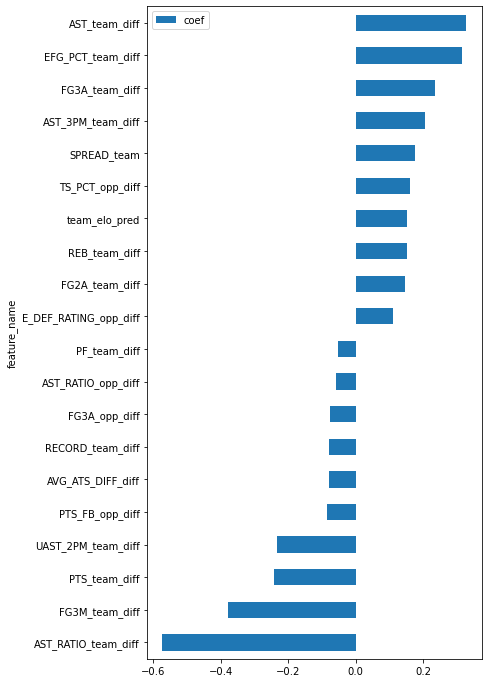

In [59]:

view_model_coefs(lr.named_steps['lr'], X_train[selected_cols])

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [ ]:
sfs_selected_cols_log

In [83]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_sgd_log)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                                      penalty='l2', max_iter=10000,
                                                                     verbose=1, random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lr2_select_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=1)

[I 2021-11-08 09:09:09,593] Using an existing study with name '../models/hyperparameter_tuning/study_lr2_select_sffs' instead of creating a new one.
[I 2021-11-08 09:09:16,824] Trial 201 finished with value: 0.5277938621887668 and parameters: {'C': 0.5075796722474852}. Best is trial 102 with value: 0.5382165605095541.


In [84]:
study_lr.trials_dataframe().sort_values(['value'])

number     value             datetime_start          datetime_complete  \
66       66  0.511870 2021-11-07 22:20:57.901336 2021-11-07 22:20:58.603314   
15       15  0.517024 2021-11-07 22:12:11.763977 2021-11-07 22:12:12.462942   
10       10  0.521830 2021-11-07 22:11:51.777569 2021-11-07 22:11:52.499547   
18       18  0.523914 2021-11-07 22:12:19.467820 2021-11-07 22:12:20.194784   
167     167  0.526057 2021-11-07 22:31:35.573707 2021-11-07 22:31:36.289033   
..      ...       ...                        ...                        ...   
173     173  0.538159 2021-11-07 22:32:00.765647 2021-11-07 22:32:05.273091   
113     113  0.538159 2021-11-07 22:26:52.349440 2021-11-07 22:26:57.729276   
109     109  0.538159 2021-11-07 22:26:29.860123 2021-11-07 22:26:35.608948   
102     102  0.538217 2021-11-07 22:25:28.648870 2021-11-07 22:25:33.524721   
200     200       NaN 2021-11-08 09:08:47.617370 2021-11-08 09:08:47.651369   

                  duration   params_C     state  
66  0 days 00:00:00.701978   0.000010  COMPLETE  
15  0 days 00:00:00.698965   0.000031  COMPLETE  
10  0 days 00:00:00.721978   0.000115  COMPLETE  
18  0 days 00:00:00.726964   0.000276  COMPLETE  
167 0 days 00:00:00.715326   0.000808  COMPLETE  
..                     ...        ...       ...  
173 0 days 00:00:04.507444   0.390368  COMPLETE  
113 0 days 00:00:05.379836   0.399168  COMPLETE  
109 0 days 00:00:05.748825   0.393153  COMPLETE  
102 0 days 00:00:04.875851   0.390874  COMPLETE  
200 0 days 00:00:00.033999  30.247030      FAIL  

[202 rows x 7 columns]

In [79]:
train_sample_weights

15450    0.334272
15451    0.334272
15466    0.334339
15467    0.334339
15474    0.334339
           ...   
41189    0.674489
41190    0.674894
41191    0.674894
41192    0.675299
41193    0.675299
Name: SAMPLE_WEIGHT, Length: 20725, dtype: float64

0.39087399430471714


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 286 epochs took 4 seconds
Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['RECORD_team_diff',
                                                   'FG2M_team_diff',
                                                   'FG2A_team_diff',
                                                   'STL_team_diff',
                                                   'TOV_team_diff',
                                                   'E_OFF_RATING_team_diff',
                                                   'E_NET_RATING_team_diff',
                                                   'PIE_team_diff',
                                                   'AST_2PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'UAST_3PM_team_diff',
                                                   'ATS_DIFF_team

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


feature_name      coef
33       TOV_PCT_team_diff -0.294462
1           FG2M_team_diff -0.218606
31     AST_RATIO_team_diff -0.175517
2           FG2A_team_diff -0.125835
10      UAST_3PM_team_diff -0.110349
20         PTS_FB_opp_diff -0.085326
0         RECORD_team_diff -0.081463
17             PF_opp_diff -0.078545
32      AST_RATIO_opp_diff -0.069754
28       AVG_ATS_DIFF_diff -0.038701
18   E_NET_RATING_opp_diff -0.035701
14           DREB_opp_diff -0.028065
22        AST_2PM_opp_diff -0.027526
21    PTS_OFF_TOV_opp_diff -0.016560
26         AVG_SPREAD_diff -0.015071
13           FG2A_opp_diff -0.010629
35           team_rating_i -0.001886
7            PIE_team_diff -0.001717
37                 ML_team  0.005665
23       UAST_3PM_opp_diff  0.010832
16            TOV_opp_diff  0.012204
27             AVG_ML_diff  0.017842
29               REST_diff  0.021331
24   TEAM_COVERED_opp_diff  0.032475
6   E_NET_RATING_team_diff  0.035701
3            STL_team_diff  0.039785
11      ATS_DIFF_team_diff  0.041241
19     PTS_2PT_MR_opp_diff  0.043266
15            STL_opp_diff  0.064035
25             WL_PCT_diff  0.072433
12         RECORD_opp_diff  0.081463
5   E_OFF_RATING_team_diff  0.083567
30        EFG_PCT_opp_diff  0.088050
9       UAST_2PM_team_diff  0.088304
34           team_elo_pred  0.103491
36             SPREAD_team  0.140190
4            TOV_team_diff  0.271186
8        AST_2PM_team_diff  0.310101

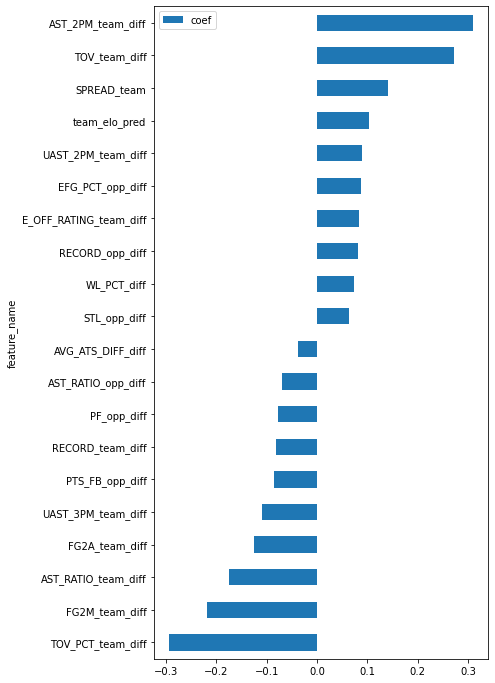

In [134]:
lr_C = study_lr.best_params['C']
print(lr_C)
best_lr = Pipeline([('selector', ColumnTransformer([
    ("selector", "passthrough", sfs_selected_cols_sgd_log)
], remainder="drop")),
                    ('scaler', StandardScaler()),
                    ('estimator', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=100000,
                                                 verbose=1, random_state=23))])
best_lr.fit(X_train, y_train, estimator__sample_weight = train_sample_weights)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

view_model_coefs(best_lr.named_steps['estimator'], X_train[sfs_selected_cols_sgd_log])

In [94]:
best_lr = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  sfs_selected_cols_sgd_log)])),
                ('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.39087399430471714, max_iter=100000,
                                    random_state=23, solver='saga',
                                    verbose=1))])

### SGD Hinge (SVC Linear)

In [212]:
sfs_pipe_sgd = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='hinge', random_state=23, alpha=0.03320641664870966),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    2.8s finished
Features: 1/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBacken

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.3s finished
Features: 21/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.2s finished
Features: 20/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.4s fin

Features: 29/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.6s finished
Features: 29/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.8s finished
Features: 30/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

Features: 27/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.3s finished
Features: 27/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.4s finished
Features: 28/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    4.6s finished
Features: 39/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    4.9s finished
Features: 40/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.2s finished
Features: 41/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elaps

Features: 45/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.0s finished
Features: 46/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    7.5s finished
Features: 47/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    9.0s finished
Features: 52/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    9.3s finished
Features: 53/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    9.1s finished
Features: 53/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elaps

[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:   11.3s finished
Features: 58/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   12.4s finished
Features: 59/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   12.4s fin

[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   14.3s finished
Features: 62/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   14.6s finished
Features: 63/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   15.7s fin

Features: 71/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   18.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   17.7s finished
Features: 70/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   20.1s finished
Features: 71/89[Parallel(n_jobs=1)]: Using backend SequentialBac

[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   21.9s finished
Features: 78/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   22.4s finished
Features: 79/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   21.9s fin

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   27.3s finished
Features: 85/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   27.3s finished
Features: 86/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   30.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   28.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   25.8s fin

Pipeline(steps=[('scaler', StandardScaler()),
                ('sffs',
                 SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                           estimator=SGDClassifier(alpha=0.03320641664870966,
                                                                   random_state=23),
                                           floating=True, k_features='best',
                                           scoring='accuracy', verbose=1))])

In [213]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

Index(['RECORD_team_diff', 'FG2M_team_diff', 'FG3M_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'REB_team_diff', 'AST_team_diff', 'STL_team_diff',
       'PTS_team_diff', 'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff',
       'E_NET_RATING_team_diff', 'POSS_team_diff', 'PIE_team_diff',
       'PTS_OFF_TOV_team_diff', 'AST_2PM_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'UAST_3PM_team_diff', 'RECORD_opp_diff',
       'FG2M_opp_diff', 'FG2A_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff',
       'FTA_opp_diff', 'OREB_opp_diff', 'TOV_opp_diff', 'PF_opp_diff',
       'PTS_opp_diff', 'PLUS_MINUS_opp_diff', 'E_DEF_RATING_opp_diff',
       'E_NET_RATING_opp_diff', 'PIE_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'TS_PCT_team_diff', 'EFG_PCT_team_diff'

In [125]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

Index(['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'REB_team_diff', 'AST_team_diff', 'STL_team_diff', 'PF_team_diff',
       'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'E_NET_RATING_team_diff', 'POSS_team_diff',
       'PIE_team_diff', 'PTS_OFF_TOV_team_diff', 'AST_2PM_team_diff',
       'AST_3PM_team_diff', 'UAST_2PM_team_diff', 'UAST_3PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG2A_opp_diff',
       'FG3A_opp_diff', 'AST_opp_diff', 'TOV_opp_diff', 'PF_opp_diff',
       'PLUS_MINUS_opp_diff', 'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff',
       'E_NET_RATING_opp_diff', 'POSS_opp_diff', 'PIE_opp_diff',
       'PTS_FB_opp_diff', 'PTS_OFF_TOV_opp_diff', 'UAST_2PM_opp_diff',
       'UAST_3PM_opp_diff', 'ATS_DIFF_opp_diff', 'TEAM_COVERED_opp_diff',
       'WL_PCT_diff', 'ATS_PCT_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff',
       'RE

In [95]:
sfs_selected_cols_hinge = ['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'REB_team_diff', 'AST_team_diff', 'STL_team_diff', 'PF_team_diff',
       'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'E_NET_RATING_team_diff', 'POSS_team_diff',
       'PIE_team_diff', 'PTS_OFF_TOV_team_diff', 'AST_2PM_team_diff',
       'AST_3PM_team_diff', 'UAST_2PM_team_diff', 'UAST_3PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG2A_opp_diff',
       'FG3A_opp_diff', 'AST_opp_diff', 'TOV_opp_diff', 'PF_opp_diff',
       'PLUS_MINUS_opp_diff', 'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff',
       'E_NET_RATING_opp_diff', 'POSS_opp_diff', 'PIE_opp_diff',
       'PTS_FB_opp_diff', 'PTS_OFF_TOV_opp_diff', 'UAST_2PM_opp_diff',
       'UAST_3PM_opp_diff', 'ATS_DIFF_opp_diff', 'TEAM_COVERED_opp_diff',
       'WL_PCT_diff', 'ATS_PCT_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff',
       'REST_diff', 'OREB_PCT_team_diff', 'TS_PCT_team_diff',
       'TS_PCT_opp_diff', 'EFG_PCT_team_diff', 'EFG_PCT_opp_diff',
       'AST_RATIO_team_diff', 'AST_RATIO_opp_diff', 'TOV_PCT_opp_diff',
       'team_elo_pred', 'SPREAD_team', 'ML_team']

In [96]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('estimator', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=5000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_hinge_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=1, show_progress_bar=True)

[I 2021-11-08 12:32:55,656] Using an existing study with name '../models/hyperparameter_tuning/study_sgd_hinge_sffs' instead of creating a new one.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2021-11-08 12:32:58,869] Trial 300 finished with value: 0.5314418066010423 and parameters: {'alpha': 0.015147008949399583}. Best is trial 212 with value: 0.5384481760277938.


In [135]:
sgd_alpha = study_sgd.best_params['alpha']
print('C:', sgd_alpha)

best_sgd_hinge = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('estimator', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=1000,
                                     random_state=23))])


best_sgd_hinge.fit(X_train, y_train, estimator__sample_weight = train_sample_weights)

print("best_svc:", best_sgd_hinge)


print("train_score:", best_sgd_hinge.score(X_train, y_train))
print("test_score:", best_sgd_hinge.score(X_test, y_test))

C: 0.649475972966215
best_svc: Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['RECORD_team_diff',
                                                   'FG2M_team_diff',
                                                   'FG2A_team_diff',
                                                   'FG3A_team_diff',
                                                   'FTM_team_diff',
                                                   'FTA_team_diff',
                                                   'OREB_team_diff',
                                                   'REB_team_diff',
                                                   'AST_team_diff',
                                                   'STL_team_diff',
                                                   'PF_team_diff',
                                                   'PLUS_MINUS_team_diff',
                                  

### SGD modified_huber

In [214]:
sfs_pipe_sgd_huber = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='modified_huber', random_state=23, alpha=0.56299),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd_huber.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    3.3s finished
Features: 1/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBacken

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished
Features: 14/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished
Features: 15/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
Features: 16/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elaps

Features: 26/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.9s finished
Features: 27/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.1s finished
Features: 28/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.9s finished
Features: 27/89[Parallel

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    3.1s finished
Features: 34/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    3.2s finished
[Parallel

Features: 45/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.4s finished
Features: 46/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    5.7s finished
Features: 47/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    6.8s finished
Features: 52/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    6.7s finished
Features: 53/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    6.8s finished
Features: 54/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elaps

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    8.9s finished
Features: 62/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    8.9s finished
Features: 62/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    9.2s finished
Features: 63/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elaps

[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    9.5s finished
Features: 64/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.7s finished
Features: 65/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   10.0s finished
Features: 66/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  66 out of  66 | elaps

Features: 69/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   11.3s finished
Features: 70/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   11.9s finished
Features: 71/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   15.1s finished
Features: 79/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   15.5s finished
Features: 80/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   15.9s finished
Features: 81/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elaps

[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   16.8s finished
Features: 83/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   17.9s finished
Features: 84/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   18.0s finished
Features: 85/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elaps

Pipeline(steps=[('scaler', StandardScaler()),
                ('sffs',
                 SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                           estimator=SGDClassifier(alpha=0.56299,
                                                                   loss='modified_huber',
                                                                   random_state=23),
                                           floating=True, k_features='best',
                                           scoring='accuracy', verbose=1))])

In [215]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

Index(['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'STL_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'PIE_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_2PM_team_diff', 'AST_3PM_team_diff', 'UAST_2PM_team_diff',
       'UAST_3PM_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3A_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_3PM_opp_diff', 'UAST_2PM_opp_diff', 'TEAM_COVERED_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'TS_PCT_team_diff', 'AST_RATIO_team_diff',
       'AST_RATIO_opp_diff', 'TOV_PCT_opp_diff', 'ML_team'],
      dtype='object')

In [99]:
sfs_selected_cols_huber = ['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'STL_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'PIE_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_2PM_team_diff', 'AST_3PM_team_diff', 'UAST_2PM_team_diff',
       'UAST_3PM_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3A_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_3PM_opp_diff', 'UAST_2PM_opp_diff', 'TEAM_COVERED_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'TS_PCT_team_diff', 'AST_RATIO_team_diff',
       'AST_RATIO_opp_diff', 'TOV_PCT_opp_diff', 'ML_team']

In [131]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

Index(['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3M_team_diff', 'FG3A_team_diff', 'OREB_team_diff', 'DREB_team_diff',
       'REB_team_diff', 'E_DEF_RATING_team_diff', 'PIE_team_diff',
       'AST_2PM_team_diff', 'AST_3PM_team_diff', 'UAST_2PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG3A_opp_diff',
       'PTS_2PT_MR_opp_diff', 'PTS_FB_opp_diff', 'UAST_3PM_opp_diff',
       'ATS_DIFF_opp_diff', 'TEAM_COVERED_opp_diff', 'WL_PCT_diff',
       'REST_diff', 'AST_RATIO_team_diff', 'ML_team'],
      dtype='object')

In [100]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('estimator', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_sgd_huber_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=1, show_progress_bar = True)

[I 2021-11-08 12:34:24,367] Using an existing study with name 'study_sgd_huber_sffs' instead of creating a new one.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2021-11-08 12:34:24,946] Trial 300 finished with value: 0.5279675738274464 and parameters: {'alpha': 0.1929570058567848}. Best is trial 172 with value: 0.5364215402431963.


0.649475972966215
best_sgd: Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['RECORD_team_diff',
                                                   'FG2M_team_diff',
                                                   'FG2A_team_diff',
                                                   'FG3A_team_diff',
                                                   'FTM_team_diff',
                                                   'FTA_team_diff',
                                                   'OREB_team_diff',
                                                   'DREB_team_diff',
                                                   'STL_team_diff',
                                                   'E_OFF_RATING_team_diff',
                                                   'E_DEF_RATING_team_diff',
                                                   'PIE_team_diff',
                        

feature_name      coef
24         PTS_FB_opp_diff -0.019765
16      UAST_3PM_team_diff -0.016418
2           FG2A_team_diff -0.012679
19           FG3A_opp_diff -0.011875
0         RECORD_team_diff -0.011824
32      AST_RATIO_opp_diff -0.010959
21            AST_opp_diff -0.009573
18           FG2M_opp_diff -0.007080
15      UAST_2PM_team_diff -0.003242
11           PIE_team_diff -0.002303
1           FG2M_team_diff -0.002186
20            FTA_opp_diff -0.001966
28             WL_PCT_diff -0.001420
4            FTM_team_diff -0.000016
5            FTA_team_diff  0.000521
29               REST_diff  0.000693
13       AST_2PM_team_diff  0.001340
31     AST_RATIO_team_diff  0.001370
9   E_OFF_RATING_team_diff  0.001976
23   E_DEF_RATING_opp_diff  0.001976
30        TS_PCT_team_diff  0.003931
26       UAST_2PM_opp_diff  0.005283
6           OREB_team_diff  0.005455
25        AST_3PM_opp_diff  0.006496
10  E_DEF_RATING_team_diff  0.007326
22   E_OFF_RATING_opp_diff  0.007326
7           DREB_team_diff  0.007875
34                 ML_team  0.008321
14       AST_3PM_team_diff  0.008637
3           FG3A_team_diff  0.008883
27   TEAM_COVERED_opp_diff  0.011175
17         RECORD_opp_diff  0.011824
33        TOV_PCT_opp_diff  0.011911
8            STL_team_diff  0.012649
12   PTS_OFF_TOV_team_diff  0.013948

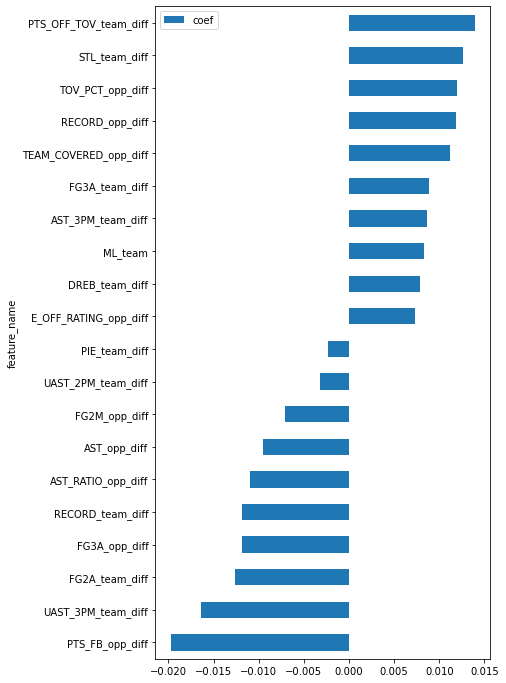

In [136]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_huber = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('estimator', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])

print("best_sgd:", best_sgd_huber)

best_sgd_huber.fit(X_train, y_train, estimator__sample_weight = train_sample_weights)

print("train_score:", best_sgd_huber.score(X_train, y_train))
print("test_score:", best_sgd_huber.score(X_test, y_test))

view_model_coefs(best_sgd_huber.named_steps['estimator'], X_train[sfs_selected_cols_huber])

### LGBClassifier

In [189]:
sfs_pipe_lgb = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_lgb.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:   21.5s finished
Features: 1/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   21.1s finished
Features: 2/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   32.8s finished
Features: 3/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   27.4s finished
Features: 4/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   25.9s finished
Features: 5/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   27.1s finished
Features: 6/89[Parallel(

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   25.9s finished
Features: 50/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   25.6s finished
Features: 51/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   25.9s finished
Features: 52/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   26.0s finished
Features: 53/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   25.6s finished
Features: 54/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   24.7s finished
Features: 55/89[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Par

Pipeline(steps=[('scaler', StandardScaler()),
                ('sfs',
                 SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                           estimator=LGBMClassifier(colsample_bytree=0.30306249172980904,
                                                                    learning_rate=0.03464725063611881,
                                                                    max_depth=3,
                                                                    min_child_weight=0.6782064406615411,
                                                                    num_leaves=120,
                                                                    random_state=23,
                                                                    reg_alpha=2.5908850696822157,
                                                                    reg_lambda=6.57863348422055,
                                                    

In [190]:
res = pd.DataFrame.from_dict(sfs_pipe_lgb.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_lgb = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_lgb

Index(['FG3A_team_diff', 'FTA_team_diff', 'E_DEF_RATING_team_diff',
       'PTS_2PT_MR_team_diff', 'PTS_OFF_TOV_team_diff', 'RECORD_opp_diff',
       'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff', 'OREB_opp_diff',
       'DREB_opp_diff', 'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff',
       'POSS_opp_diff', 'PTS_FB_opp_diff', 'AST_2PM_opp_diff',
       'UAST_3PM_opp_diff', 'TEAM_COVERED_opp_diff', 'ATS_PCT_diff',
       'TS_PCT_opp_diff', 'AST_RATIO_opp_diff', 'TOV_PCT_team_diff',
       'TOV_PCT_opp_diff', 'team_elo_pred'],
      dtype='object')

In [111]:
sfs_selected_cols_lgb = ['FG3A_team_diff', 'FTA_team_diff', 'E_DEF_RATING_team_diff',
       'PTS_2PT_MR_team_diff', 'PTS_OFF_TOV_team_diff', 'RECORD_opp_diff',
       'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff', 'OREB_opp_diff',
       'DREB_opp_diff', 'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff',
       'POSS_opp_diff', 'PTS_FB_opp_diff', 'AST_2PM_opp_diff',
       'UAST_3PM_opp_diff', 'TEAM_COVERED_opp_diff', 'ATS_PCT_diff',
       'TS_PCT_opp_diff', 'AST_RATIO_opp_diff', 'TOV_PCT_team_diff',
       'TOV_PCT_opp_diff', 'team_elo_pred']

In [104]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_lgb)], remainder="drop")),
        ('lgbc', lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=1, show_progress_bar=True)

[I 2021-11-08 12:41:24,891] Using an existing study with name '../models/hyperparameter_tuning/study_lgbc_sfs' instead of creating a new one.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2021-11-08 12:41:27,909] Trial 200 finished with value: 0.5343949044585987 and parameters: {'min_child_weight': 0.13350997023834976, 'subsample': 0.8338038144208384, 'max_depth': 3, 'reg_lambda': 1.1566076317367049, 'reg_alpha': 0.22167971416947907, 'num_leaves': 323, 'colsample_bytree': 0.2683018512854743, 'learning_rate': 0.06111121448545495}. Best is trial 163 with value: 0.5343949044585987.


best_lgbc: Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['FG3A_team_diff',
                                                   'FTA_team_diff',
                                                   'E_DEF_RATING_team_diff',
                                                   'PTS_2PT_MR_team_diff',
                                                   'PTS_OFF_TOV_team_diff',
                                                   'RECORD_opp_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'FTA_opp_diff',
                                                   'OREB_opp_diff',
                                                   'DREB_opp_diff',
                                                   'E_OFF_RATING_opp_diff',
                                  

feature_name  coef
1            FTA_team_diff    23
13           POSS_opp_diff    23
11   E_OFF_RATING_opp_diff    24
10           DREB_opp_diff    27
23           team_elo_pred    27
15        AST_2PM_opp_diff    31
9            OREB_opp_diff    32
7             FTM_opp_diff    34
5          RECORD_opp_diff    38
17   TEAM_COVERED_opp_diff    42
21       TOV_PCT_team_diff    43
3     PTS_2PT_MR_team_diff    54
18            ATS_PCT_diff    54
6            FG3A_opp_diff    65
2   E_DEF_RATING_team_diff    65
22        TOV_PCT_opp_diff    74
16       UAST_3PM_opp_diff    79
19         TS_PCT_opp_diff    84
14         PTS_FB_opp_diff    96
12   E_DEF_RATING_opp_diff    98
8             FTA_opp_diff   100
20      AST_RATIO_opp_diff   105
0           FG3A_team_diff   106
4    PTS_OFF_TOV_team_diff   149

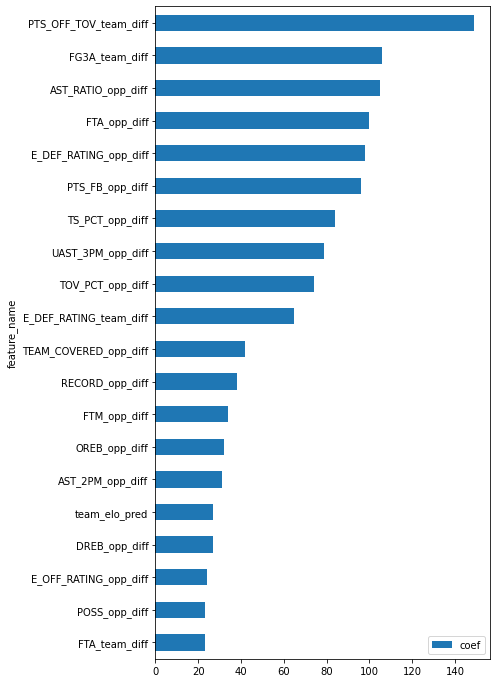

In [138]:
lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_lgb)], remainder="drop")),
        ('estimator', lgb.LGBMClassifier())])

best_lgbc.named_steps['estimator'].set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train, estimator__sample_weight=train_sample_weights)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc.named_steps['estimator'], X_train[sfs_selected_cols_lgb])


In [156]:
best_lgbc = lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508)

In [118]:
from sklearn.decomposition import PCA
np.linspace(0.9, 0.99, 10)

array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

### KNNeighbors

In [142]:
sfs_pipe_knn = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=0.99)),
                                    ('knn',
                                     SFS(KNeighborsClassifier(n_neighbors=47),
                                    k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_knn.fit(X_train, y_train)




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   21.4s finished
Features: 1/38[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   23.4s finished
Features: 2/38[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   26.8s finished
Features: 3/38[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   31.6s finished
Features: 4/38[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   44.9s finished
Features: 5/38[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   47.3s finished
Features: 6/38[Parallel(

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('knn',
                 SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                           estimator=KNeighborsClassifier(n_neighbors=47),
                                           k_features='best',
                                           scoring='accuracy', verbose=1))])

In [144]:
res = pd.DataFrame.from_dict(sfs_pipe_knn.named_steps['knn'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_knn = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_knn

AttributeError: 'Index' object has no attribute 'named_steps'

In [115]:
sfs_selected_cols_knn = ['FG2M_team_diff', 'FG2A_team_diff', 'FTM_team_diff', 'AST_team_diff',
       'BLK_team_diff', 'TOV_team_diff', 'PF_team_diff',
       'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff', 'POSS_team_diff',
       'PIE_team_diff', 'PTS_2PT_MR_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_3PM_team_diff', 'UAST_2PM_team_diff', 'UAST_3PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3M_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff']

In [149]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    n_components = trial.suggest_float('n_components', 0.9, 0.99)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
                ('estimator',
                 KNeighborsClassifier(n_neighbors=n_neighbors))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(3, 50, 4).tolist(),
               'n_components':np.linspace(0.9, 0.99, 10).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

[I 2021-11-06 20:05:50,749] A new study created in RDB with name: ../models/hyperparameter_tuning/study_knn_sfs
[I 2021-11-06 20:05:54,813] Trial 0 finished with value: 0.5123914302258251 and parameters: {'n_neighbors': 31, 'n_components': 0.92}. Best is trial 0 with value: 0.5123914302258251.
[I 2021-11-06 20:05:56,916] Trial 1 finished with value: 0.5132599884192242 and parameters: {'n_neighbors': 19, 'n_components': 0.9}. Best is trial 1 with value: 0.5132599884192242.
[I 2021-11-06 20:05:59,419] Trial 2 finished with value: 0.5086276780544297 and parameters: {'n_neighbors': 39, 'n_components': 0.92}. Best is trial 1 with value: 0.5132599884192242.
[I 2021-11-06 20:06:02,653] Trial 3 finished with value: 0.5082802547770701 and parameters: {'n_neighbors': 39, 'n_components': 0.96}. Best is trial 1 with value: 0.5132599884192242.
[I 2021-11-06 20:06:05,045] Trial 4 finished with value: 0.514997104806022 and parameters: {'n_neighbors': 27, 'n_components': 0.93}. Best is trial 4 with va

[I 2021-11-06 20:07:36,186] Trial 42 finished with value: 0.511638679791546 and parameters: {'n_neighbors': 43, 'n_components': 0.97}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:07:38,262] Trial 43 finished with value: 0.5126230457440648 and parameters: {'n_neighbors': 19, 'n_components': 0.92}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:07:41,063] Trial 44 finished with value: 0.5141864504921829 and parameters: {'n_neighbors': 19, 'n_components': 0.98}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:07:43,468] Trial 45 finished with value: 0.5086276780544297 and parameters: {'n_neighbors': 39, 'n_components': 0.93}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:07:45,999] Trial 46 finished with value: 0.5104806022003474 and parameters: {'n_neighbors': 19, 'n_components': 0.97}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:07:48,150] Trial 47 finished with value: 0.5042848870874349 and param

[I 2021-11-06 20:09:13,364] Trial 84 finished with value: 0.5067168500289518 and parameters: {'n_neighbors': 43, 'n_components': 0.91}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:09:15,303] Trial 85 finished with value: 0.5123335263462653 and parameters: {'n_neighbors': 15, 'n_components': 0.9}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:09:18,100] Trial 86 finished with value: 0.5068326577880718 and parameters: {'n_neighbors': 31, 'n_components': 0.99}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:09:20,199] Trial 87 finished with value: 0.5063115228720324 and parameters: {'n_neighbors': 39, 'n_components': 0.91}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:09:22,078] Trial 88 finished with value: 0.5123335263462653 and parameters: {'n_neighbors': 15, 'n_components': 0.91}. Best is trial 4 with value: 0.514997104806022.
[I 2021-11-06 20:09:23,911] Trial 89 finished with value: 0.5077012159814708 and param

In [116]:
study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_knn = optuna.load_study(study_name, storage_name)

In [139]:
best_n = study_knn.best_trial.params['n_neighbors']
best_n_components = study_knn.best_trial.params['n_components']
best_knn = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_n_components)),
                ('estimator',
                 KNeighborsClassifier(n_neighbors=best_n))])

print("best_sgd:", best_knn)

best_knn.fit(X_train, y_train)

print("train_score:", best_knn.score(X_train, y_train))
print("test_score:", best_knn.score(X_test, y_test))

best_sgd: Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['FG2M_team_diff',
                                                   'FG2A_team_diff',
                                                   'FTM_team_diff',
                                                   'AST_team_diff',
                                                   'BLK_team_diff',
                                                   'TOV_team_diff',
                                                   'PF_team_diff',
                                                   'PLUS_MINUS_team_diff',
                                                   'E_OFF_RATING_team_diff',
                                                   'POSS_team_diff',
                                                   'PIE_team_diff',
                                                   'PTS_2PT_MR_team_diff',
                                           

### Random Forest

In [219]:
sfs_pipe_rf = SFS(RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23), k_features=25, cv=tscv, scoring='accuracy', floating=True, verbose=1)


sfs_pipe_rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:  6.6min finished
Features: 1/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished
Features: 2/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s finished
Features: 3/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBacken

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=RandomForestClassifier(max_depth=9,
                                                           min_samples_leaf=0.010338564023847334,
                                                           min_samples_split=0.017844890716741457,
                                                           random_state=23),
                          floating=True, k_features=25, scoring='accuracy',
                          verbose=1)

In [220]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

['STL_team_diff',
 'PTS_2PT_MR_team_diff',
 'AST_2PM_team_diff',
 'UAST_2PM_team_diff',
 'STL_opp_diff',
 'BLK_opp_diff',
 'PTS_2PT_MR_opp_diff',
 'PTS_FB_opp_diff',
 'OREB_PCT_team_diff',
 'TS_PCT_opp_diff',
 'EFG_PCT_opp_diff',
 'AST_RATIO_opp_diff',
 'team_elo_pred']

In [199]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

['REB_team_diff',
 'AST_3PM_team_diff',
 'UAST_2PM_team_diff',
 'FG3A_opp_diff',
 'FTM_opp_diff',
 'DREB_opp_diff',
 'REB_opp_diff',
 'PTS_2PT_MR_opp_diff',
 'PTS_FB_opp_diff',
 'AST_2PM_opp_diff',
 'ATS_DIFF_opp_diff',
 'TEAM_COVERED_opp_diff',
 'TS_PCT_opp_diff',
 'EFG_PCT_opp_diff',
 'AST_RATIO_opp_diff']

In [122]:
sfs_selected_cols_rf = ['REB_team_diff',
 'AST_3PM_team_diff',
 'UAST_2PM_team_diff',
 'FG3A_opp_diff',
 'FTM_opp_diff',
 'DREB_opp_diff',
 'REB_opp_diff',
 'PTS_2PT_MR_opp_diff',
 'PTS_FB_opp_diff',
 'AST_2PM_opp_diff',
 'ATS_DIFF_opp_diff',
 'TEAM_COVERED_opp_diff',
 'TS_PCT_opp_diff',
 'EFG_PCT_opp_diff',
 'AST_RATIO_opp_diff']

In [222]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('rf', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])
    
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_rf2_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=250)

[I 2021-11-07 21:35:09,896] A new study created in RDB with name: ../models/hyperparameter_tuning/study_rf2_sffs
[I 2021-11-07 21:35:13,817] Trial 0 finished with value: 0.5244933410538506 and parameters: {'min_samples_split': 0.30049311143639595, 'max_depth': 30, 'min_samples_leaf': 0.031908231550304145}. Best is trial 0 with value: 0.5244933410538506.
[I 2021-11-07 21:35:15,097] Trial 1 finished with value: 0.5127388535031847 and parameters: {'min_samples_split': 0.43349639870897777, 'max_depth': 28, 'min_samples_leaf': 0.25855990419169417}. Best is trial 0 with value: 0.5244933410538506.
[I 2021-11-07 21:35:17,015] Trial 2 finished with value: 0.5228141285466126 and parameters: {'min_samples_split': 0.305812631034427, 'max_depth': 6, 'min_samples_leaf': 0.034239983385758656}. Best is trial 0 with value: 0.5244933410538506.
[I 2021-11-07 21:35:19,067] Trial 3 finished with value: 0.5243196294151707 and parameters: {'min_samples_split': 0.2815580079237897, 'max_depth': 18, 'min_sample

[I 2021-11-07 21:36:15,499] Trial 32 finished with value: 0.5244354371742906 and parameters: {'min_samples_split': 0.06030190997433507, 'max_depth': 3, 'min_samples_leaf': 0.045931759816115636}. Best is trial 15 with value: 0.5280254777070063.
[I 2021-11-07 21:36:17,309] Trial 33 finished with value: 0.5180660104226983 and parameters: {'min_samples_split': 0.036450491165351276, 'max_depth': 10, 'min_samples_leaf': 0.10207229634323978}. Best is trial 15 with value: 0.5280254777070063.
[I 2021-11-07 21:36:19,809] Trial 34 finished with value: 0.5305153445280835 and parameters: {'min_samples_split': 0.10343617670917564, 'max_depth': 5, 'min_samples_leaf': 0.041549315118501726}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:36:21,332] Trial 35 finished with value: 0.5218876664736537 and parameters: {'min_samples_split': 0.4865591346402012, 'max_depth': 5, 'min_samples_leaf': 0.04160609011329607}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:36:23,42

[I 2021-11-07 21:37:23,589] Trial 64 finished with value: 0.5272148233931673 and parameters: {'min_samples_split': 0.05169530616311722, 'max_depth': 14, 'min_samples_leaf': 0.03898311311829095}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:37:26,115] Trial 65 finished with value: 0.5251881876085698 and parameters: {'min_samples_split': 0.09296661116491567, 'max_depth': 18, 'min_samples_leaf': 0.05225205579378149}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:37:28,063] Trial 66 finished with value: 0.5228141285466126 and parameters: {'min_samples_split': 0.15394167415643806, 'max_depth': 16, 'min_samples_leaf': 0.08377040079900044}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:37:29,915] Trial 67 finished with value: 0.5180081065431384 and parameters: {'min_samples_split': 0.1252947654450671, 'max_depth': 12, 'min_samples_leaf': 0.10160948413756613}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:37:31,50

[I 2021-11-07 21:38:39,875] Trial 96 finished with value: 0.5279675738274465 and parameters: {'min_samples_split': 0.0835688978745329, 'max_depth': 9, 'min_samples_leaf': 0.03312789311001539}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:38:42,262] Trial 97 finished with value: 0.5271569195136074 and parameters: {'min_samples_split': 0.024065897355791552, 'max_depth': 9, 'min_samples_leaf': 0.049260498777462164}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:38:44,179] Trial 98 finished with value: 0.5177764910248986 and parameters: {'min_samples_split': 0.07914769250198683, 'max_depth': 16, 'min_samples_leaf': 0.10195221139276668}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:38:46,154] Trial 99 finished with value: 0.523335263462652 and parameters: {'min_samples_split': 0.2610954753840597, 'max_depth': 4, 'min_samples_leaf': 0.03381415754925181}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:38:48,187] 

[I 2021-11-07 21:39:52,417] Trial 128 finished with value: 0.5207295888824552 and parameters: {'min_samples_split': 0.1316716077481189, 'max_depth': 17, 'min_samples_leaf': 0.06780229025436707}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:39:54,973] Trial 129 finished with value: 0.5280833815865663 and parameters: {'min_samples_split': 0.04405212593054058, 'max_depth': 12, 'min_samples_leaf': 0.03887004416523238}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:39:57,250] Trial 130 finished with value: 0.5231036479444123 and parameters: {'min_samples_split': 0.04482069888450824, 'max_depth': 5, 'min_samples_leaf': 0.05386672041478044}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:39:59,940] Trial 131 finished with value: 0.5264041690793283 and parameters: {'min_samples_split': 0.10613483108760347, 'max_depth': 10, 'min_samples_leaf': 0.026782820975892227}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:40:0

[I 2021-11-07 21:41:11,325] Trial 160 finished with value: 0.5265778807180082 and parameters: {'min_samples_split': 0.07687949395783997, 'max_depth': 12, 'min_samples_leaf': 0.03944971034589534}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:41:13,929] Trial 161 finished with value: 0.5287782281412855 and parameters: {'min_samples_split': 0.09832947473234535, 'max_depth': 12, 'min_samples_leaf': 0.041443542887297416}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:41:16,302] Trial 162 finished with value: 0.5265199768384481 and parameters: {'min_samples_split': 0.10841373325034867, 'max_depth': 10, 'min_samples_leaf': 0.05108221600638102}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:41:18,859] Trial 163 finished with value: 0.5278517660683265 and parameters: {'min_samples_split': 0.06538369662021085, 'max_depth': 12, 'min_samples_leaf': 0.03969929976828726}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:41

[I 2021-11-07 21:42:29,733] Trial 192 finished with value: 0.5295309785755645 and parameters: {'min_samples_split': 0.09577491457282453, 'max_depth': 14, 'min_samples_leaf': 0.02352521863093108}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:42:32,430] Trial 193 finished with value: 0.5255935147654893 and parameters: {'min_samples_split': 0.13202696734272193, 'max_depth': 15, 'min_samples_leaf': 0.01958335778833251}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:42:35,288] Trial 194 finished with value: 0.5270411117544875 and parameters: {'min_samples_split': 0.120238247311593, 'max_depth': 14, 'min_samples_leaf': 0.010427422611534383}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:42:37,859] Trial 195 finished with value: 0.527504342790967 and parameters: {'min_samples_split': 0.09894943563379004, 'max_depth': 14, 'min_samples_leaf': 0.029586135838320447}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:42:4

[I 2021-11-07 21:43:49,170] Trial 224 finished with value: 0.5269253039953676 and parameters: {'min_samples_split': 0.04328741254441929, 'max_depth': 11, 'min_samples_leaf': 0.018758512651752983}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:43:51,847] Trial 225 finished with value: 0.5270990156340475 and parameters: {'min_samples_split': 0.08403015833326215, 'max_depth': 8, 'min_samples_leaf': 0.03351437545260648}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:43:54,365] Trial 226 finished with value: 0.5255935147654893 and parameters: {'min_samples_split': 0.09499114359904223, 'max_depth': 11, 'min_samples_leaf': 0.05227198870021976}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:43:56,926] Trial 227 finished with value: 0.5288361320208453 and parameters: {'min_samples_split': 0.12279593687556821, 'max_depth': 15, 'min_samples_leaf': 0.040149300638476035}. Best is trial 34 with value: 0.5305153445280835.
[I 2021-11-07 21:43

In [123]:
study_name = '../models/hyperparameter_tuning/study_rf2_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.load_study(study_name, storage_name)

In [140]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('estimator', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])

print(best_rf)

best_rf.fit(X_train, y_train, estimator__sample_weight = train_sample_weights)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

{'max_depth': 5, 'min_samples_leaf': 0.041549315118501726, 'min_samples_split': 0.10343617670917564}
Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['REB_team_diff',
                                                   'AST_3PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'DREB_opp_diff',
                                                   'REB_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'AST_2PM_opp_diff',
                                                   'ATS_DIFF_opp_diff',
                       

In [226]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['STL_team_diff',
                                                   'PTS_2PT_MR_team_diff',
                                                   'AST_2PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'STL_opp_diff',
                                                   'BLK_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'OREB_PCT_team_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff',
                                                   'team_elo_pred'])])),
                ('rf',
                 RandomForestClassifier(max_depth=5,
                                        min_samples_leaf=0.041549315118501726,
                                        min_samples_split=0.10343617670917564,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

rf train_acc: 0.5507840772014475
rf test_acc: 0.5114989398140597


In [141]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['REB_team_diff',
                                                   'AST_3PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'DREB_opp_diff',
                                                   'REB_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'AST_2PM_opp_diff',
                                                   'ATS_DIFF_opp_diff',
                                                   'TEAM_COVERED_opp_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff'])])),
                ('estimator',
                 RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

rf train_acc: 0.5849939686369119
rf test_acc: 0.5161474473984669


LGBoost or XGBoost


feature_name      coef
6            REB_opp_diff  0.042253
3           FG3A_opp_diff  0.045429
0           REB_team_diff  0.047945
5           DREB_opp_diff  0.048209
7     PTS_2PT_MR_opp_diff  0.054621
4            FTM_opp_diff  0.057590
10      ATS_DIFF_opp_diff  0.059885
11  TEAM_COVERED_opp_diff  0.060382
14     AST_RATIO_opp_diff  0.062504
2      UAST_2PM_team_diff  0.069819
9        AST_2PM_opp_diff  0.078606
1       AST_3PM_team_diff  0.080213
13       EFG_PCT_opp_diff  0.085528
12        TS_PCT_opp_diff  0.094573
8         PTS_FB_opp_diff  0.112443

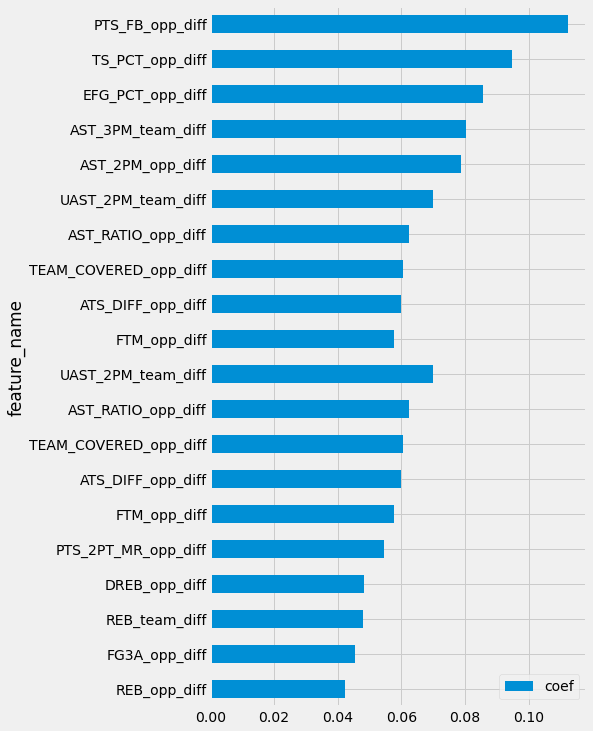

In [207]:
view_model_coefs(best_rf.named_steps['rf'], X_train[sfs_selected_cols_rf])

## Stacked Classifier

### with select features

In [181]:
cutoff_22

53909

In [187]:
X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[5])
X_train1

RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
53669         -0.094598        0.674764        0.181271        0.143275   
53670          0.014868        0.507277        1.463215        0.128950   
53671         -0.014868       -0.507277       -1.463215       -0.128950   
53672         -0.113386       -0.556549       -0.416834       -0.216059   
53673          0.113386        0.556549        0.416834        0.216059   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
53669        4.353561      -0.626273       2.676078        4.164678   
53670        4.518219       0.236402       3.408511        4.948255   
53671       -4.518219      -0.236402      -3.408511       -4.948255   
53672       -4.966426      -0.112759      -3.667677       -4.753420   
53673        4.966426       0.112759       3.667677        4.753420   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
53669        0.115788       4.280466      -0.415827       1.811564   
53670       -0.295814       4.652442       0.025783       2.430444   
53671        0.295814      -4.652442      -0.025783      -2.430444   
53672        0.366231      -4.387189      -0.323220      -1.987376   
53673       -0.366231       4.387189       0.323220       1.987376   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
53669       0.769375       0.592062     -1.373597       1.153082   
53670       0.092396      -0.667218     -1.836266       1.637806   
53671      -0.092396       0.667218      1.836266      -1.637806   
53672       0.316864       0.300476      1.952645      -1.874032   
53673      -0.316864      -0.300476     -1.952645       1.874032   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
53669             -0.414971               

In [142]:

from sklearn.ensemble import StackingClassifier
from copy import deepcopy

import numpy as np
from joblib import Parallel

from sklearn.base import clone
from sklearn.base import is_classifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import check_cv

from sklearn.utils import Bunch
from sklearn.utils.fixes import delayed

from sklearn.pipeline import Pipeline

ESTIMATOR_NAME_IN_PIPELINE = 'estimator'

def new_fit_single_estimator(estimator, X, y, sample_weight=None,
                             message_clsname=None, message=None):
    """Private function used to fit an estimator within a job."""
    if sample_weight is not None:
        try:
            if isinstance(estimator, Pipeline):
                # determine name of final estimator
                estimator_name = estimator.steps[-1][0]
                kwargs = {estimator_name + '__sample_weight': sample_weight}
                estimator.fit(X, y, **kwargs)
            else:
                estimator.fit(X, y, sample_weight=sample_weight)
        except TypeError as exc:
            if "unexpected keyword argument 'sample_weight'" in str(exc):
                raise TypeError(
                    "Underlying estimator {} does not support sample weights."
                    .format(estimator.__class__.__name__)
                ) from exc
            raise
    else:
        estimator.fit(X, y)
    return estimator


class FlexibleStackingClassifier(StackingClassifier):

    def __init__(self, estimators, final_estimator=None, *, cv=None,
                 n_jobs=None, passthrough=False, verbose=0):
        super().__init__(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=cv,
            n_jobs=n_jobs,
            passthrough=passthrough,
            verbose=verbose
        )

    def fit(self, X, y, sample_weight=None):
        """Fit the estimators.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Target values.
        sample_weight : array-like of shape (n_samples,) or default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if all underlying estimators
            support sample weights.
            .. versionchanged:: 0.23
               when not None, `sample_weight` is passed to all underlying
               estimators

        Returns
        -------
        self : object
        """
        # all_estimators contains all estimators, the one to be fitted and the
        # 'drop' string.
        names, all_estimators = self._validate_estimators()
        self._validate_final_estimator()

        stack_method = [self.stack_method] * len(all_estimators)

        # Fit the base estimators on the whole training data. Those
        # base estimators will be used in transform, predict, and
        # predict_proba. They are exposed publicly.
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(new_fit_single_estimator)(clone(est), X, y, sample_weight)
            for est in all_estimators if est != 'drop'
        )

        self.named_estimators_ = Bunch()
        est_fitted_idx = 0
        for name_est, org_est in zip(names, all_estimators):
            if org_est != 'drop':
                self.named_estimators_[name_est] = self.estimators_[
                    est_fitted_idx]
                est_fitted_idx += 1
            else:
                self.named_estimators_[name_est] = 'drop'

        # To train the meta-classifier using the most data as possible, we use
        # a cross-validation to obtain the output of the stacked estimators.

        # To ensure that the data provided to each estimator are the same, we
        # need to set the random state of the cv if there is one and we need to
        # take a copy.
        cv = check_cv(self.cv, y=y, classifier=is_classifier(self))
        if hasattr(cv, 'random_state') and cv.random_state is None:
            cv.random_state = np.random.RandomState()

        self.stack_method_ = [
            self._method_name(name, est, meth)
            for name, est, meth in zip(names, all_estimators, stack_method)
        ]
        fit_params = ({f"{ESTIMATOR_NAME_IN_PIPELINE}__sample_weight": sample_weight}
                      if sample_weight is not None
                      else None)
        predictions = Parallel(n_jobs=self.n_jobs)(
            delayed(cross_val_predict)(clone(est), X, y, cv=deepcopy(cv),
                                       method=meth, n_jobs=self.n_jobs,
                                       fit_params=fit_params,
                                       verbose=self.verbose)
            for est, meth in zip(all_estimators, self.stack_method_)
            if est != 'drop'
        )

        # Only not None or not 'drop' estimators will be used in transform.
        # Remove the None from the method as well.
        self.stack_method_ = [
            meth for (meth, est) in zip(self.stack_method_, all_estimators)
            if est != 'drop'
        ]

        X_meta = self._concatenate_predictions(X, predictions)
        new_fit_single_estimator(self.final_estimator_, X_meta, y,
                                 sample_weight=sample_weight)

        return self


In [152]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf_sfs = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])


stacked_clf_sfs.fit(X_full, y_full)



StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('selector',
                                                                                  'passthrough',
                                                                                  ['RECORD_team_diff',
                                                                                   'FG2M_team_diff',
                                                                                   'FG2A_team_diff',
                                                                                   'STL_team_diff',
                                                                                   'TOV_team_diff',
                                                                                   'E_OFF_RATING_team_diff',
                                                                                   'E_NET_RATIN

In [153]:
filename = '../models/finalized_stacked_model_sfs'

joblib.dump(stacked_clf_sfs, filename)

['../models/finalized_stacked_model_sfs']

stacked clf train_acc: 0.5956091676718939
stacked clf test_acc: 0.5138639699885826
0
test set 1: 2016-10-27T00:00:00.000000000 - 2017-01-21T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 209 epochs took 3 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


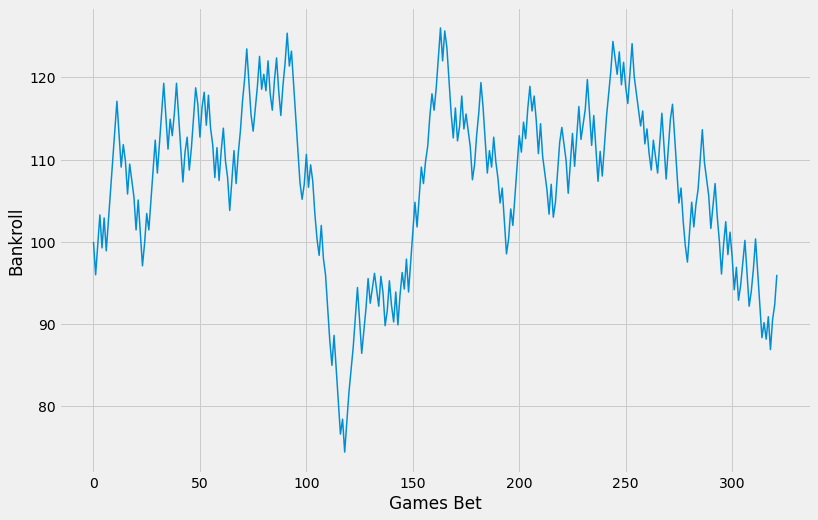

min balance: 74.45454545454565 
max balance: 126.0000000000003 
final balance: 99.63636363636411 
win percentage 51.239999999999995 
profit: -0.36363636363637397 risk: 1079.0 
ROI: -0.03
1
test set 1: 2017-01-21T00:00:00.000000000 - 2017-06-12T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 199 epochs took 4 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished


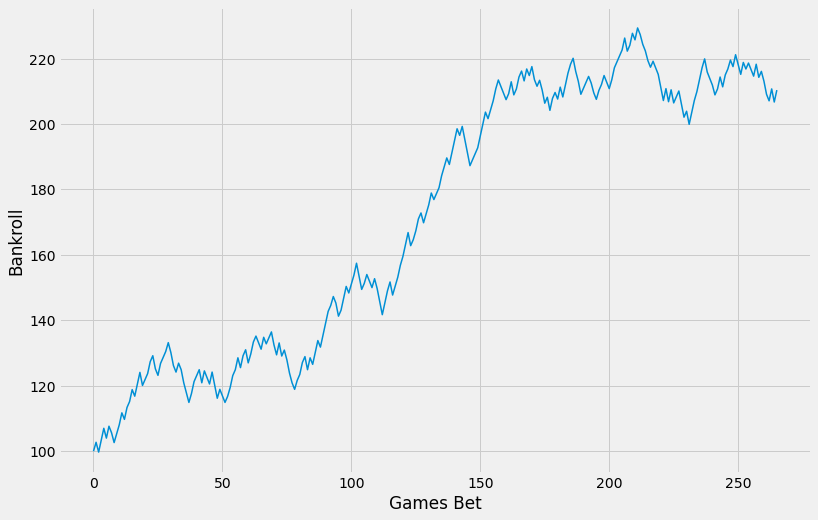

min balance: 99.72727272727273 
max balance: 229.36363636363566 
final balance: 206.36363636363546 
win percentage 57.89 
profit: 106.36363636363632 risk: 810.0 
ROI: 13.13
2
test set 1: 2017-10-20T00:00:00.000000000 - 2018-01-17T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 201 epochs took 4 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


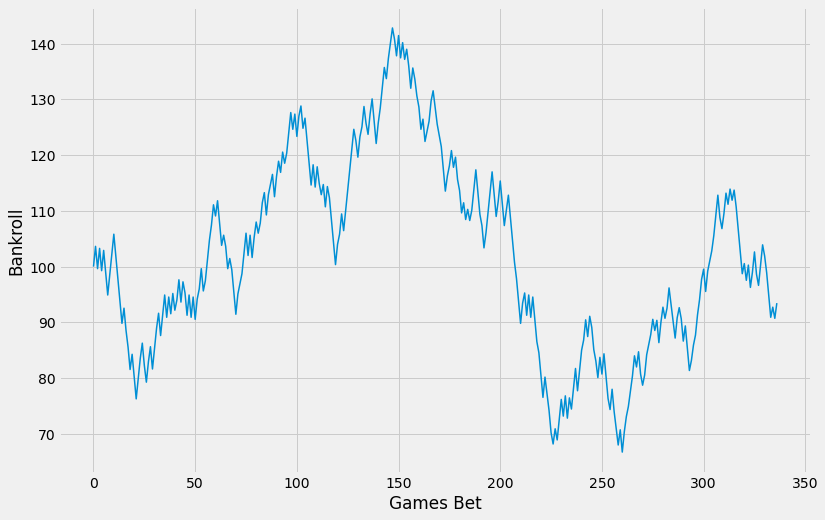

min balance: 66.7272727272729 
max balance: 142.81818181818196 
final balance: 97.09090909090935 
win percentage 52.52 
profit: -2.9090909090909918 risk: 1114.0 
ROI: -0.26
3
test set 1: 2018-01-17T00:00:00.000000000 - 2018-06-08T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 197 epochs took 4 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


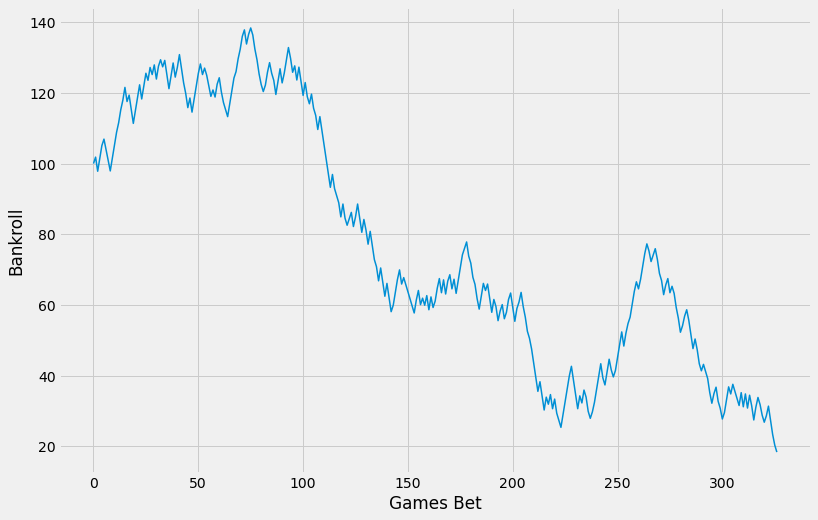

min balance: 18.363636363636406 
max balance: 138.3636363636364 
final balance: 20.181818181818223 
win percentage 48.32 
profit: -79.81818181818187 risk: 1063.0 
ROI: -7.51
4
test set 1: 2018-10-19T00:00:00.000000000 - 2019-01-15T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 194 epochs took 3 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


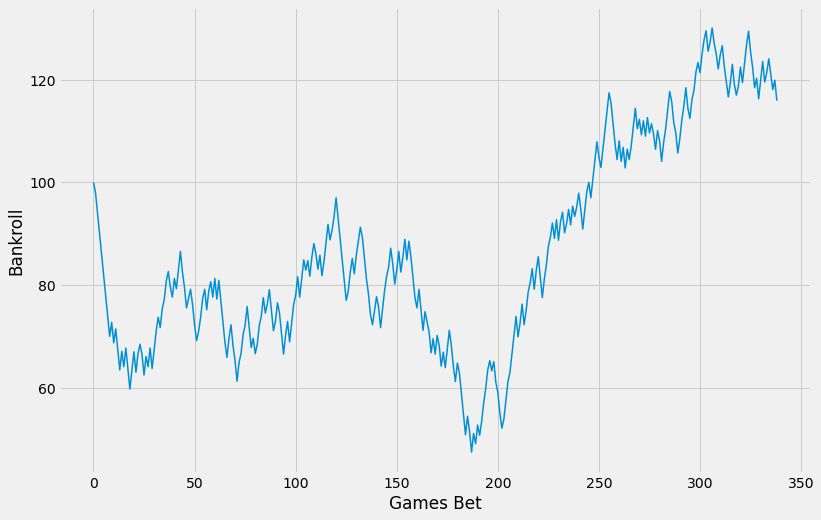

min balance: 47.45454545454566 
max balance: 130.09090909090943 
final balance: 119.5454545454549 
win percentage 53.39 
profit: 19.545454545454504 risk: 1124.0 
ROI: 1.7399999999999998
5
test set 1: 2019-01-16T00:00:00.000000000 - 2019-06-13T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 189 epochs took 4 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


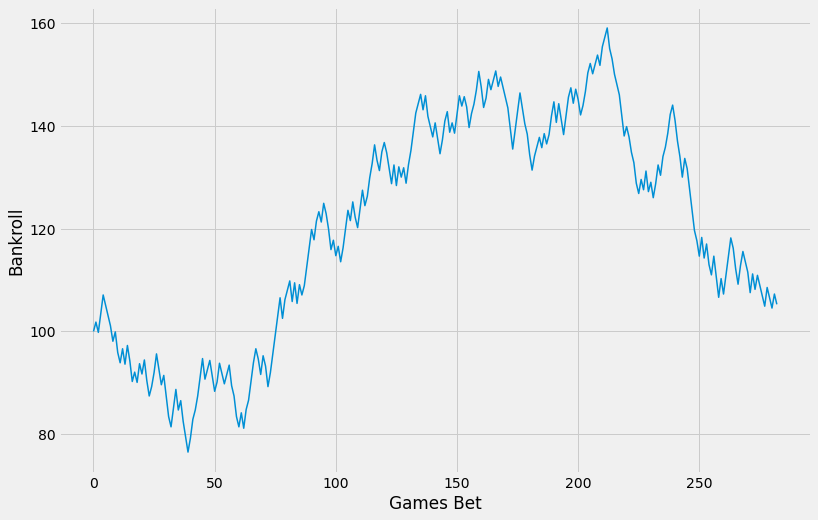

min balance: 76.54545454545456 
max balance: 158.99999999999966 
final balance: 103.2727272727269 
win percentage 50.18 
profit: 3.272727272727252 risk: 852.0 
ROI: 0.38
6
test set 1: 2019-10-25T00:00:00.000000000 - 2020-01-10T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 189 epochs took 5 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished


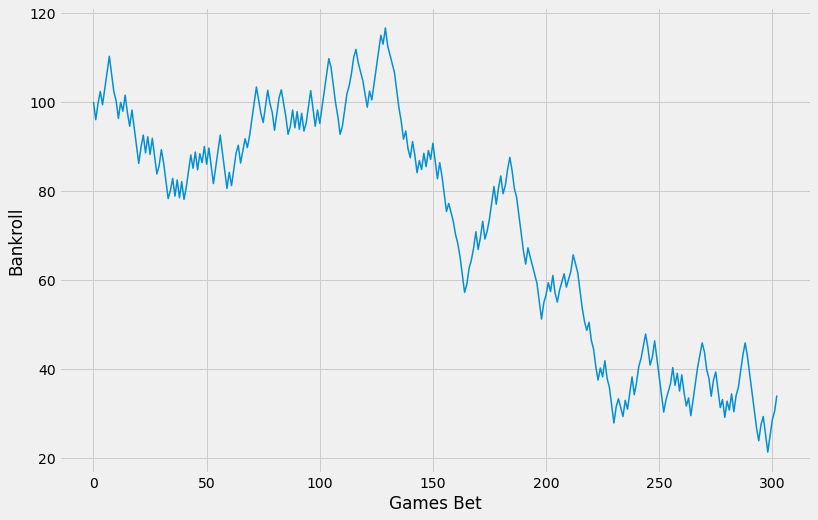

min balance: 21.272727272727487 
max balance: 116.63636363636384 
final balance: 30.000000000000213 
win percentage 48.18 
profit: -70.00000000000006 risk: 1015.0 
ROI: -6.9
7
test set 1: 2020-01-10T00:00:00.000000000 - 2020-10-11T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 181 epochs took 4 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


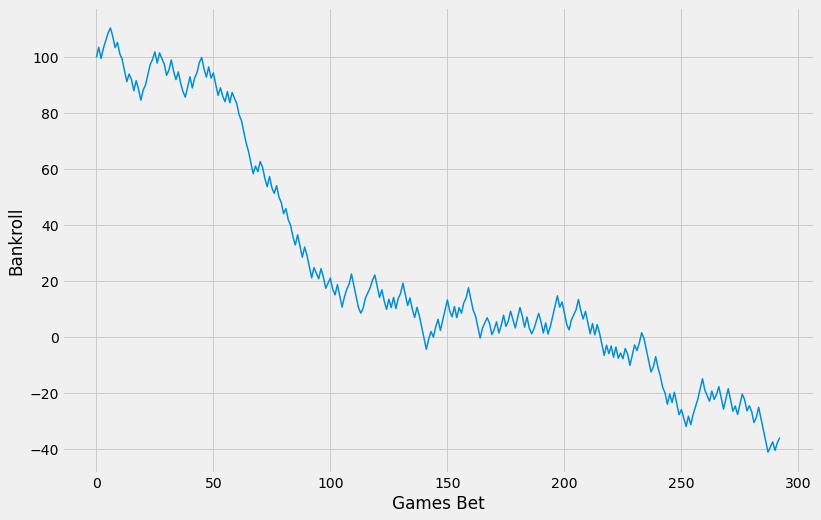

min balance: -40.99999999999997 
max balance: 110.54545454545456 
final balance: -33.999999999999964 
win percentage 46.08 
profit: -134.00000000000006 risk: 974.0 
ROI: -13.76
8
test set 1: 2020-12-25T00:00:00.000000000 - 2021-03-16T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 181 epochs took 4 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


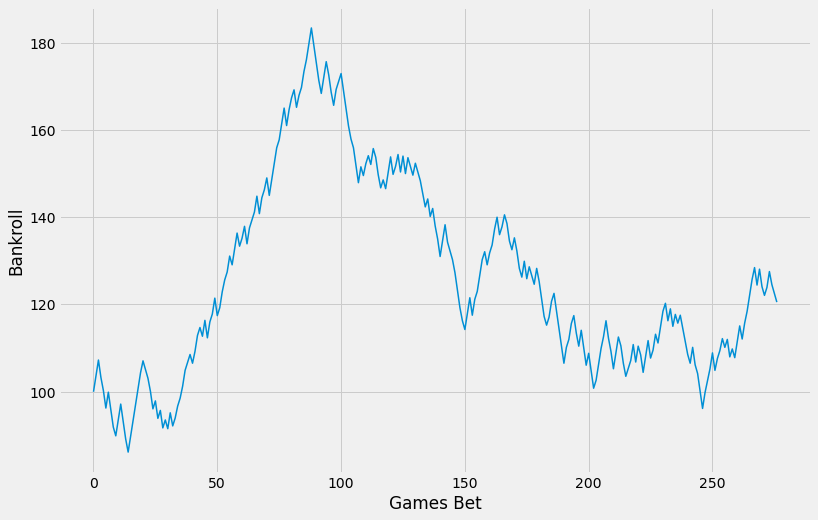

min balance: 86.1818181818182 
max balance: 183.36363636363618 
final balance: 116.54545454545418 
win percentage 53.43 
profit: 16.545454545454504 risk: 896.0 
ROI: 1.8499999999999999
9
test set 1: 2021-03-16T00:00:00.000000000 - 2021-07-20T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 175 epochs took 4 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


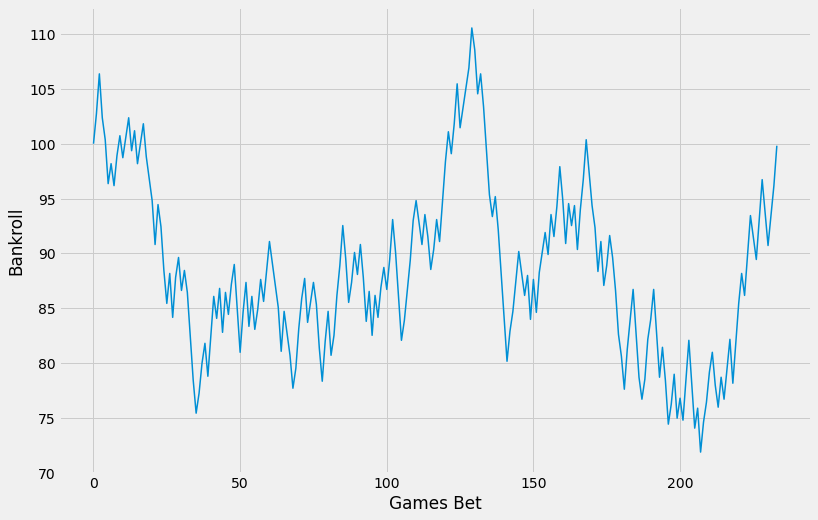

min balance: 71.90909090909106 
max balance: 110.54545454545465 
final balance: 102.54545454545477 
win percentage 52.99 
profit: 2.545454545454504 risk: 700.0 
ROI: 0.36
10
test set 1: 2021-10-22T00:00:00.000000000 - 2021-10-27T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 242 epochs took 6 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished


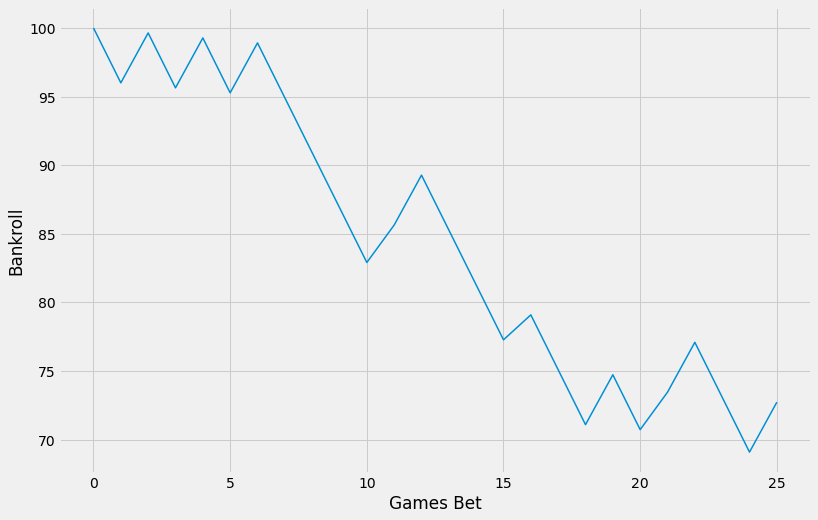

min balance: 69.09090909090912 
max balance: 99.63636363636364 
final balance: 76.3636363636364 
win percentage 42.309999999999995 
profit: -23.63636363636364 risk: 100.0 
ROI: -23.64
11
test set 1: 2021-10-27T00:00:00.000000000 - 2021-11-03T00:00:00.000000000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 240 epochs took 6 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


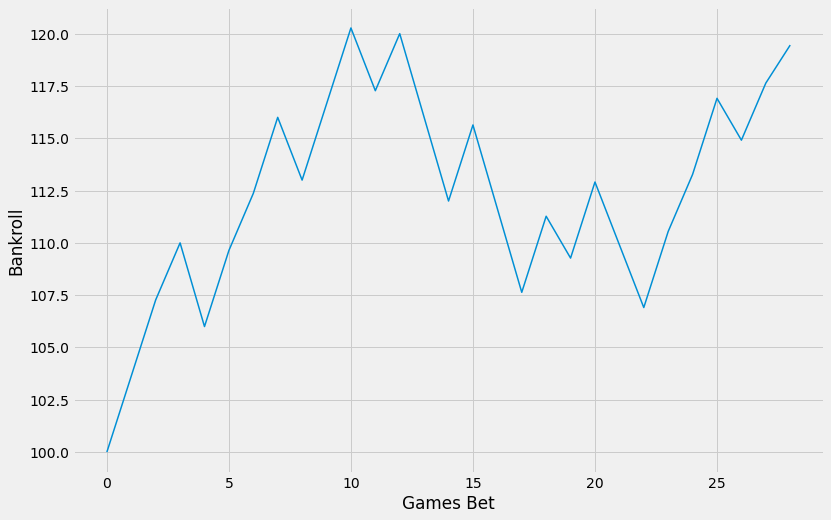

min balance: 103.63636363636364 
max balance: 120.27272727272731 
final balance: 115.45454545454552 
win percentage 58.620000000000005 
profit: 15.454545454545453 risk: 101.0 
ROI: 15.299999999999999

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['RECORD_team_diff',
                                                   'FG2M_team_diff',
                                                   'FG2A_team_diff',
                                                   'STL_team_diff',
                                                   'TOV_team_diff',
                                                   'E_OFF_RATING_team_diff',
                                                   'E_NET_RATING_team_diff',
                                                   'PIE_team_diff',
                                                   'AST_2PM_team_diff',
                                                   'U

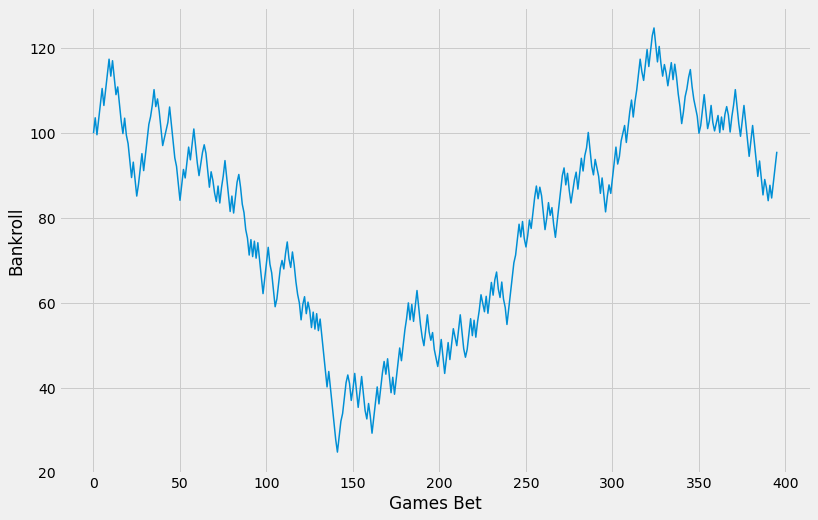

min balance: 24.818181818181948 
max balance: 124.81818181818197 
final balance: 99.27272727272751 
win percentage 51.519999999999996 
profit: -0.7272727272727479 risk: 1381.0 
ROI: -0.05
1
test set 1: 2017-01-21T00:00:00.000000000 - 2017-06-12T00:00:00.000000000


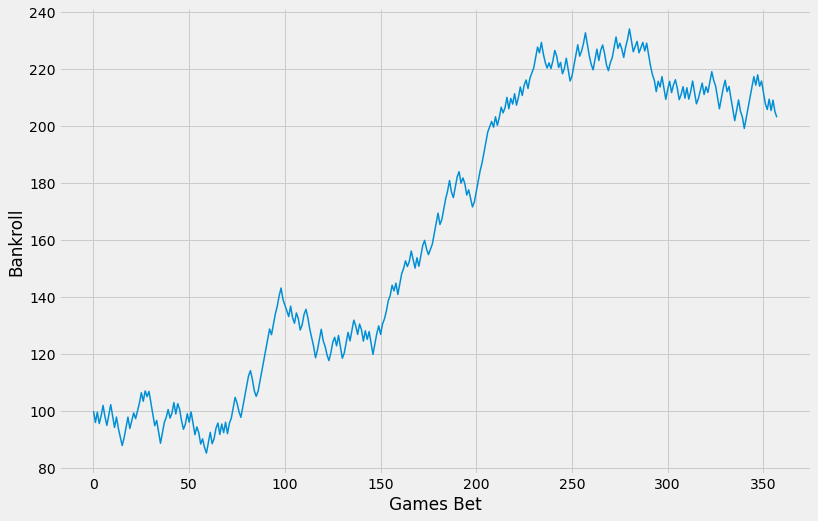

min balance: 85.27272727272735 
max balance: 234.0909090909084 
final balance: 205.81818181818082 
win percentage 56.42 
profit: 105.81818181818176 risk: 1179.0 
ROI: 8.98
2
test set 1: 2017-10-20T00:00:00.000000000 - 2018-01-17T00:00:00.000000000


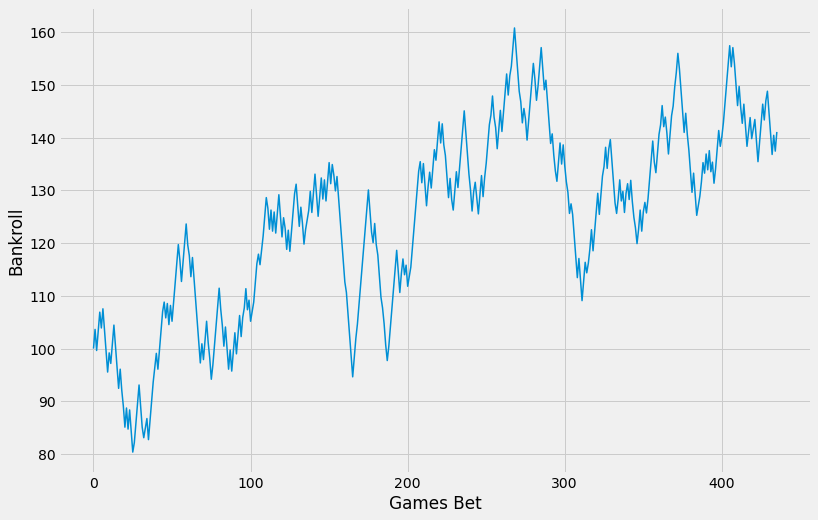

min balance: 80.3636363636364 
max balance: 160.8181818181816 
final balance: 144.72727272727192 
win percentage 53.900000000000006 
profit: 44.727272727272634 risk: 1557.0 
ROI: 2.87
3
test set 1: 2018-01-17T00:00:00.000000000 - 2018-06-08T00:00:00.000000000


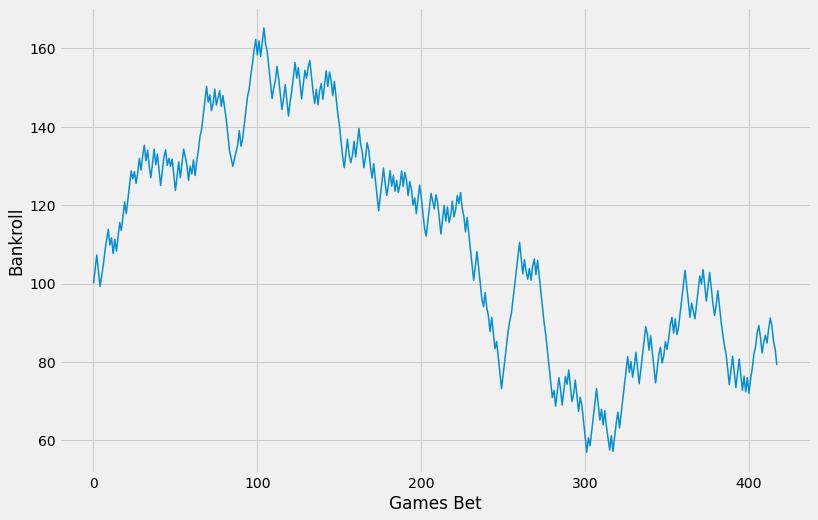

min balance: 56.9999999999995 
max balance: 165.18181818181785 
final balance: 76.18181818181786 
win percentage 51.44 
profit: -23.81818181818187 risk: 1469.0 
ROI: -1.6199999999999999
4
test set 1: 2018-10-19T00:00:00.000000000 - 2019-01-15T00:00:00.000000000


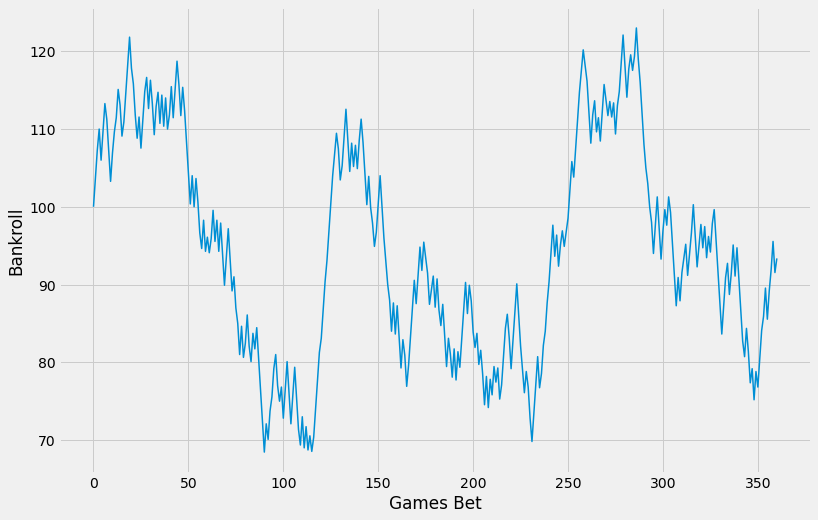

min balance: 68.45454545454555 
max balance: 123.00000000000031 
final balance: 95.18181818181858 
win percentage 52.080000000000005 
profit: -4.81818181818187 risk: 1219.0 
ROI: -0.4
5
test set 1: 2019-01-16T00:00:00.000000000 - 2019-06-13T00:00:00.000000000


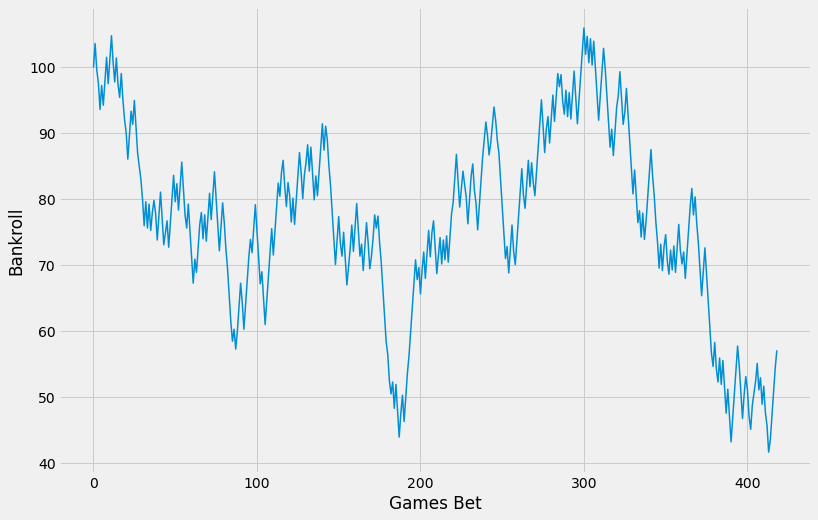

min balance: 41.636363636364095 
max balance: 106.00000000000038 
final balance: 55.09090909090954 
win percentage 50.36000000000001 
profit: -44.90909090909099 risk: 1492.0 
ROI: -3.01
6
test set 1: 2019-10-25T00:00:00.000000000 - 2020-01-10T00:00:00.000000000


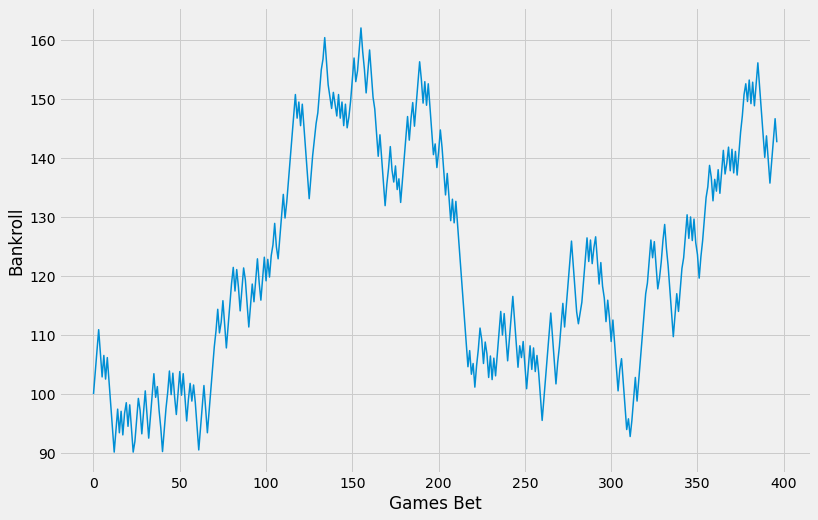

min balance: 90.1818181818182 
max balance: 161.99999999999994 
final balance: 145.36363636363603 
win percentage 54.410000000000004 
profit: 45.36363636363626 risk: 1459.0 
ROI: 3.11
7
test set 1: 2020-01-10T00:00:00.000000000 - 2020-10-11T00:00:00.000000000


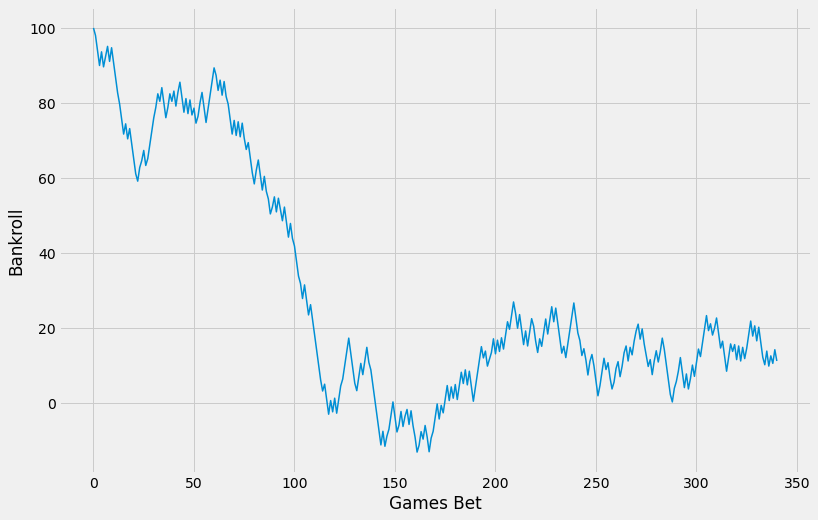

min balance: -12.99999999999989 
max balance: 98.0 
final balance: 14.00000000000011 
win percentage 49.27 
profit: -86.0 risk: 1199.0 
ROI: -7.17
8
test set 1: 2020-12-25T00:00:00.000000000 - 2021-03-16T00:00:00.000000000


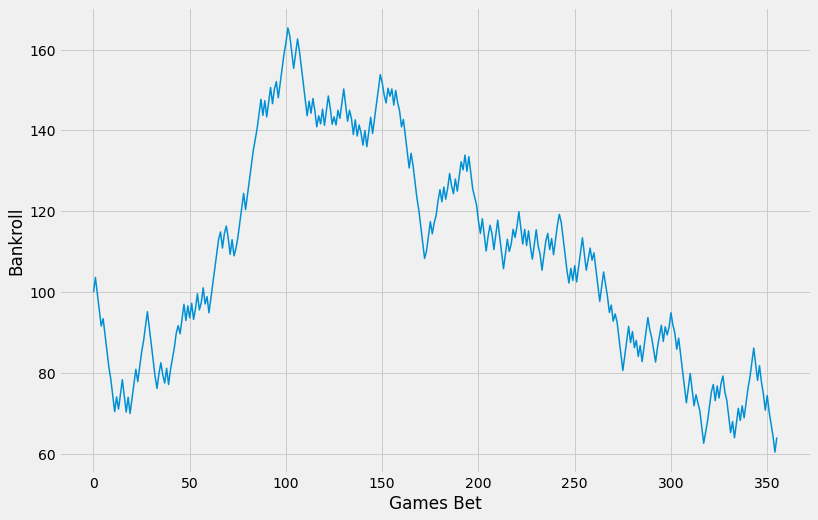

min balance: 60.090909090909065 
max balance: 165.36363636363635 
final balance: 60.090909090909065 
win percentage 50.0 
profit: -39.90909090909099 risk: 1256.0 
ROI: -3.18
9
test set 1: 2021-03-16T00:00:00.000000000 - 2021-07-20T00:00:00.000000000


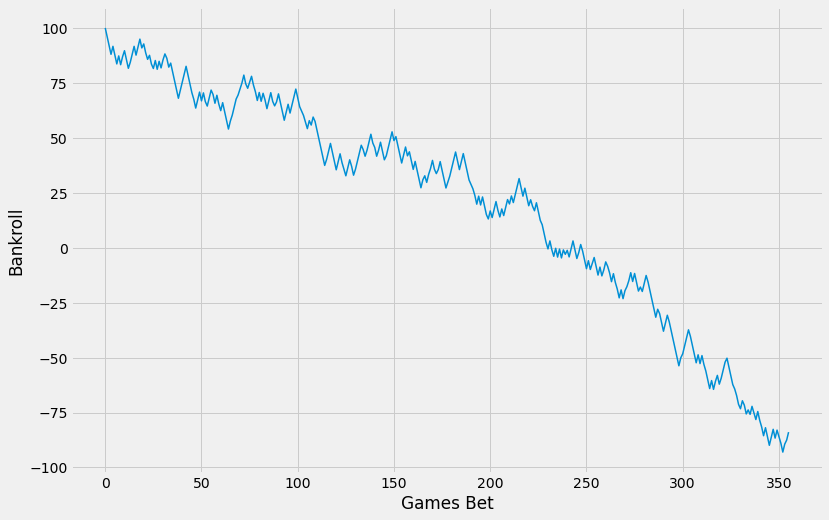

min balance: -92.99999999999997 
max balance: 96.0 
final balance: -82.09090909090907 
win percentage 44.379999999999995 
profit: -182.09090909090912 risk: 1276.0 
ROI: -14.27
10
test set 1: 2021-10-22T00:00:00.000000000 - 2021-10-27T00:00:00.000000000


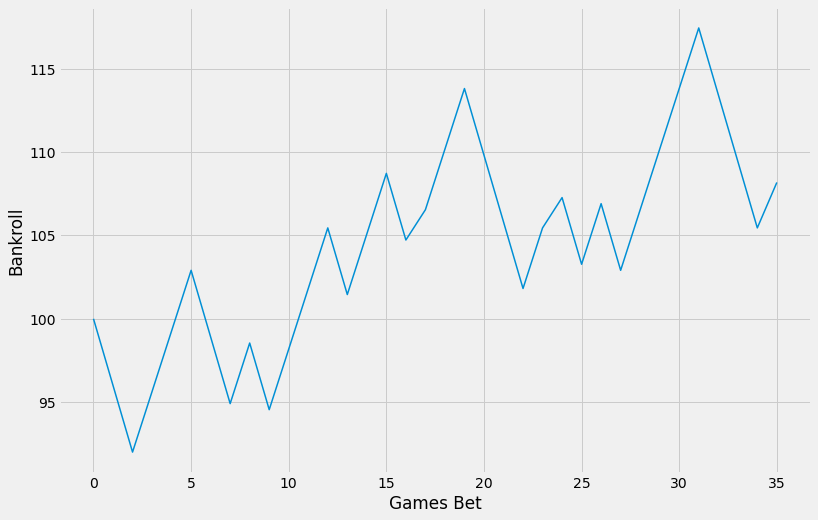

min balance: 92.0 
max balance: 117.45454545454551 
final balance: 111.81818181818188 
win percentage 58.330000000000005 
profit: 11.818181818181813 risk: 139.0 
ROI: 8.5
11
test set 1: 2021-10-27T00:00:00.000000000 - 2021-11-03T00:00:00.000000000


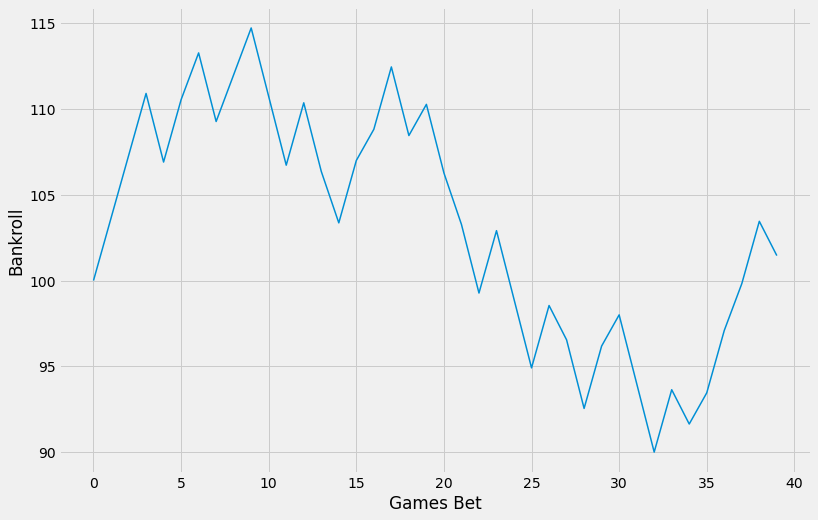

min balance: 90.00000000000004 
max balance: 114.72727272727276 
final balance: 97.45454545454551 
win percentage 52.5 
profit: -2.5454545454545467 risk: 140.0 
ROI: -1.82

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['RECORD_team_diff',
                                                   'FG2M_team_diff',
                                                   'FG2A_team_diff',
                                                   'FG3A_team_diff',
                                                   'FTM_team_diff',
                                                   'FTA_team_diff',
                                                   'OREB_team_diff',
                                                   'REB_team_diff',
                                                   'AST_team_diff',
                                                   'STL_team_diff',
                                 

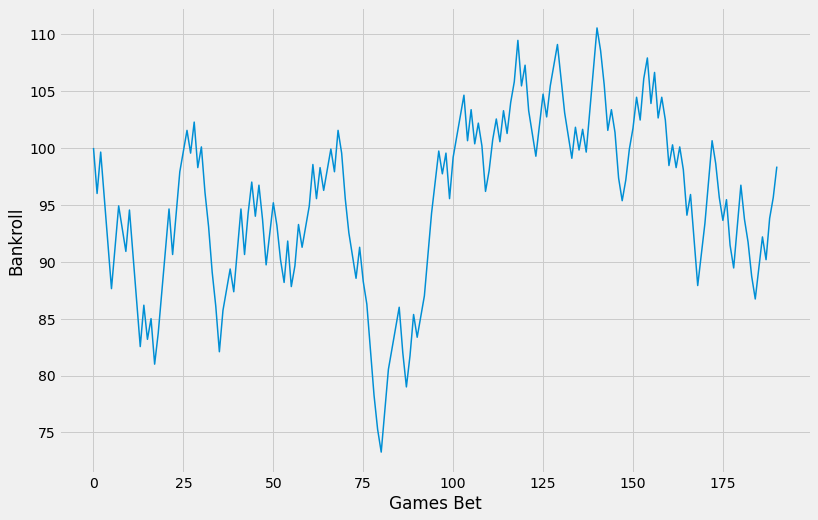

min balance: 73.27272727272734 
max balance: 110.54545454545463 
final balance: 100.18181818181829 
win percentage 52.35999999999999 
profit: 0.18181818181818699 risk: 563.0 
ROI: 0.03
1
test set 1: 2017-01-21T00:00:00.000000000 - 2017-06-12T00:00:00.000000000


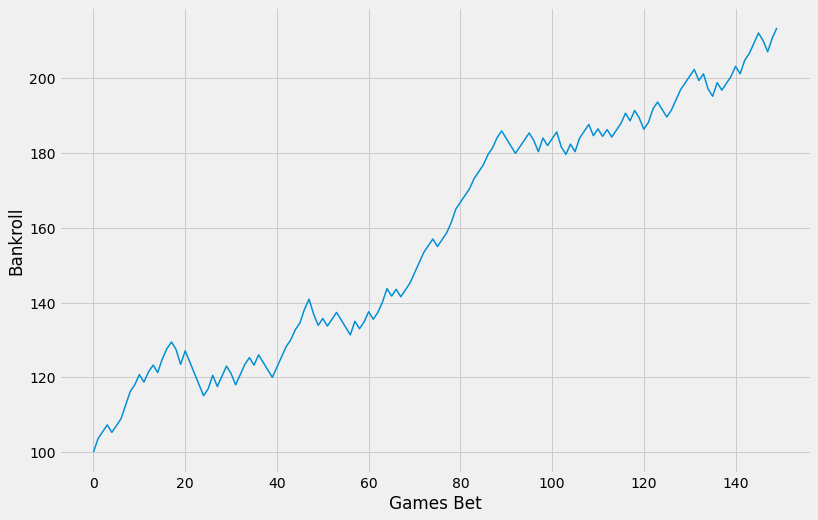

min balance: 103.63636363636364 
max balance: 213.45454545454504 
final balance: 210.45454545454504 
win percentage 65.33 
profit: 110.45454545454544 risk: 384.0 
ROI: 28.76
2
test set 1: 2017-10-20T00:00:00.000000000 - 2018-01-17T00:00:00.000000000


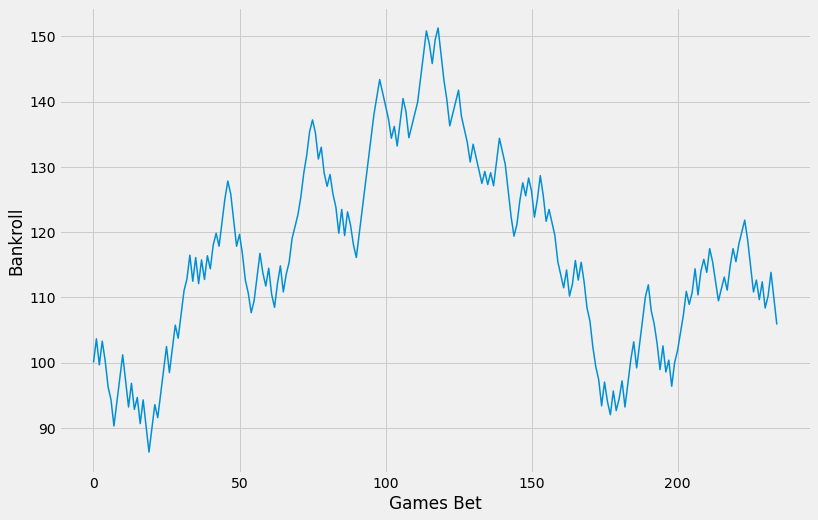

min balance: 86.2727272727273 
max balance: 151.27272727272722 
final balance: 107.63636363636358 
win percentage 51.49 
profit: 7.636363636363626 risk: 735.0 
ROI: 1.04
3
test set 1: 2018-01-17T00:00:00.000000000 - 2018-06-08T00:00:00.000000000


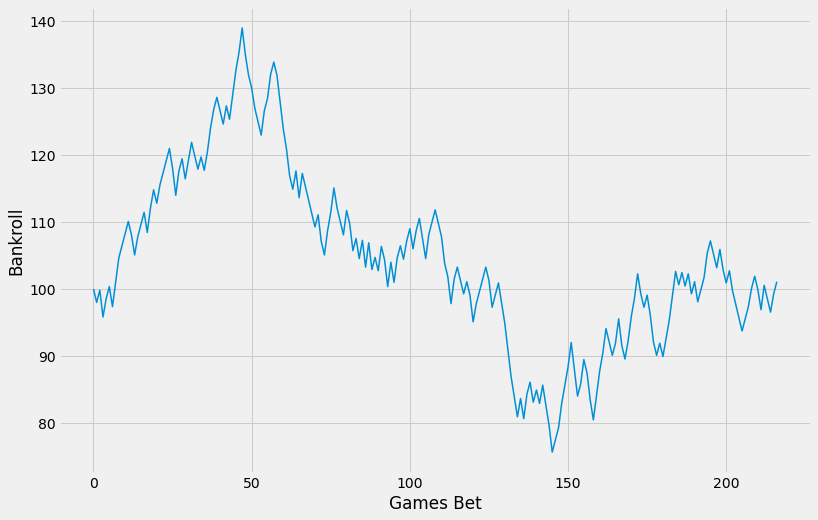

min balance: 75.63636363636364 
max balance: 139.0 
final balance: 99.09090909090912 
win percentage 51.15 
profit: -0.9090909090909349 risk: 608.0 
ROI: -0.15
4
test set 1: 2018-10-19T00:00:00.000000000 - 2019-01-15T00:00:00.000000000


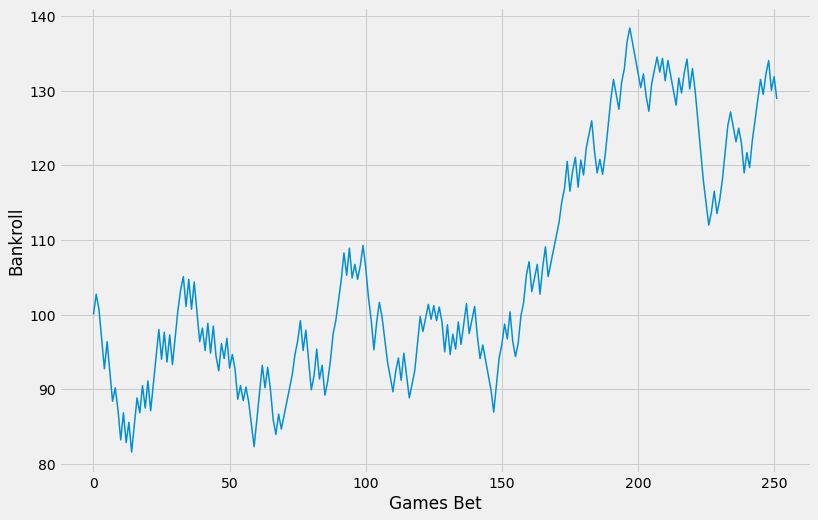

min balance: 81.54545454545456 
max balance: 138.4545454545455 
final balance: 130.7272727272727 
win percentage 55.16 
profit: 30.72727272727269 risk: 752.0 
ROI: 4.09
5
test set 1: 2019-01-16T00:00:00.000000000 - 2019-06-13T00:00:00.000000000


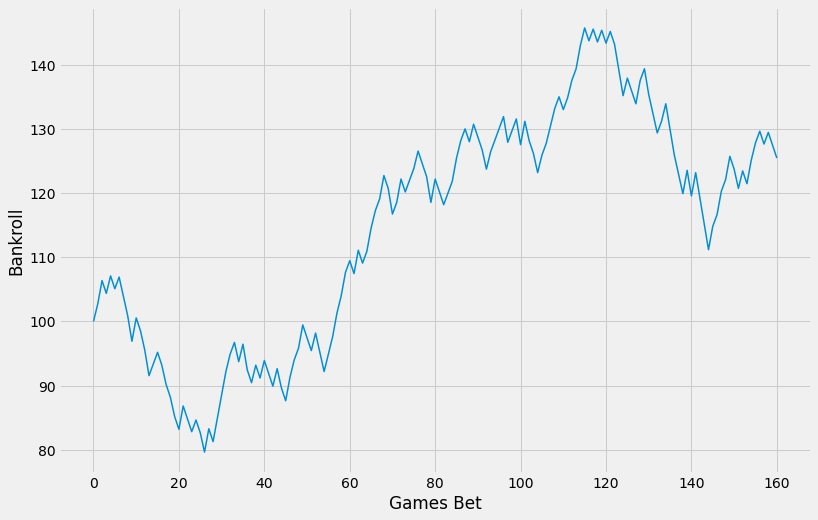

min balance: 79.63636363636364 
max balance: 145.72727272727275 
final balance: 123.45454545454544 
win percentage 52.800000000000004 
profit: 23.45454545454544 risk: 450.0 
ROI: 5.21
6
test set 1: 2019-10-25T00:00:00.000000000 - 2020-01-10T00:00:00.000000000


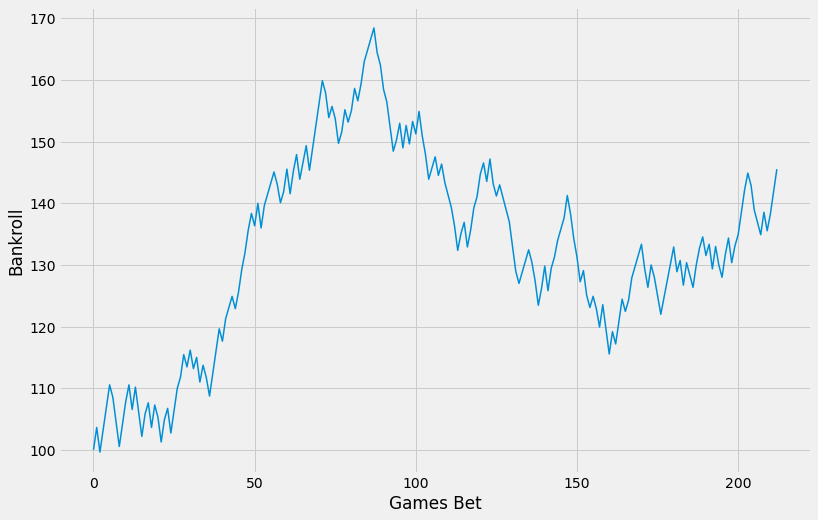

min balance: 99.63636363636364 
max balance: 168.4545454545453 
final balance: 141.54545454545405 
win percentage 55.400000000000006 
profit: 41.545454545454504 risk: 661.0 
ROI: 6.29
7
test set 1: 2020-01-10T00:00:00.000000000 - 2020-10-11T00:00:00.000000000


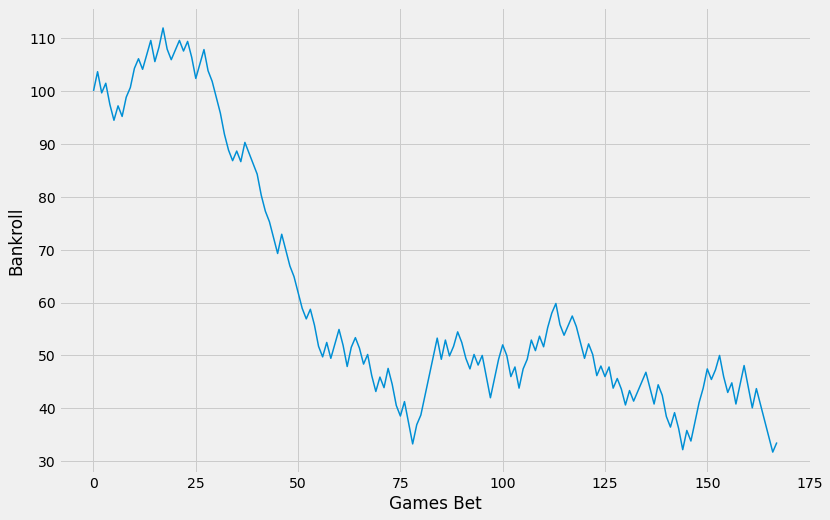

min balance: 31.727272727272712 
max balance: 111.90909090909093 
final balance: 35.36363636363635 
win percentage 45.24 
profit: -64.63636363636365 risk: 498.0 
ROI: -12.98
8
test set 1: 2020-12-25T00:00:00.000000000 - 2021-03-16T00:00:00.000000000


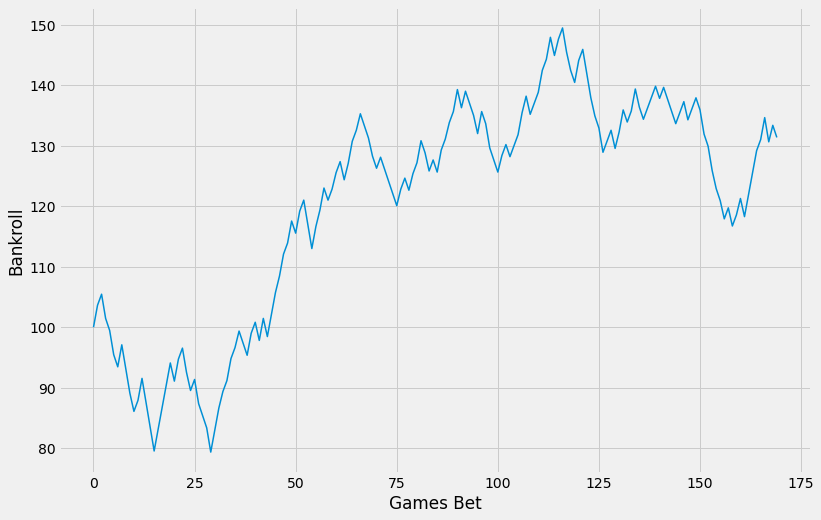

min balance: 79.36363636363637 
max balance: 149.45454545454533 
final balance: 129.36363636363612 
win percentage 54.120000000000005 
profit: 29.363636363636346 risk: 488.0 
ROI: 6.02
9
test set 1: 2021-03-16T00:00:00.000000000 - 2021-07-20T00:00:00.000000000


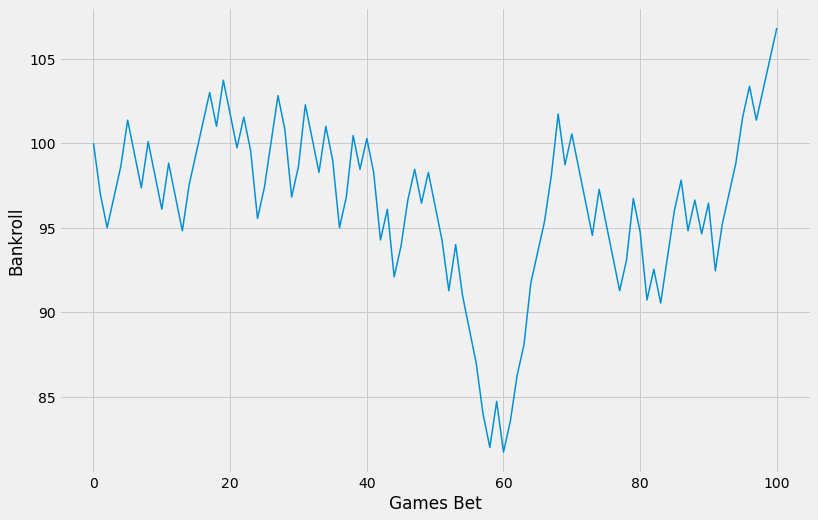

min balance: 81.72727272727273 
max balance: 108.63636363636361 
final balance: 108.63636363636361 
win percentage 53.47 
profit: 8.636363636363626 risk: 251.0 
ROI: 3.44
10
test set 1: 2021-10-22T00:00:00.000000000 - 2021-10-27T00:00:00.000000000


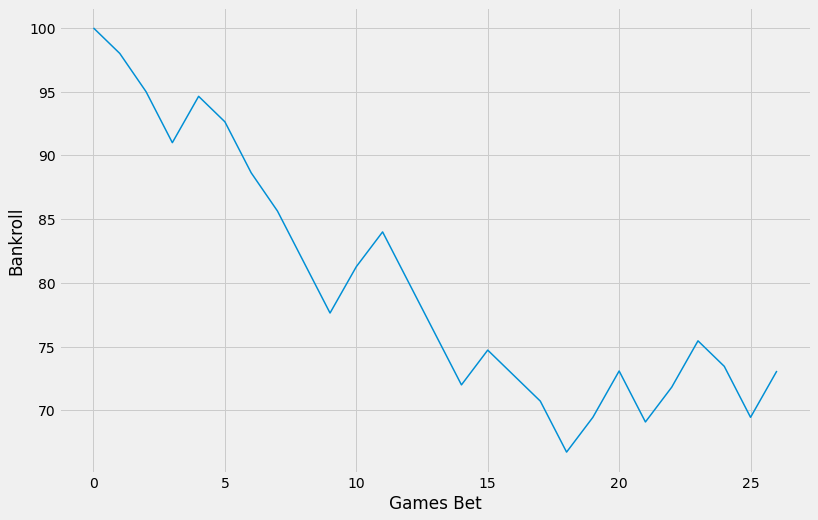

min balance: 66.72727272727275 
max balance: 98.0 
final balance: 74.90909090909095 
win percentage 37.04 
profit: -25.090909090909093 risk: 90.0 
ROI: -27.88
11
test set 1: 2021-10-27T00:00:00.000000000 - 2021-11-03T00:00:00.000000000


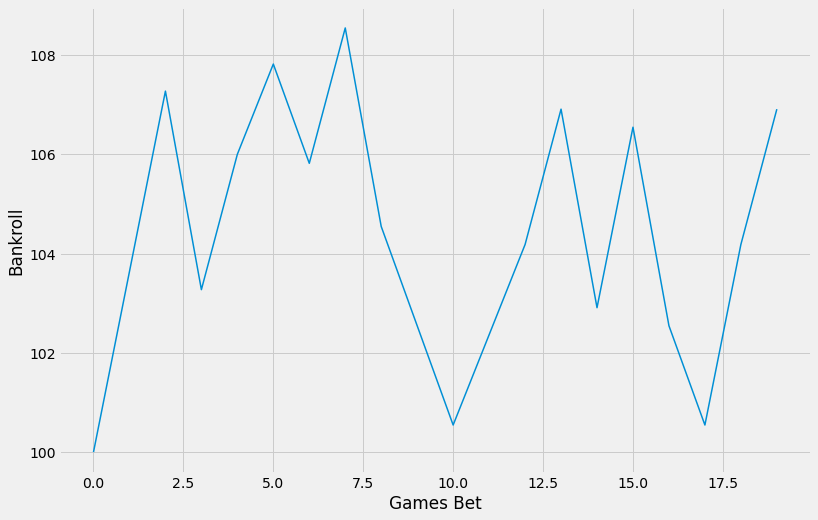

min balance: 100.54545454545456 
max balance: 108.54545454545456 
final balance: 104.90909090909093 
win percentage 55.00000000000001 
profit: 4.9090909090909065 risk: 60.0 
ROI: 8.18

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['RECORD_team_diff',
                                                   'FG2M_team_diff',
                                                   'FG2A_team_diff',
                                                   'FG3A_team_diff',
                                                   'FTM_team_diff',
                                                   'FTA_team_diff',
                                                   'OREB_team_diff',
                                                   'DREB_team_diff',
                                                   'STL_team_diff',
                                                   'E_OFF_RATING_team_diff',
           

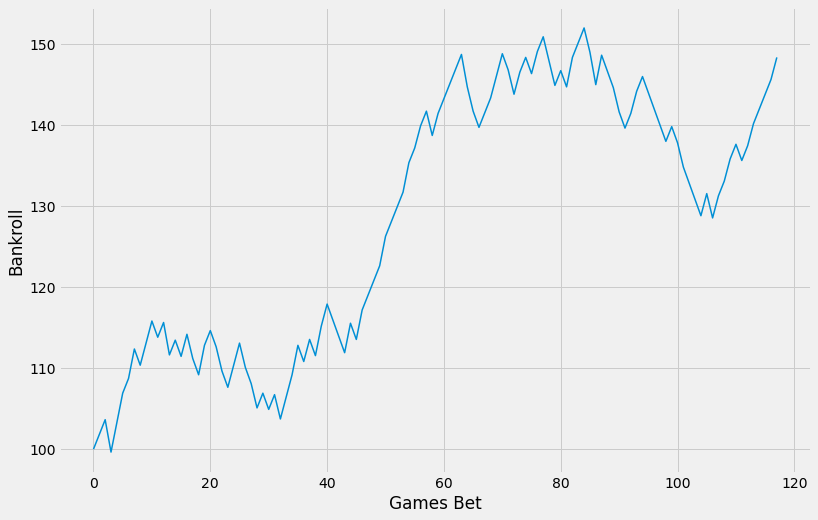

min balance: 99.63636363636363 
max balance: 151.9999999999999 
final balance: 151.09090909090887 
win percentage 59.31999999999999 
profit: 51.090909090909065 risk: 304.0 
ROI: 16.81
1
test set 1: 2017-01-21T00:00:00.000000000 - 2017-06-12T00:00:00.000000000


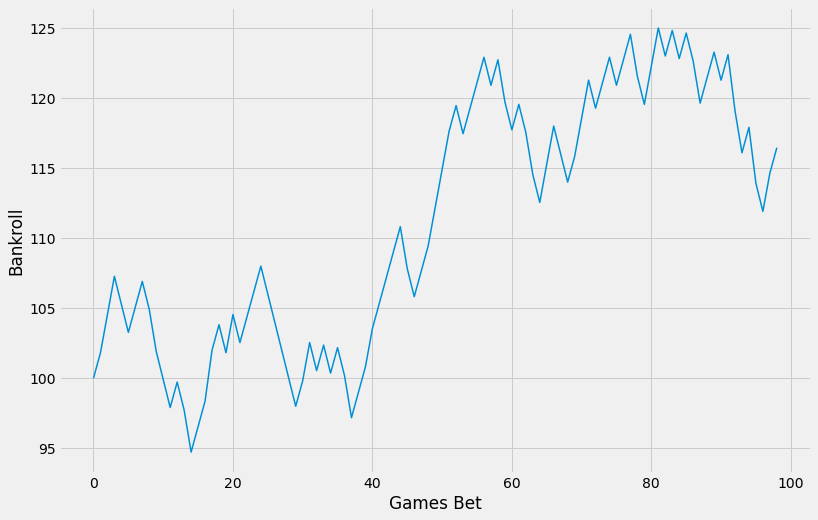

min balance: 94.72727272727272 
max balance: 124.99999999999993 
final balance: 118.27272727272717 
win percentage 56.57 
profit: 18.272727272727266 risk: 228.0 
ROI: 8.01
2
test set 1: 2017-10-20T00:00:00.000000000 - 2018-01-17T00:00:00.000000000


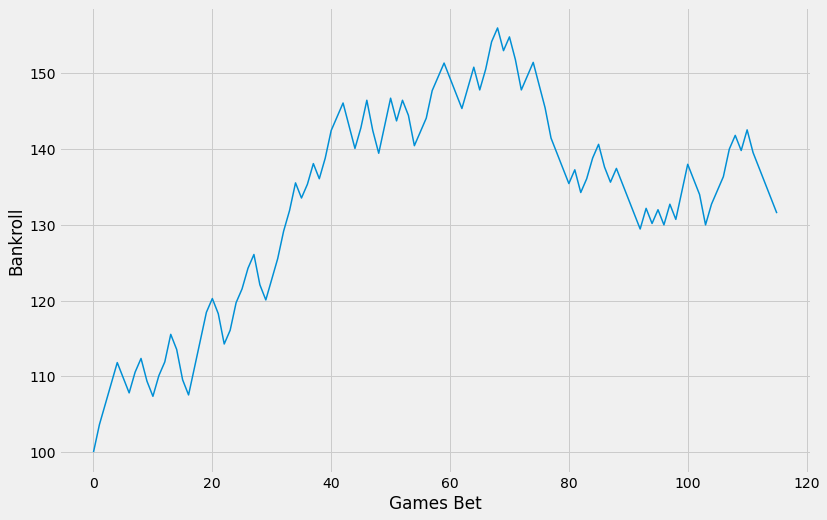

min balance: 103.63636363636364 
max balance: 155.99999999999986 
final balance: 133.3636363636361 
win percentage 55.169999999999995 
profit: 33.363636363636346 risk: 316.0 
ROI: 10.56
3
test set 1: 2018-01-17T00:00:00.000000000 - 2018-06-08T00:00:00.000000000


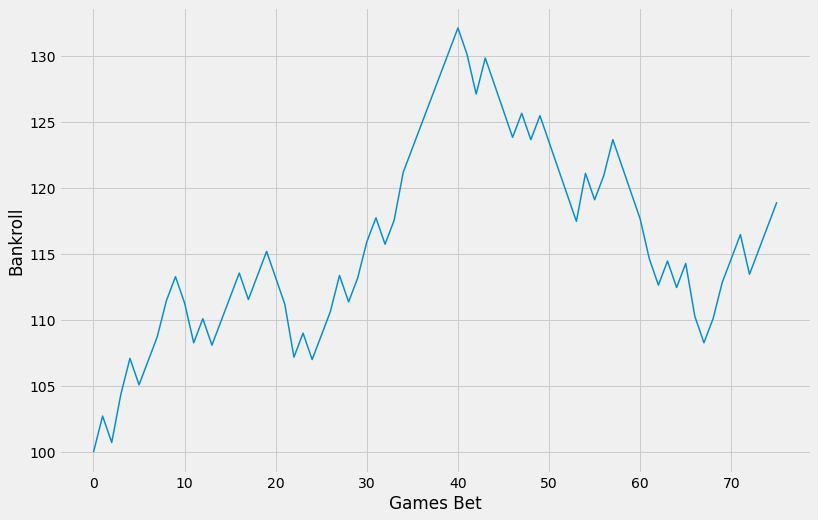

min balance: 100.72727272727273 
max balance: 132.09090909090904 
final balance: 116.9090909090908 
win percentage 56.58 
profit: 16.909090909090907 risk: 174.0 
ROI: 9.719999999999999
4
test set 1: 2018-10-19T00:00:00.000000000 - 2019-01-15T00:00:00.000000000


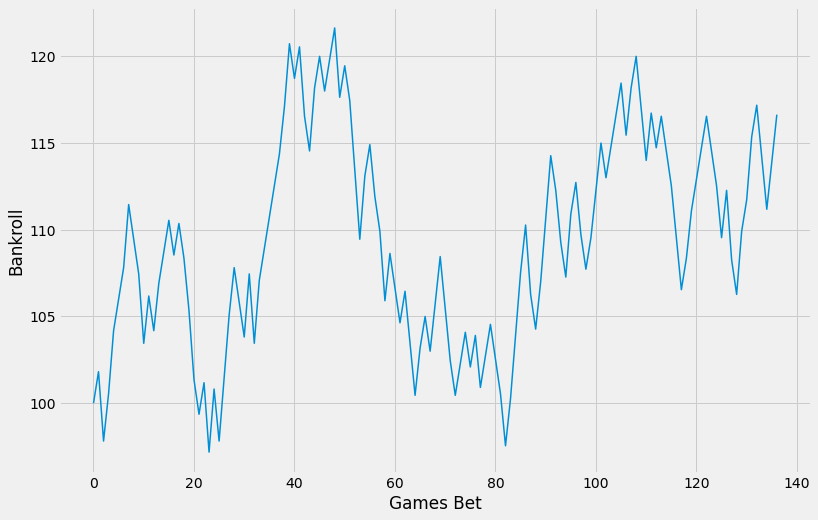

min balance: 97.18181818181817 
max balance: 121.63636363636363 
final balance: 118.45454545454545 
win percentage 54.74 
profit: 18.45454545454544 risk: 371.0 
ROI: 4.97
5
test set 1: 2019-01-16T00:00:00.000000000 - 2019-06-13T00:00:00.000000000


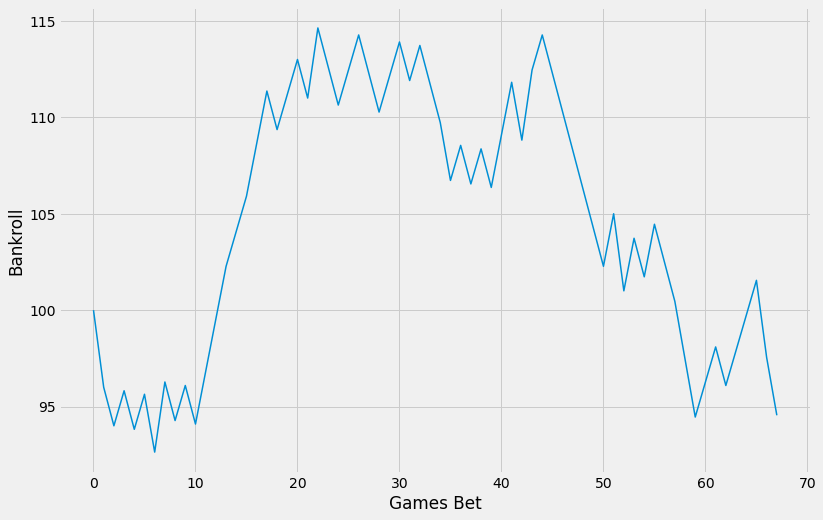

min balance: 92.54545454545452 
max balance: 114.63636363636364 
final balance: 92.54545454545452 
win percentage 48.53 
profit: -7.4545454545454675 risk: 164.0 
ROI: -4.55
6
test set 1: 2019-10-25T00:00:00.000000000 - 2020-01-10T00:00:00.000000000


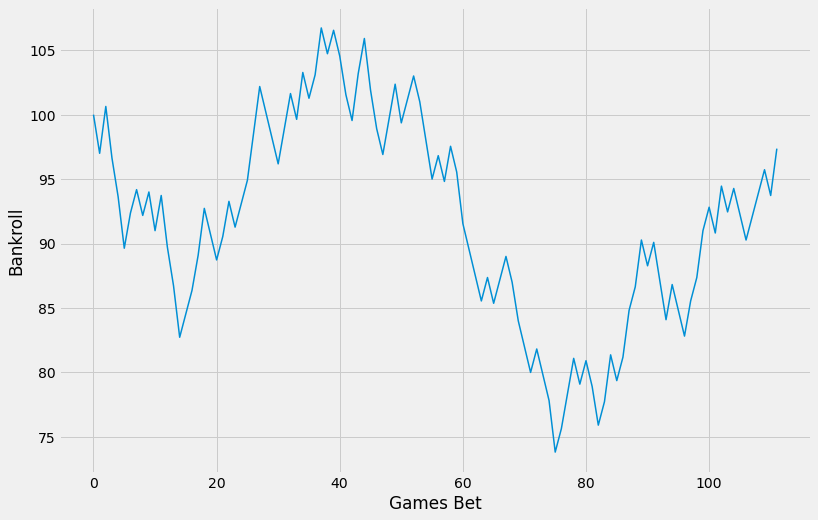

min balance: 73.81818181818183 
max balance: 106.72727272727275 
final balance: 95.36363636363636 
win percentage 49.11 
profit: -4.6363636363636545 risk: 291.0 
ROI: -1.59
7
test set 1: 2020-01-10T00:00:00.000000000 - 2020-10-11T00:00:00.000000000


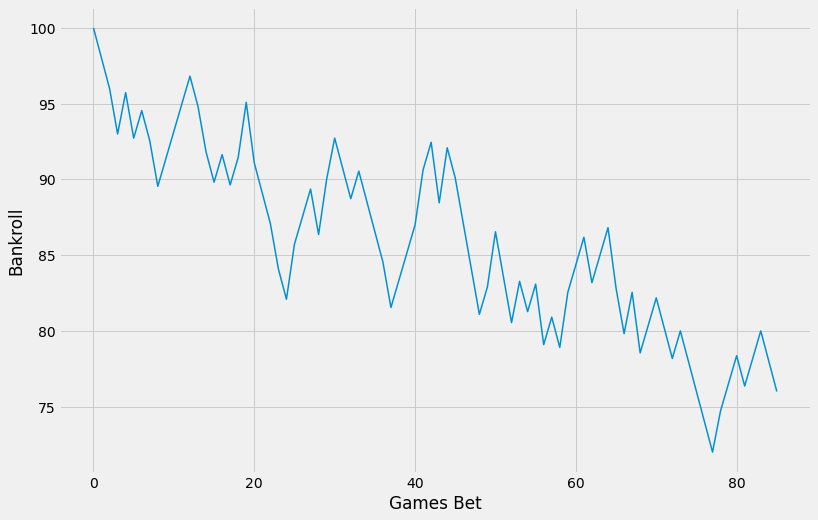

min balance: 71.99999999999993 
max balance: 98.0 
final balance: 77.81818181818173 
win percentage 47.67 
profit: -22.181818181818187 risk: 215.0 
ROI: -10.32
8
test set 1: 2020-12-25T00:00:00.000000000 - 2021-03-16T00:00:00.000000000


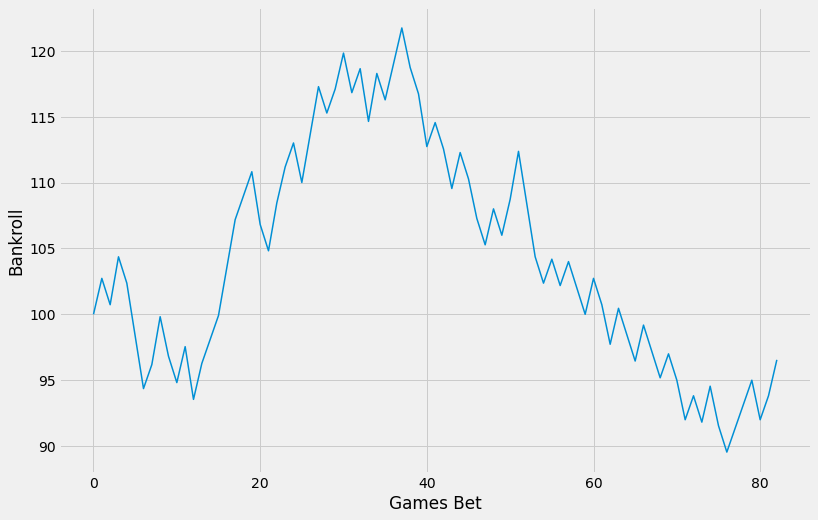

min balance: 89.5454545454546 
max balance: 121.72727272727276 
final balance: 94.54545454545459 
win percentage 49.4 
profit: -5.4545454545454675 risk: 225.0 
ROI: -2.42
9
test set 1: 2021-03-16T00:00:00.000000000 - 2021-07-20T00:00:00.000000000


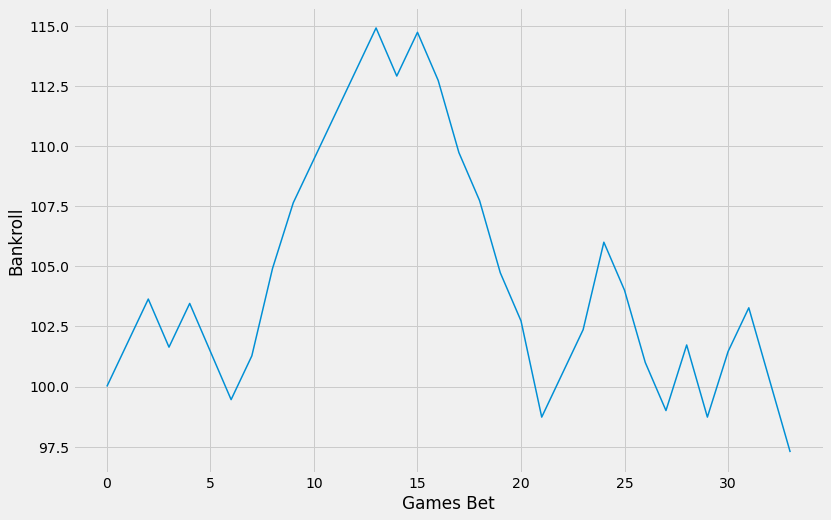

min balance: 95.27272727272724 
max balance: 114.90909090909088 
final balance: 95.27272727272724 
win percentage 50.0 
profit: -4.727272727272734 risk: 83.0 
ROI: -5.7
10
test set 1: 2021-10-22T00:00:00.000000000 - 2021-10-27T00:00:00.000000000


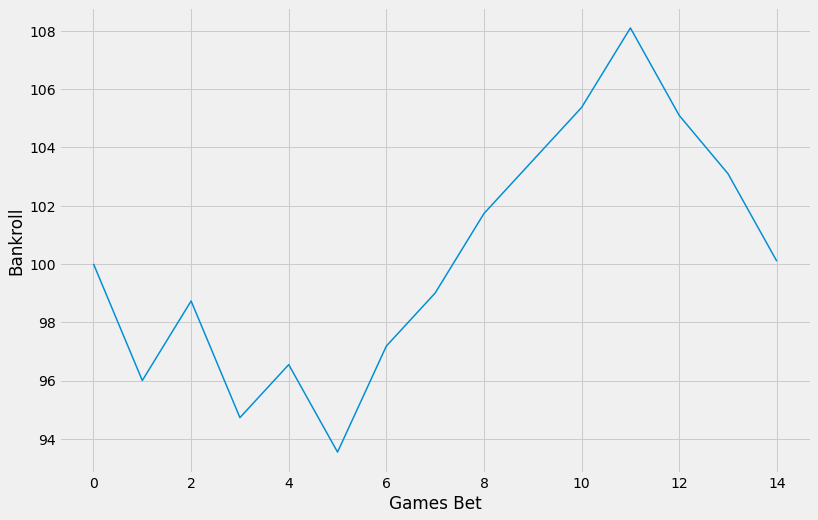

min balance: 93.54545454545455 
max balance: 108.0909090909091 
final balance: 96.0909090909091 
win percentage 53.33 
profit: -3.90909090909091 risk: 44.0 
ROI: -8.88
11
test set 1: 2021-10-27T00:00:00.000000000 - 2021-11-03T00:00:00.000000000


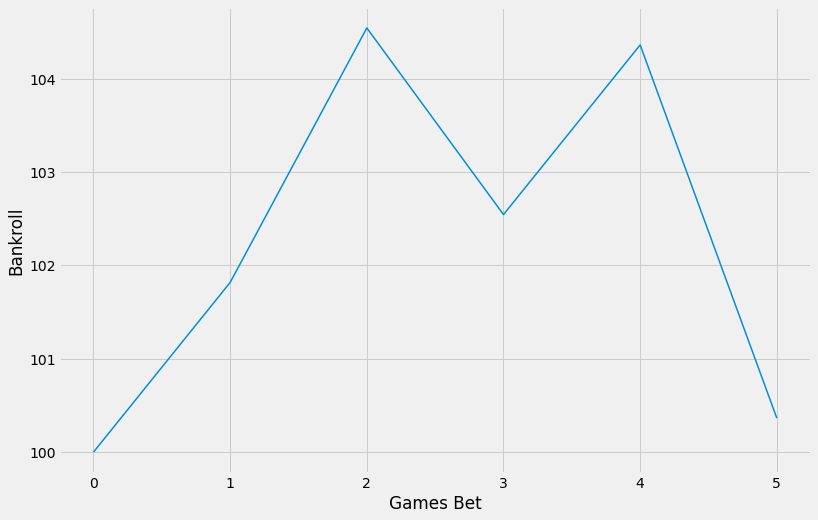

min balance: 98.36363636363636 
max balance: 104.54545454545455 
final balance: 98.36363636363636 
win percentage 50.0 
profit: -1.6363636363636367 risk: 15.0 
ROI: -10.91

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['FG3A_team_diff',
                                                   'FTA_team_diff',
                                                   'E_DEF_RATING_team_diff',
                                                   'PTS_2PT_MR_team_diff',
                                                   'PTS_OFF_TOV_team_diff',
                                                   'RECORD_opp_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'FTA_opp_diff',
                                                   'OREB_opp_diff',
               

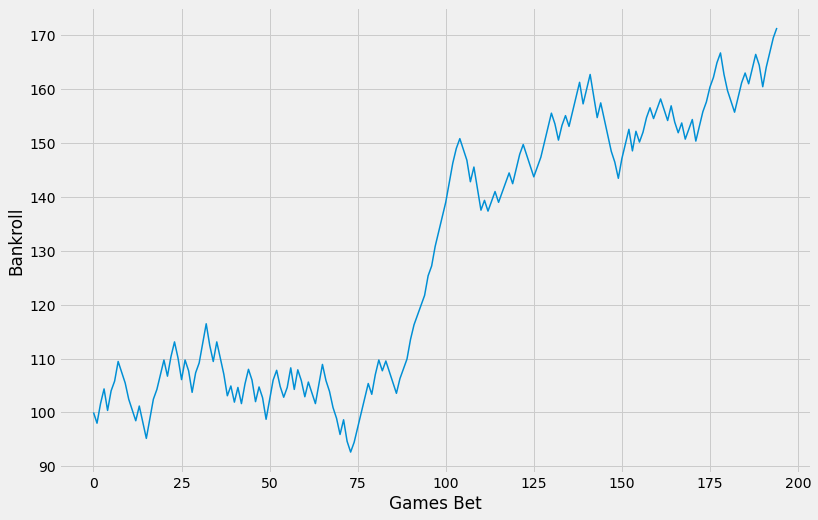

min balance: 92.63636363636374 
max balance: 173.18181818181787 
final balance: 173.18181818181787 
win percentage 57.95 
profit: 73.18181818181813 risk: 553.0 
ROI: 13.23
1
test set 1: 2017-01-21T00:00:00.000000000 - 2017-06-12T00:00:00.000000000


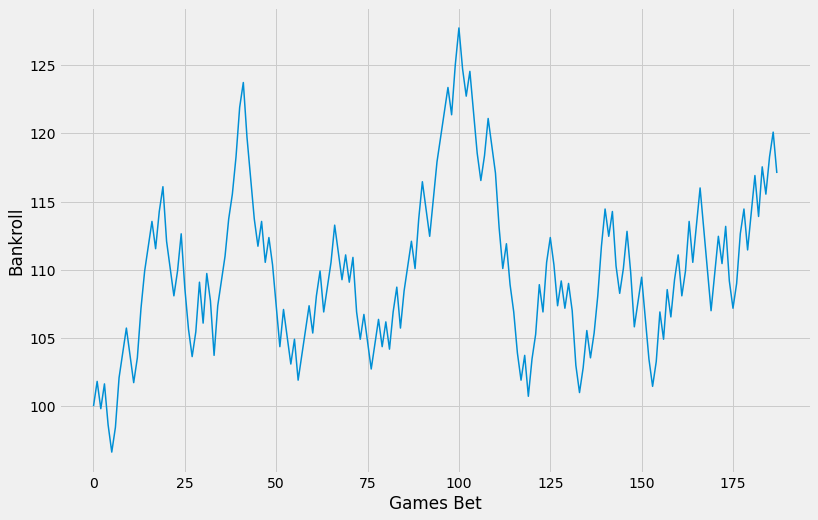

min balance: 96.63636363636363 
max balance: 127.72727272727266 
final balance: 115.09090909090905 
win percentage 53.72 
profit: 15.090909090909065 risk: 487.0 
ROI: 3.1
2
test set 1: 2017-10-20T00:00:00.000000000 - 2018-01-17T00:00:00.000000000


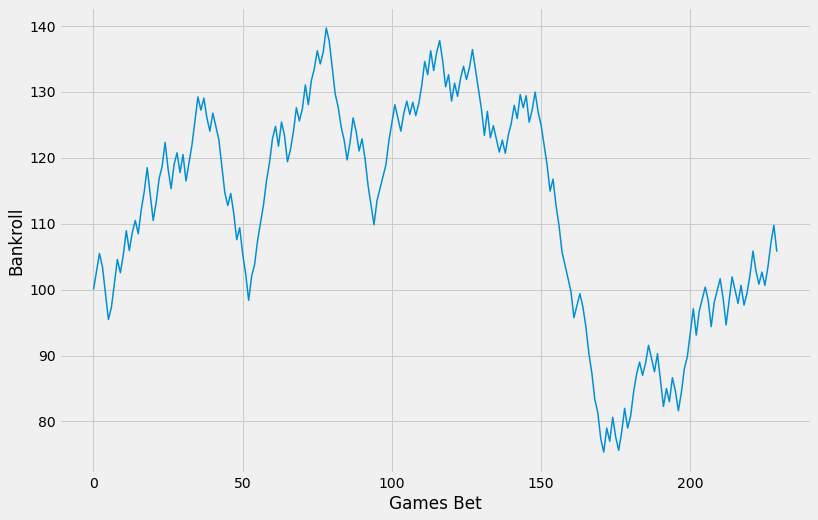

min balance: 75.36363636363632 
max balance: 139.63636363636368 
final balance: 102.72727272727275 
win percentage 51.739999999999995 
profit: 2.727272727272691 risk: 675.0 
ROI: 0.4
3
test set 1: 2018-01-17T00:00:00.000000000 - 2018-06-08T00:00:00.000000000


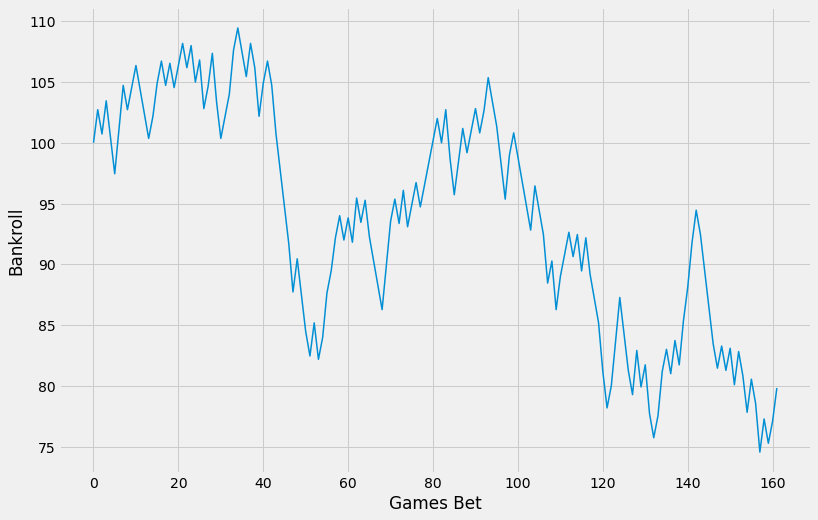

min balance: 74.54545454545453 
max balance: 109.45454545454542 
final balance: 77.81818181818181 
win percentage 48.77 
profit: -22.181818181818187 risk: 425.0 
ROI: -5.220000000000001
4
test set 1: 2018-10-19T00:00:00.000000000 - 2019-01-15T00:00:00.000000000


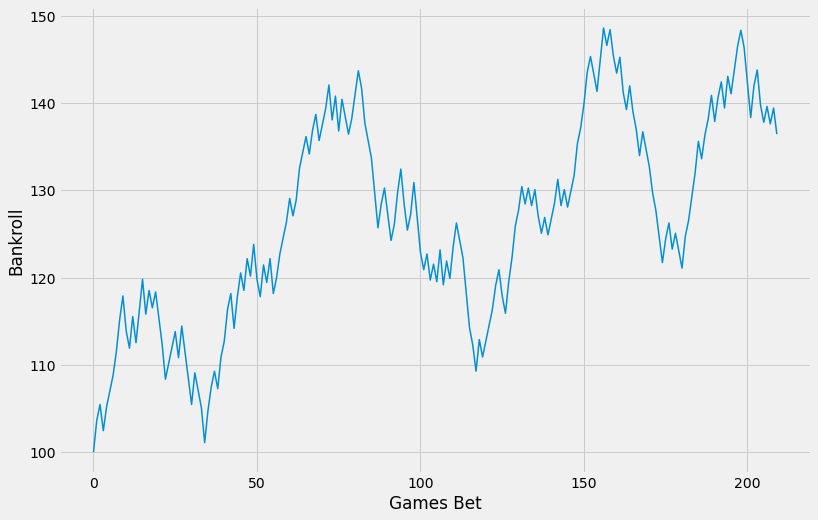

min balance: 101.09090909090911 
max balance: 148.63636363636343 
final balance: 138.2727272727269 
win percentage 55.24 
profit: 38.27272727272725 risk: 586.0 
ROI: 6.529999999999999
5
test set 1: 2019-01-16T00:00:00.000000000 - 2019-06-13T00:00:00.000000000


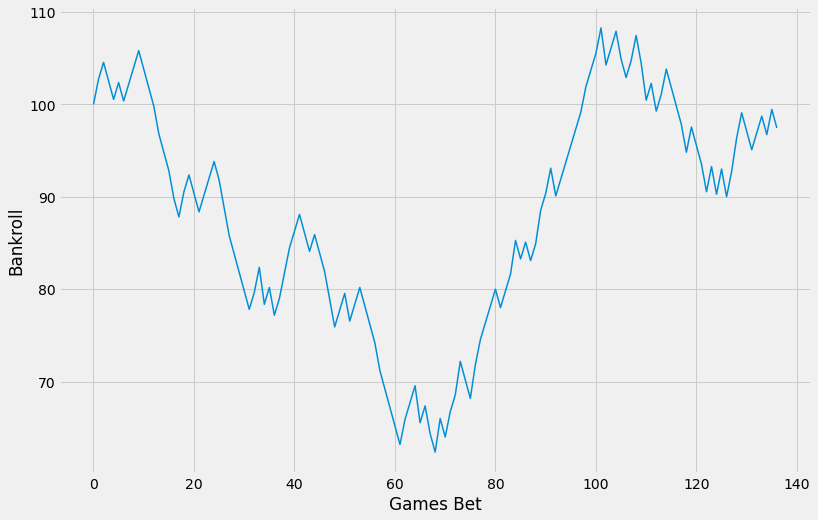

min balance: 62.36363636363629 
max balance: 108.27272727272717 
final balance: 95.45454545454537 
win percentage 51.09 
profit: -4.545454545454561 risk: 331.0 
ROI: -1.37
6
test set 1: 2019-10-25T00:00:00.000000000 - 2020-01-10T00:00:00.000000000


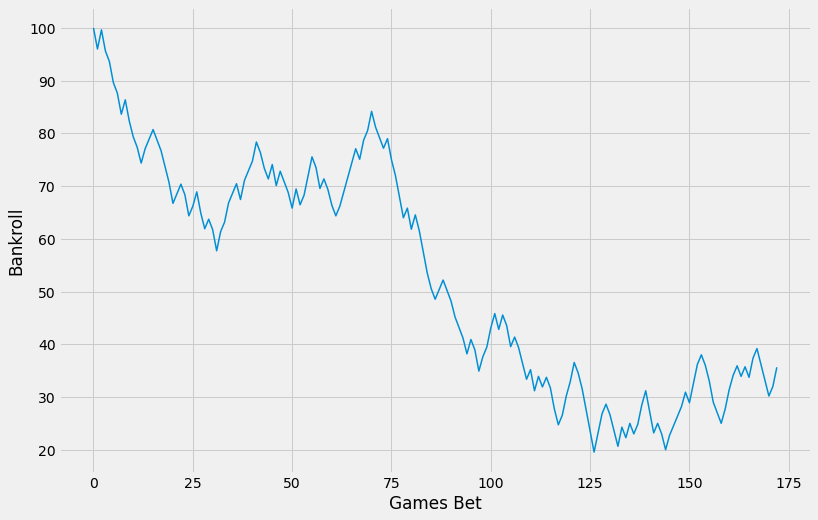

min balance: 19.54545454545456 
max balance: 99.63636363636364 
final balance: 33.63636363636364 
win percentage 45.660000000000004 
profit: -66.36363636363637 risk: 494.0 
ROI: -13.43
7
test set 1: 2020-01-10T00:00:00.000000000 - 2020-10-11T00:00:00.000000000


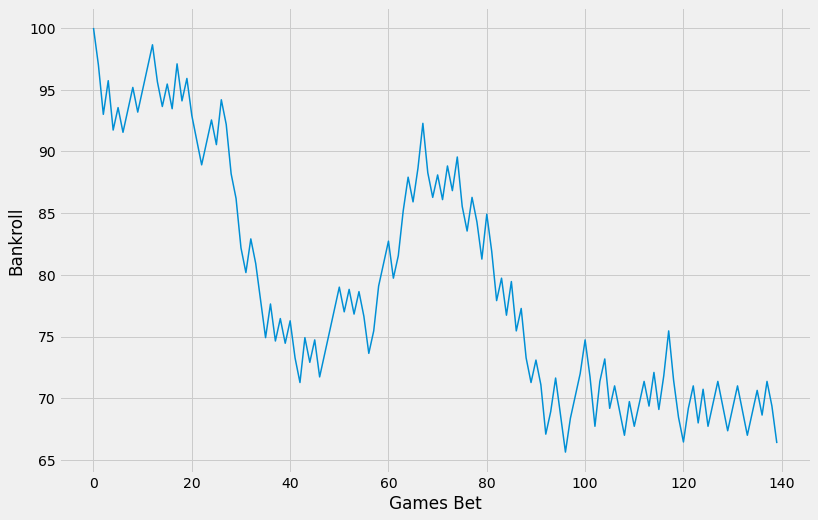

min balance: 65.63636363636358 
max balance: 98.63636363636361 
final balance: 69.09090909090904 
win percentage 49.29 
profit: -30.909090909090935 risk: 365.0 
ROI: -8.469999999999999
8
test set 1: 2020-12-25T00:00:00.000000000 - 2021-03-16T00:00:00.000000000


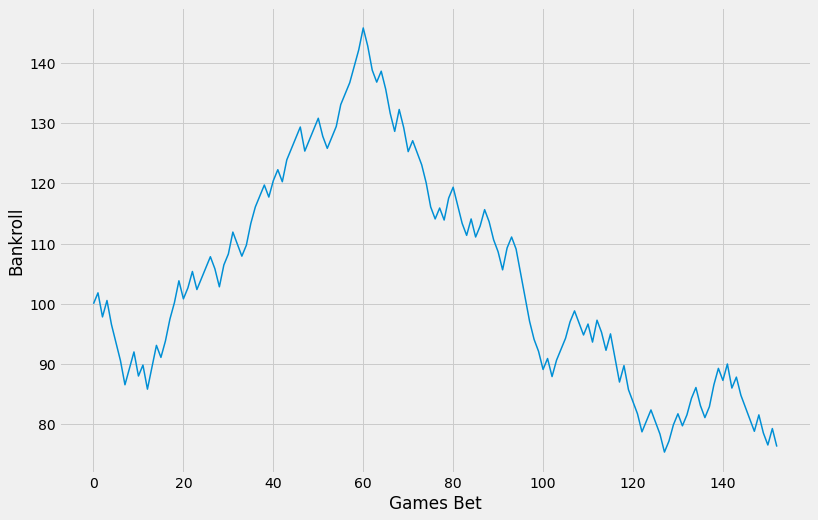

min balance: 74.2727272727272 
max balance: 145.81818181818176 
final balance: 74.2727272727272 
win percentage 50.33 
profit: -25.727272727272748 risk: 419.0 
ROI: -6.140000000000001
9
test set 1: 2021-03-16T00:00:00.000000000 - 2021-07-20T00:00:00.000000000


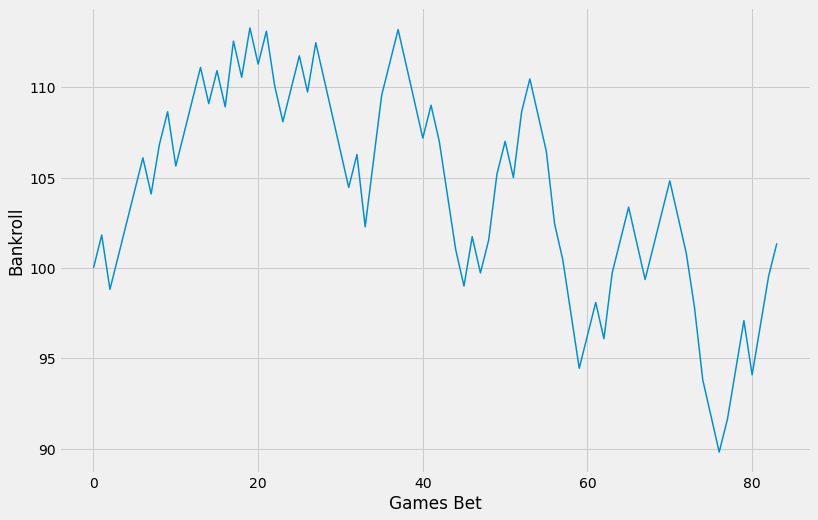

min balance: 89.81818181818173 
max balance: 113.27272727272724 
final balance: 103.1818181818181 
win percentage 52.38 
profit: 3.1818181818181728 risk: 203.0 
ROI: 1.5699999999999998
10
test set 1: 2021-10-22T00:00:00.000000000 - 2021-10-27T00:00:00.000000000


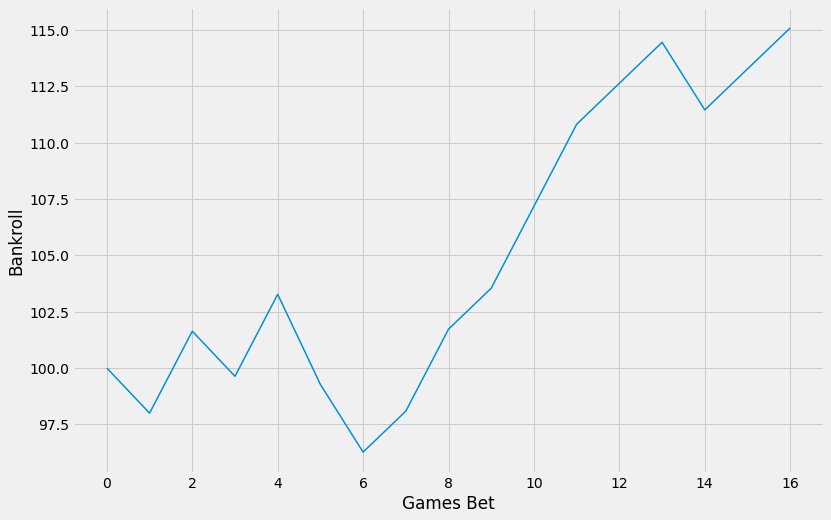

min balance: 96.27272727272728 
max balance: 115.09090909090908 
final balance: 111.09090909090908 
win percentage 64.71000000000001 
profit: 11.09090909090909 risk: 50.0 
ROI: 22.18
11
test set 1: 2021-10-27T00:00:00.000000000 - 2021-11-03T00:00:00.000000000


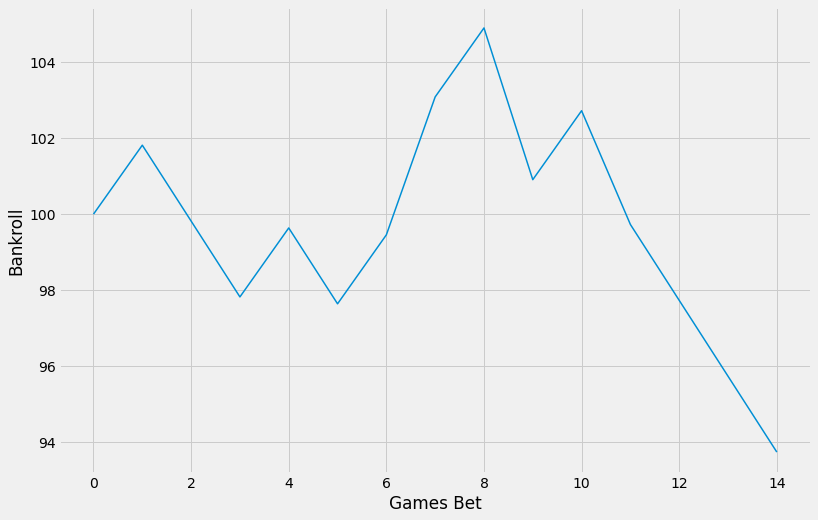

min balance: 93.7272727272727 
max balance: 104.90909090909089 
final balance: 95.54545454545452 
win percentage 46.67 
profit: -4.454545454545455 risk: 35.0 
ROI: -12.73

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['REB_team_diff',
                                                   'AST_3PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'DREB_opp_diff',
                                                   'REB_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'AST_2PM_opp_diff',
                       

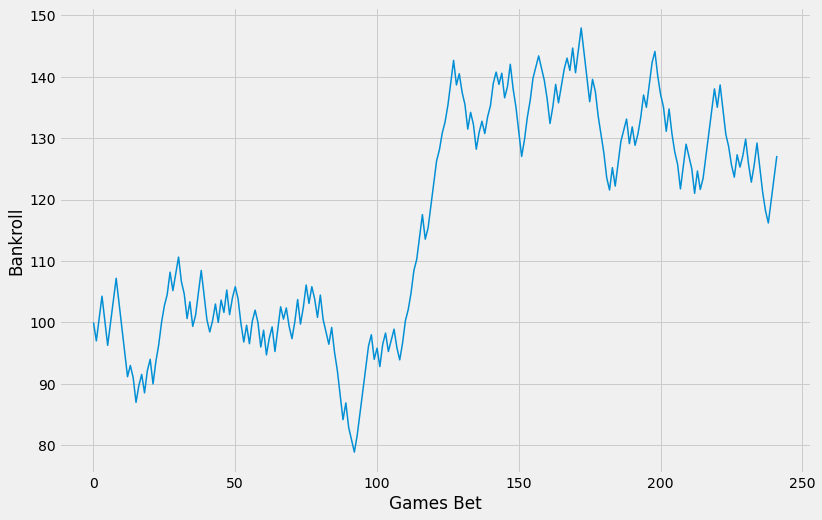

min balance: 78.90909090909103 
max balance: 147.90909090909082 
final balance: 130.72727272727255 
win percentage 54.13 
profit: 30.72727272727269 risk: 773.0 
ROI: 3.9800000000000004
1
test set 1: 2017-01-21T00:00:00.000000000 - 2017-06-12T00:00:00.000000000


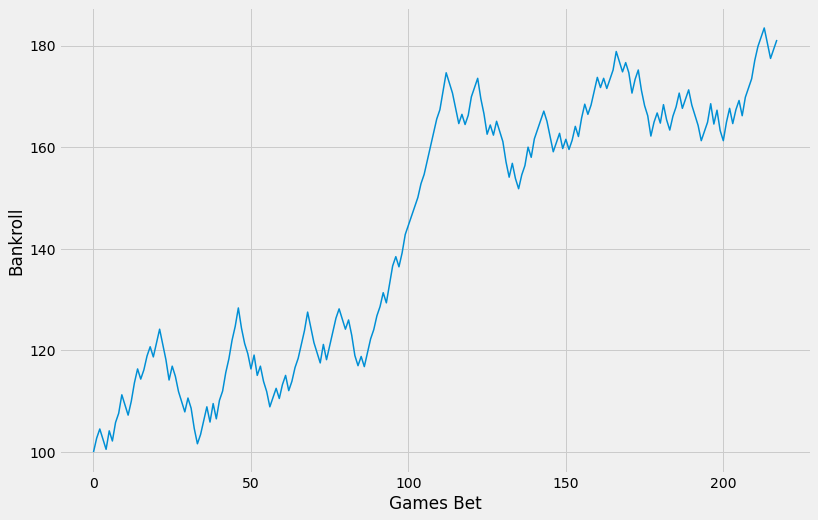

min balance: 100.54545454545455 
max balance: 183.45454545454504 
final balance: 178.09090909090867 
win percentage 58.26 
profit: 78.09090909090907 risk: 592.0 
ROI: 13.19
2
test set 1: 2017-10-20T00:00:00.000000000 - 2018-01-17T00:00:00.000000000


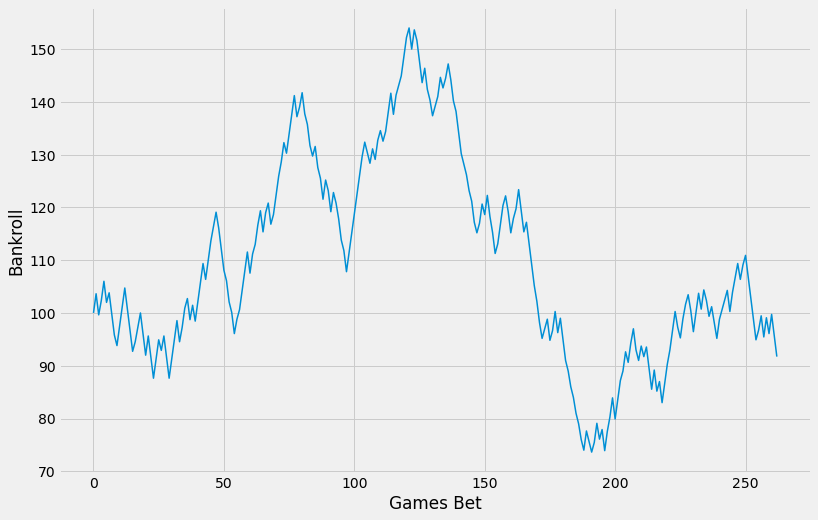

min balance: 73.63636363636358 
max balance: 154.0 
final balance: 93.54545454545456 
win percentage 52.09 
profit: -6.454545454545496 risk: 856.0 
ROI: -0.75
3
test set 1: 2018-01-17T00:00:00.000000000 - 2018-06-08T00:00:00.000000000


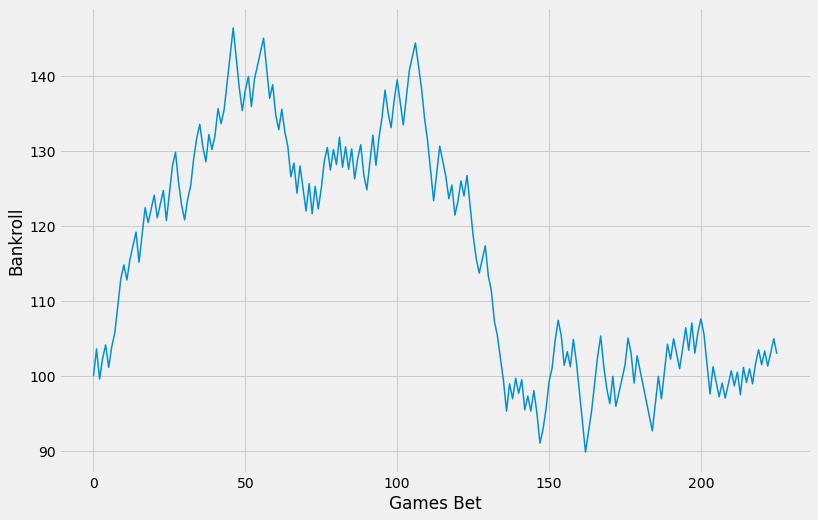

min balance: 89.90909090909065 
max balance: 146.3636363636363 
final balance: 98.99999999999977 
win percentage 52.21 
profit: -1.0 risk: 673.0 
ROI: -0.15
4
test set 1: 2018-10-19T00:00:00.000000000 - 2019-01-15T00:00:00.000000000


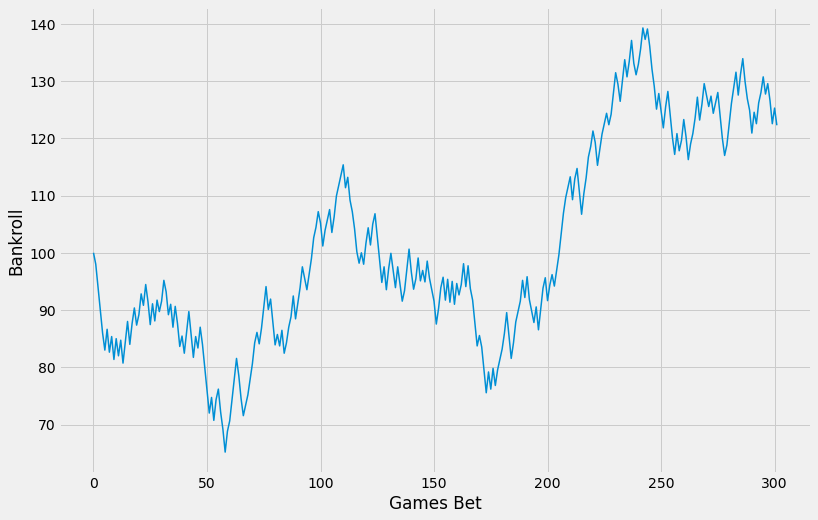

min balance: 65.18181818181824 
max balance: 139.27272727272742 
final balance: 125.90909090909102 
win percentage 54.97 
profit: 25.909090909090878 risk: 963.0 
ROI: 2.69
5
test set 1: 2019-01-16T00:00:00.000000000 - 2019-06-13T00:00:00.000000000


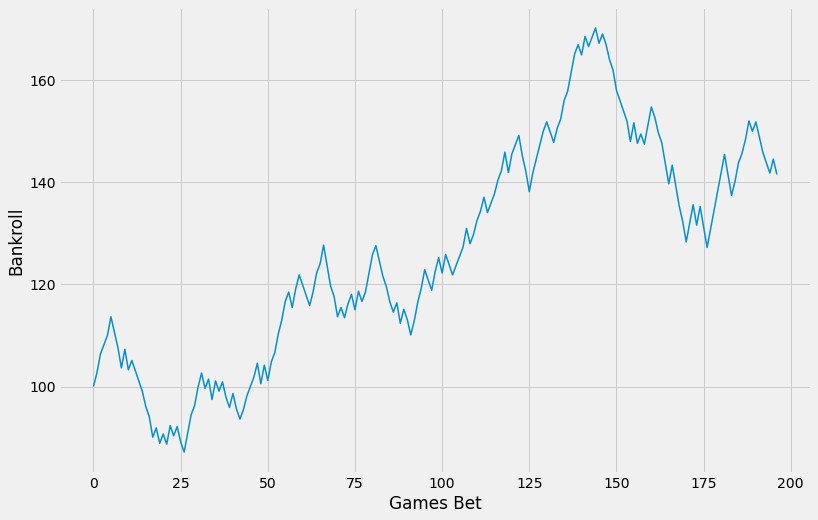

min balance: 87.18181818181817 
max balance: 170.09090909090895 
final balance: 138.45454545454513 
win percentage 54.31 
profit: 38.45454545454544 risk: 582.0 
ROI: 6.61
6
test set 1: 2019-10-25T00:00:00.000000000 - 2020-01-10T00:00:00.000000000


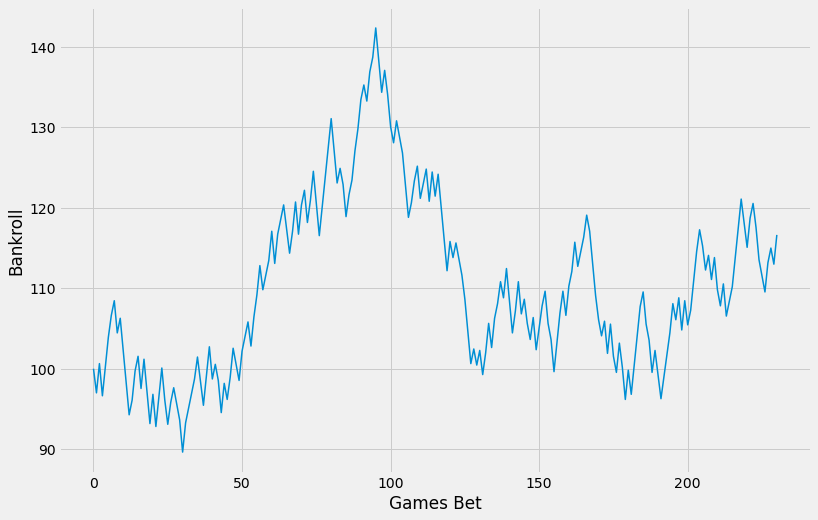

min balance: 89.63636363636365 
max balance: 142.36363636363637 
final balance: 112.63636363636374 
win percentage 54.11 
profit: 12.636363636363626 risk: 730.0 
ROI: 1.73
7
test set 1: 2020-01-10T00:00:00.000000000 - 2020-10-11T00:00:00.000000000


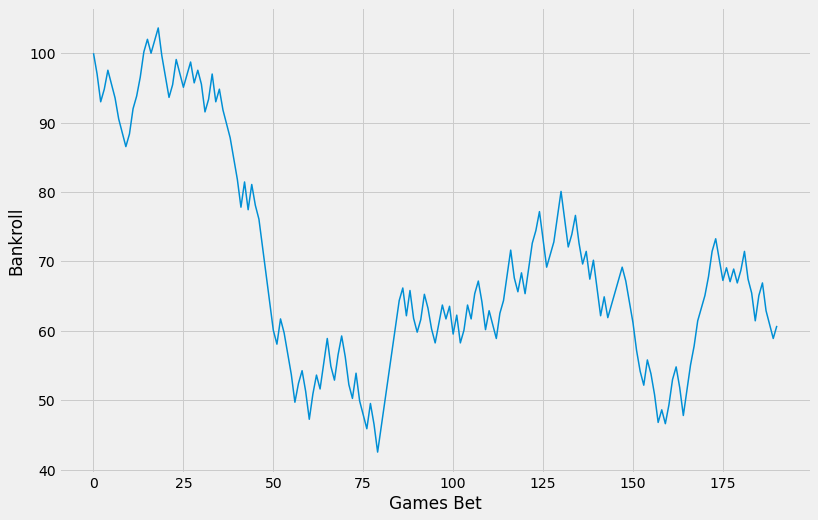

min balance: 42.5454545454545 
max balance: 103.63636363636363 
final balance: 62.545454545454476 
win percentage 49.21 
profit: -37.45454545454547 risk: 572.0 
ROI: -6.550000000000001
8
test set 1: 2020-12-25T00:00:00.000000000 - 2021-03-16T00:00:00.000000000


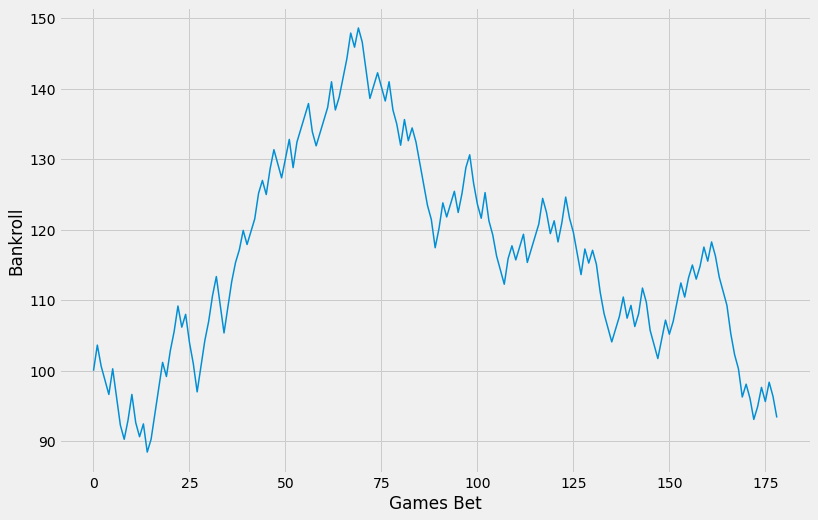

min balance: 88.45454545454547 
max balance: 148.63636363636357 
final balance: 91.36363636363627 
win percentage 50.28 
profit: -8.636363636363654 risk: 505.0 
ROI: -1.71
9
test set 1: 2021-03-16T00:00:00.000000000 - 2021-07-20T00:00:00.000000000


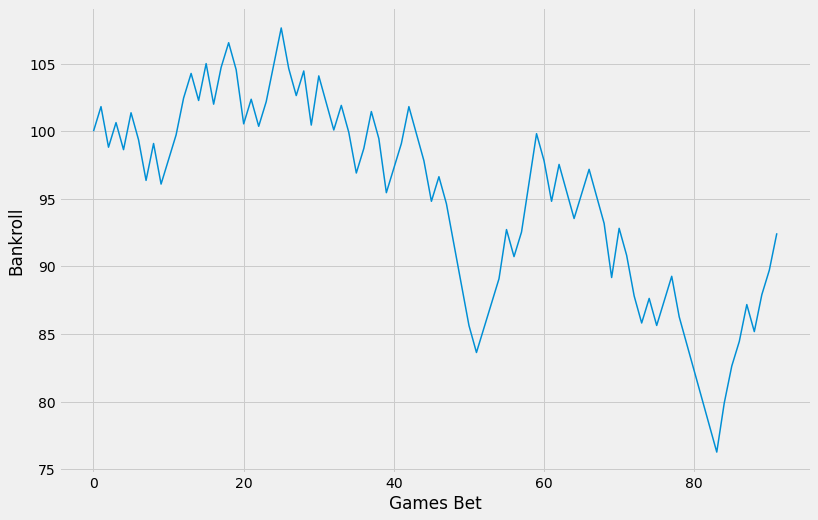

min balance: 76.27272727272724 
max balance: 107.63636363636364 
final balance: 95.18181818181817 
win percentage 50.0 
profit: -4.818181818181827 risk: 232.0 
ROI: -2.08
10
test set 1: 2021-10-22T00:00:00.000000000 - 2021-10-27T00:00:00.000000000


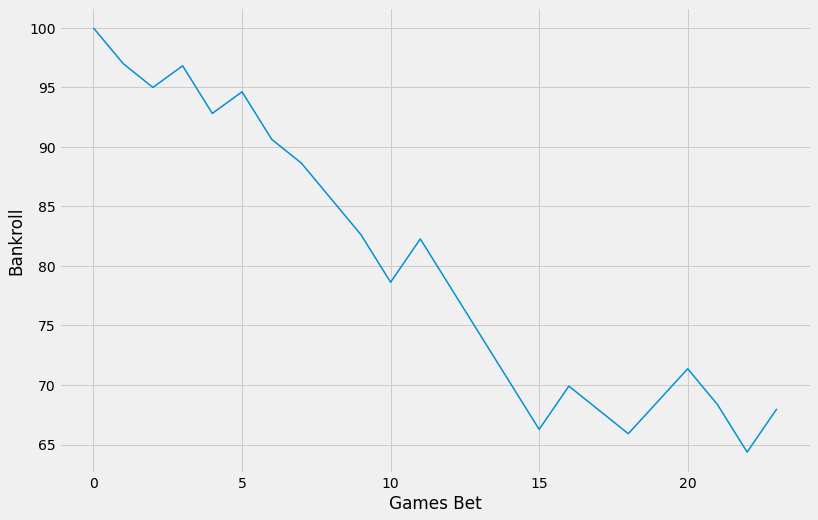

min balance: 64.36363636363637 
max balance: 97.0 
final balance: 70.72727272727275 
win percentage 33.33 
profit: -29.272727272727273 risk: 77.0 
ROI: -38.019999999999996
11
test set 1: 2021-10-27T00:00:00.000000000 - 2021-11-03T00:00:00.000000000


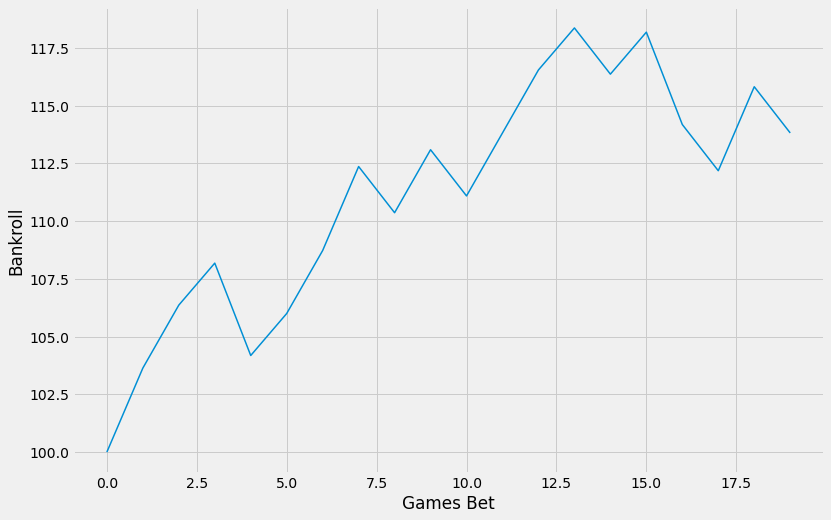

min balance: 103.63636363636364 
max balance: 118.36363636363639 
final balance: 115.63636363636365 
win percentage 65.0 
profit: 15.636363636363633 risk: 55.0 
ROI: 28.43

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('selector',
                                                                                  'passthrough',
                                                                                  ['RECORD_team_diff',
                                                                                   'FG2M_team_diff',
                                                                                   'FG2A_team_diff',
                                                                                   'STL_team_diff',
                                                                                   'TOV_team_diff',
                              

season  best_threshold  win_pcts  num_games_bet      rois    profits
0    2017            0.53  0.541322            242  0.039751  30.727273
1    2017            0.53  0.582569            218  0.131910  78.090909
2    2018            0.53  0.520913            263 -0.007540  -6.454545
3    2018            0.53  0.522124            226 -0.001486  -1.000000
4    2019            0.53  0.549669            302  0.026905  25.909091
5    2019            0.53  0.543147            197  0.066073  38.454545
6    2020            0.53  0.541126            231  0.017310  12.636364
7    2020            0.53  0.492147            191 -0.065480 -37.454545
8    2021            0.53  0.502793            179 -0.017102  -8.636364
9    2021            0.53  0.500000             92 -0.020768  -4.818182
10   2021            0.53  0.333333             24 -0.380165 -29.272727
11   2021            0.53  0.650000             20  0.284298  15.636364

In [150]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_mid_16, cutoff_17, cutoff_mid_17, cutoff_18, cutoff_mid_18,
           cutoff_19, cutoff_mid_19, cutoff_20, cutoff_mid_20, cutoff_21, cutoff_mid_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_sgd_hinge, best_sgd_huber, best_lgbc, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1, train_sample_weights, test_sample_weights = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].astype(str).str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

stacked clf train_acc: 0.5603860072376357
stacked clf test_acc: 0.51565848030328
0
test set 1: 2016-10-27 - 2017-06-12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 168 epochs took 5 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


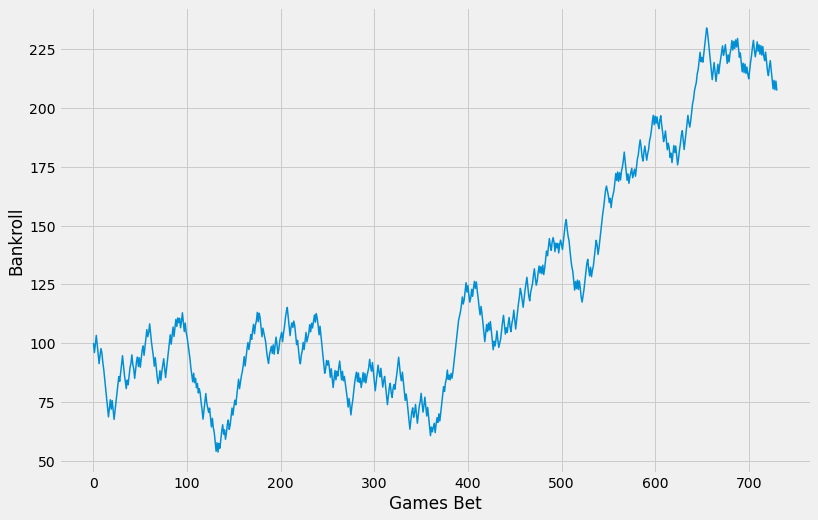

min balance: 53.63636363636379 
max balance: 234.09090909090878 
final balance: 209.27272727272663 
win percentage 54.86 
profit: 109.27272727272725 risk: 2489.0 
ROI: 4.390000000000001
1
test set 1: 2017-10-20 - 2018-06-08


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 178 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


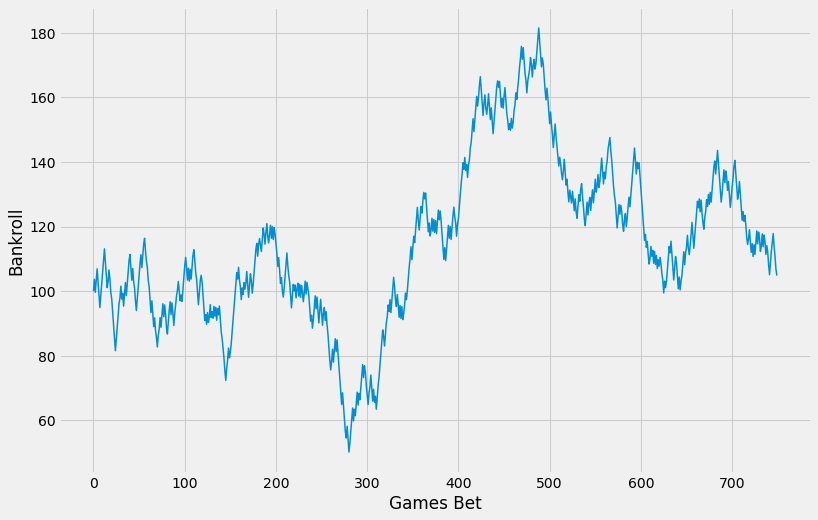

min balance: 50.181818181818564 
max balance: 181.45454545454558 
final balance: 101.81818181818161 
win percentage 51.6 
profit: 1.8181818181817562 risk: 2585.0 
ROI: 0.06999999999999999
2
test set 1: 2018-10-19 - 2019-06-13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 175 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished


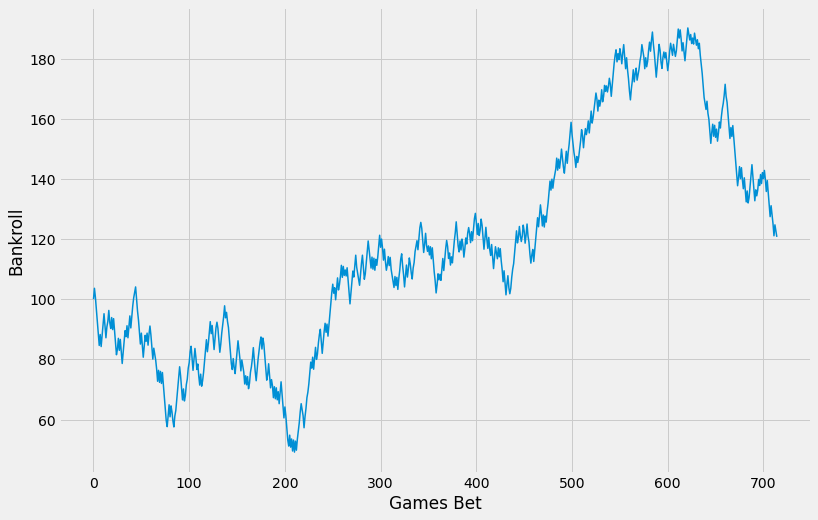

min balance: 49.181818181818436 
max balance: 190.18181818181807 
final balance: 117.72727272727231 
win percentage 51.74999999999999 
profit: 17.72727272727252 risk: 2403.0 
ROI: 0.74
3
test set 1: 2019-10-25 - 2020-10-11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 178 epochs took 8 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished


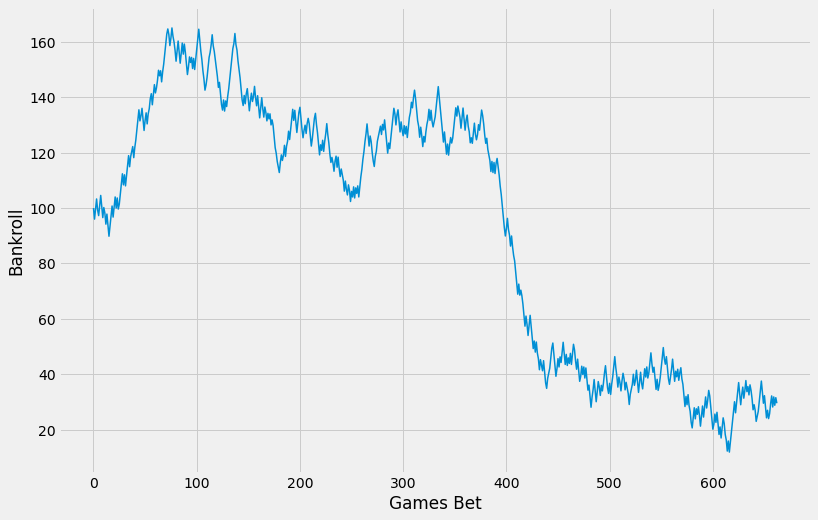

min balance: 11.909090909089919 
max balance: 164.99999999999986 
final balance: 33.181818181817164 
win percentage 49.919999999999995 
profit: -66.81818181818198 risk: 2268.0 
ROI: -2.9499999999999997
4
test set 1: 2020-12-25 - 2021-07-20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 185 epochs took 9 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


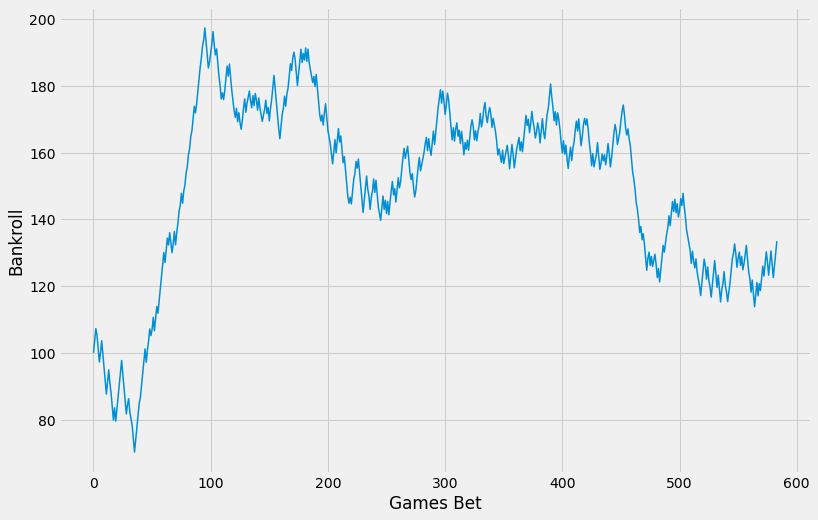

min balance: 70.27272727272732 
max balance: 197.36363636363623 
final balance: 137.09090909090725 
win percentage 53.25 
profit: 37.09090909090901 risk: 1935.0 
ROI: 1.92
5
test set 1: 2021-10-22 - 2021-10-26


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 164 epochs took 9 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s finished


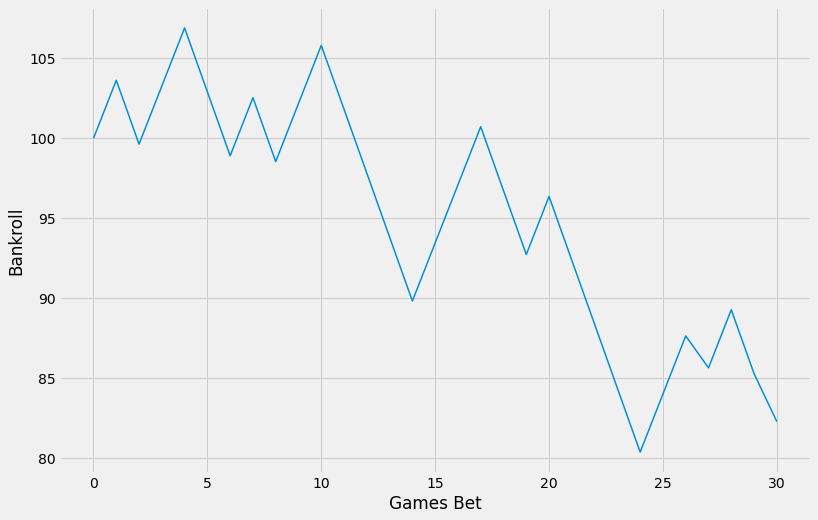

min balance: 78.27272727272732 
max balance: 106.90909090909092 
final balance: 78.27272727272732 
win percentage 41.94 
profit: -21.727272727272734 risk: 121.0 
ROI: -17.96

 Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.06226787404081285, max_iter=10000,
                                    random_state=23, solver='saga',
                                    verbose=1))])
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.548564            731  0.043902   
1  (2017, -, 2018)            0.53  0.516000            750  0.000703   
2  (2018, -, 2019)            0.53  0.517483            715  0.007377   
3  (2019, -, 2020)            0.53  0.499246            663 -0.029461   
4  (2020, -, 2021)            0.53  0.532534            584  0.019168   
5  (2021, -, 2021)            0.53  0.419355             31 -0.179564   

      profits  
0  109.272727  
1    1.818182 

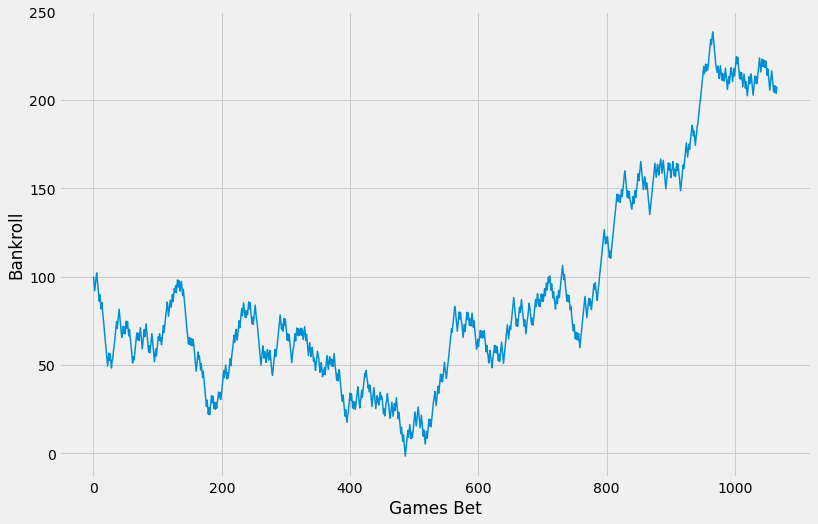

min balance: -1.7272727272726272 
max balance: 238.54545454545405 
final balance: 209.27272727272629 
win percentage 53.28000000000001 
profit: 109.27272727272702 risk: 4064.0 
ROI: 2.69
1
test set 1: 2017-10-20 - 2018-06-08


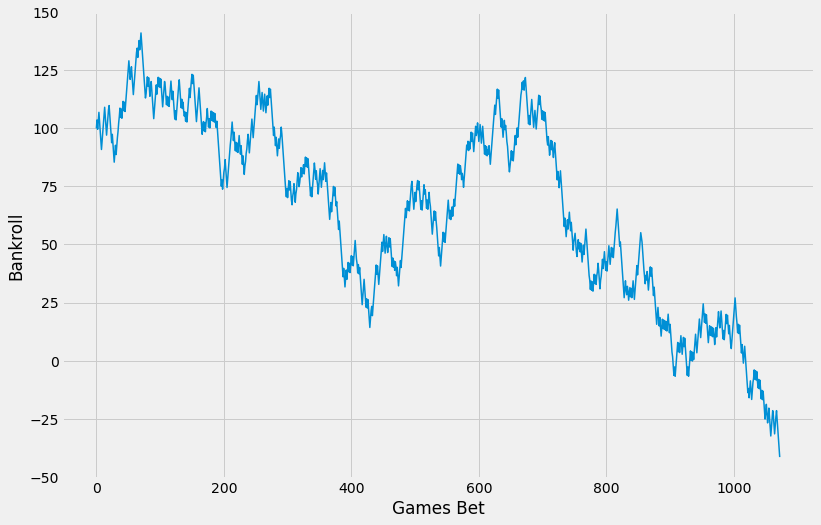

min balance: -45.54545454545388 
max balance: 141.09090909090915 
final balance: -45.54545454545388 
win percentage 50.7 
profit: -145.54545454545473 risk: 4126.0 
ROI: -3.53
2
test set 1: 2018-10-19 - 2019-06-13


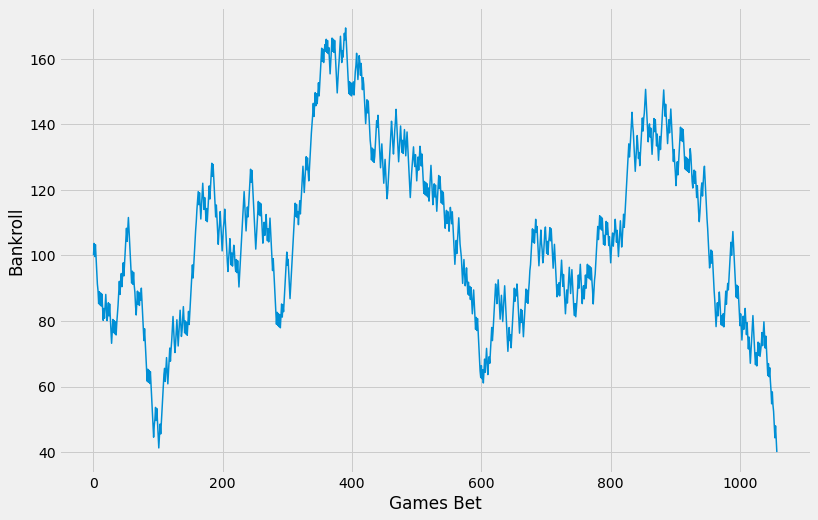

min balance: 36.0000000000001 
max balance: 169.36363636363663 
final balance: 36.0000000000001 
win percentage 51.7 
profit: -64.00000000000023 risk: 4033.0 
ROI: -1.59
3
test set 1: 2019-10-25 - 2020-10-11


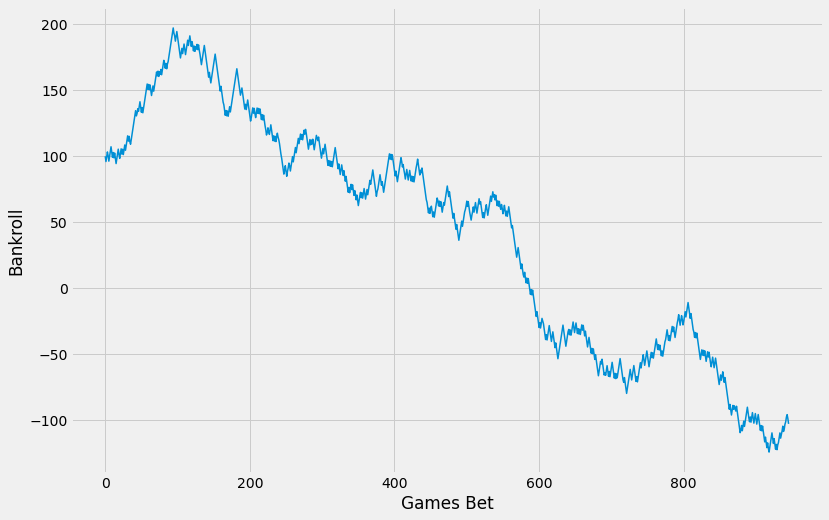

min balance: -124.09090909090963 
max balance: 197.1818181818179 
final balance: -99.09090909090959 
win percentage 49.26 
profit: -199.09090909090924 risk: 3645.0 
ROI: -5.46
4
test set 1: 2020-12-25 - 2021-07-20


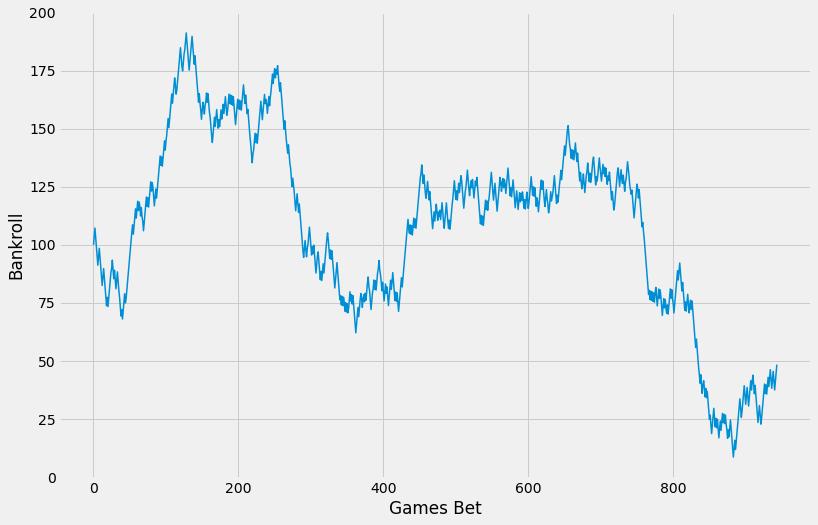

min balance: 8.636363636363168 
max balance: 191.27272727272717 
final balance: 52.090909090908546 
win percentage 51.480000000000004 
profit: -47.90909090909099 risk: 3574.0 
ROI: -1.34
5
test set 1: 2021-10-22 - 2021-10-26


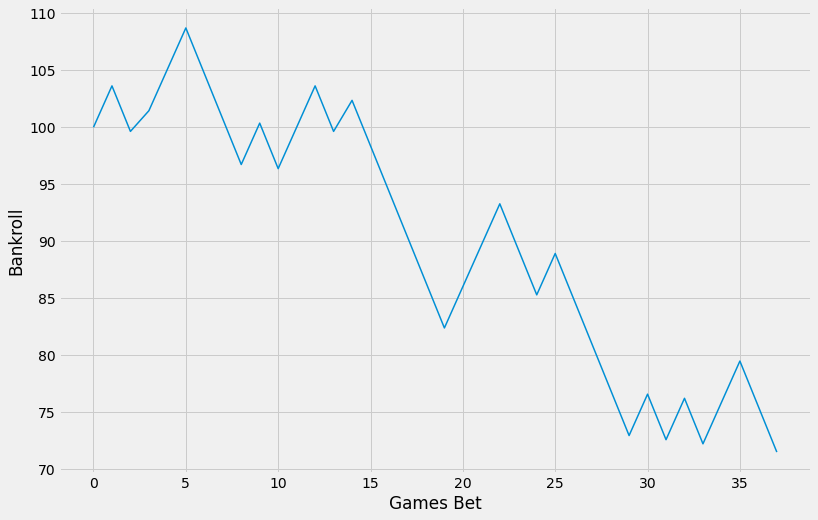

min balance: 67.45454545454551 
max balance: 108.72727272727273 
final balance: 67.45454545454551 
win percentage 42.11 
profit: -32.54545454545455 risk: 149.0 
ROI: -21.84

 Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.05305927223792528, loss='hinge', max_iter=100000,
                           random_state=23))])
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.532833           1066  0.026888   
1  (2017, -, 2018)            0.53  0.506990           1073 -0.035275   
2  (2018, -, 2019)            0.53  0.517013           1058 -0.015869   
3  (2019, -, 2020)            0.53  0.492600            946 -0.054620   
4  (2020, -, 2021)            0.53  0.514831            944 -0.013405   
5  (2021, -, 2021)            0.53  0.421053             38 -0.218426   

      profits  
0  109.272727  
1 -145.545455  
2  -64.000000  
3 -199.090909  
4  -47.909091  
5  -32.545455  
0
t

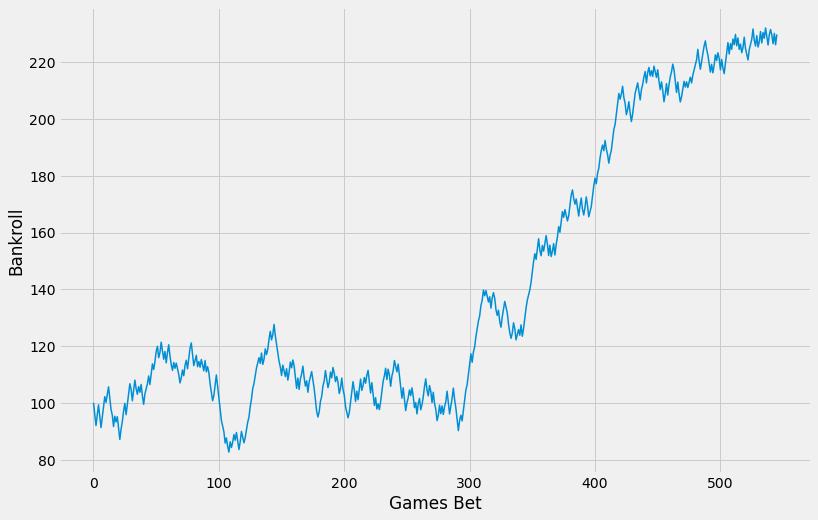

min balance: 82.63636363636374 
max balance: 232.09090909090835 
final balance: 225.81818181818105 
win percentage 55.489999999999995 
profit: 125.81818181818176 risk: 1684.0 
ROI: 7.470000000000001
1
test set 1: 2017-10-20 - 2018-06-08


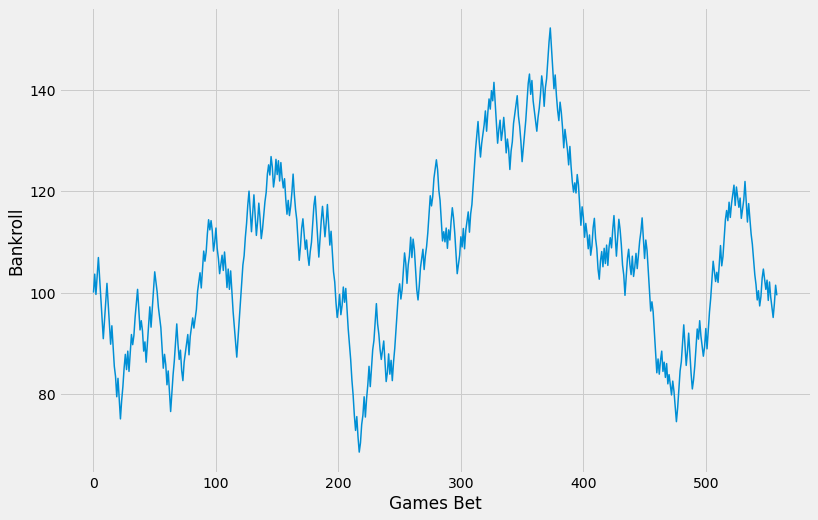

min balance: 68.54545454545476 
max balance: 152.1818181818182 
final balance: 97.45454545454554 
win percentage 52.59 
profit: -2.545454545454618 risk: 1778.0 
ROI: -0.13999999999999999
2
test set 1: 2018-10-19 - 2019-06-13


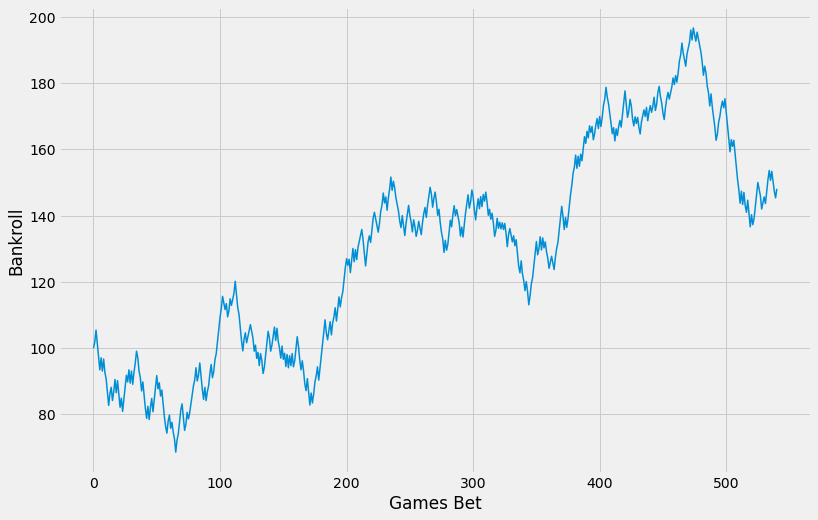

min balance: 68.63636363636371 
max balance: 196.63636363636277 
final balance: 149.90909090908983 
win percentage 53.42 
profit: 49.90909090909088 risk: 1695.0 
ROI: 2.94
3
test set 1: 2019-10-25 - 2020-10-11


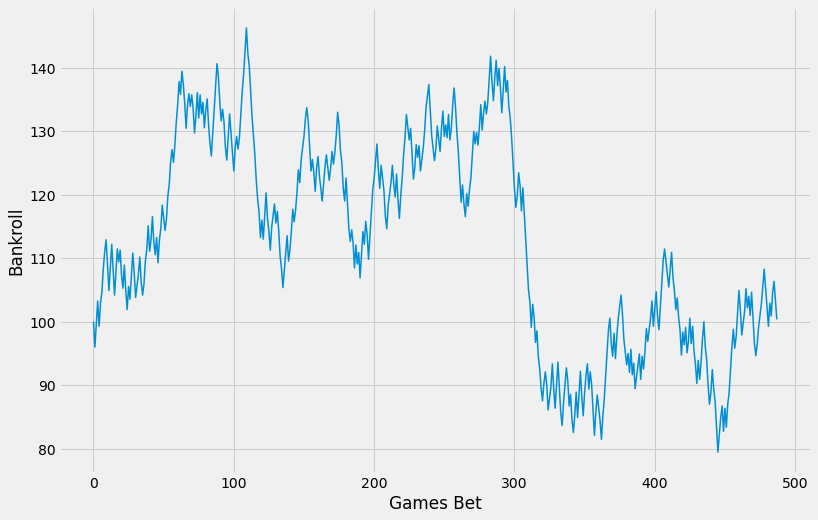

min balance: 79.45454545454524 
max balance: 146.2727272727271 
final balance: 103.99999999999982 
win percentage 52.05 
profit: 3.9999999999998863 risk: 1508.0 
ROI: 0.27
4
test set 1: 2020-12-25 - 2021-07-20


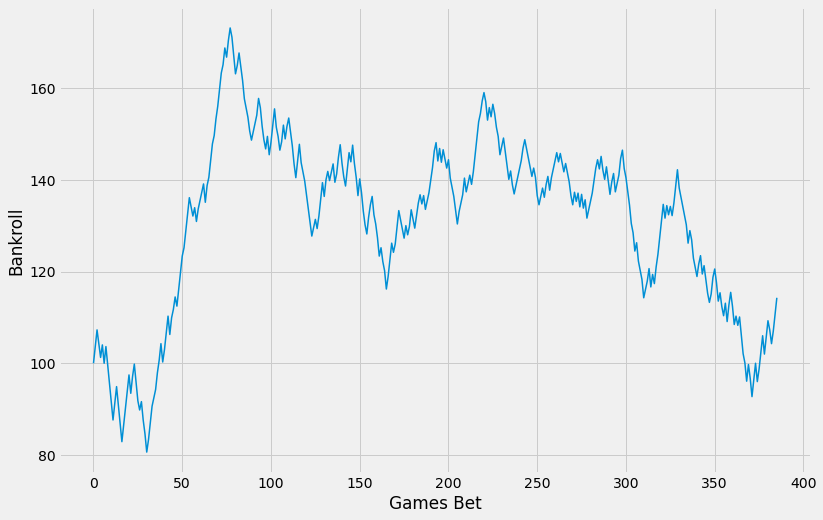

min balance: 80.63636363636368 
max balance: 173.090909090909 
final balance: 117.9090909090901 
win percentage 52.59 
profit: 17.909090909090878 risk: 1139.0 
ROI: 1.5699999999999998
5
test set 1: 2021-10-22 - 2021-10-26


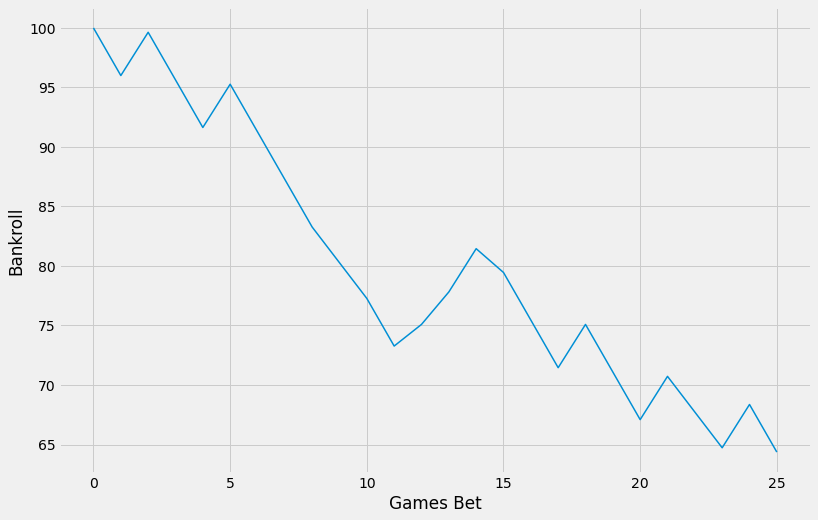

min balance: 60.36363636363639 
max balance: 99.63636363636364 
final balance: 60.36363636363639 
win percentage 30.769999999999996 
profit: -39.63636363636364 risk: 95.0 
ROI: -41.72

 Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.5629982879384883, loss='modified_huber',
                               max_iter=10000, random_state=23))])
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.554945            546  0.074714   
1  (2017, -, 2018)            0.53  0.525939            559 -0.001432   
2  (2018, -, 2019)            0.53  0.534196            541  0.029445   
3  (2019, -, 2020)            0.53  0.520492            488  0.002653   
4  (2020, -, 2021)            0.53  0.525907            386  0.015724   
5  (2021, -, 2021)            0.53  0.307692             26 -0.417225   

      profits  
0  125.818182  
1   -2.545455  
2   49.909091  
3    4.000000  
4   1

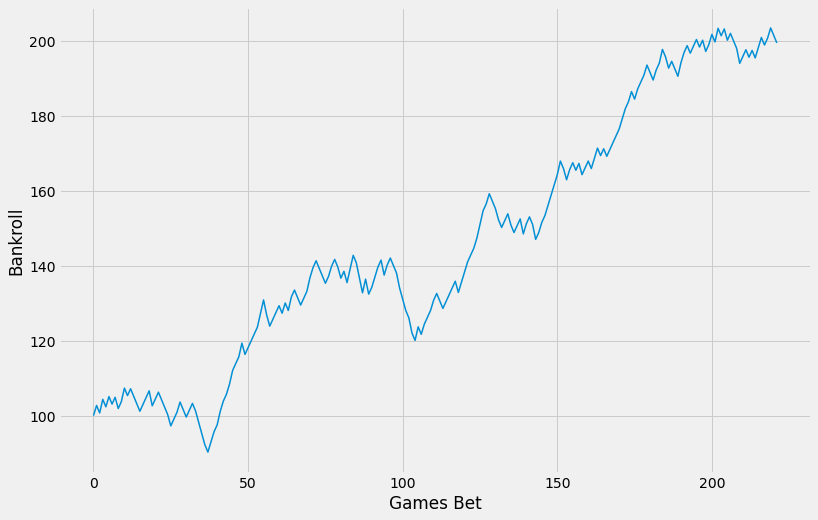

min balance: 90.27272727272724 
max balance: 203.54545454545388 
final balance: 201.3636363636357 
win percentage 60.809999999999995 
profit: 101.36363636363632 risk: 563.0 
ROI: 18.0
1
test set 1: 2017-10-20 - 2018-06-08


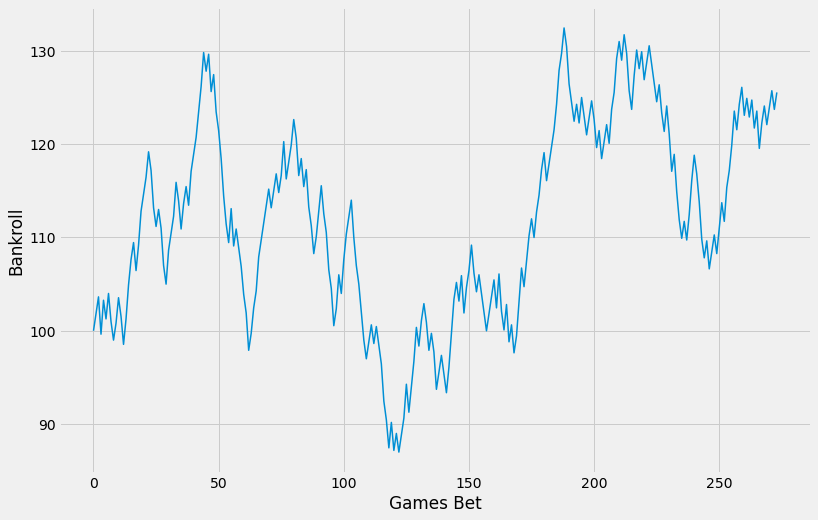

min balance: 86.99999999999996 
max balance: 132.4545454545454 
final balance: 123.54545454545443 
win percentage 54.379999999999995 
profit: 23.545454545454504 risk: 721.0 
ROI: 3.27
2
test set 1: 2018-10-19 - 2019-06-13


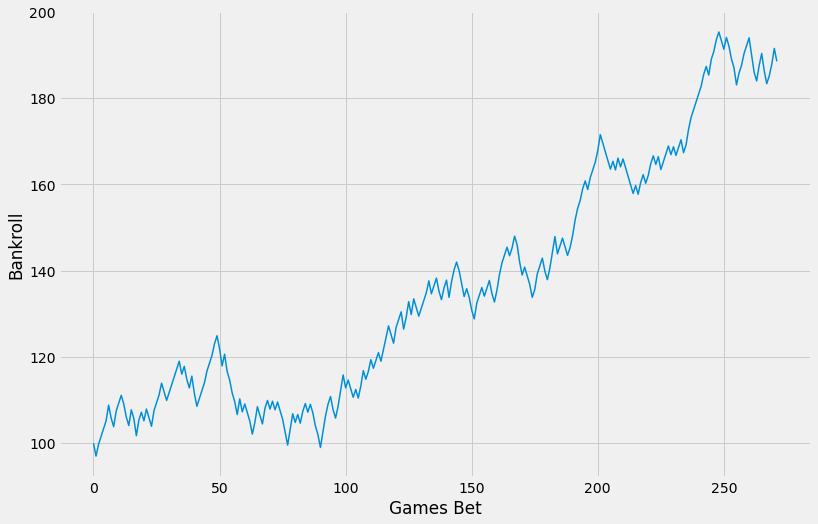

min balance: 97.0 
max balance: 195.36363636363583 
final balance: 185.54545454545394 
win percentage 57.35 
profit: 85.5454545454545 risk: 701.0 
ROI: 12.2
3
test set 1: 2019-10-25 - 2020-10-11


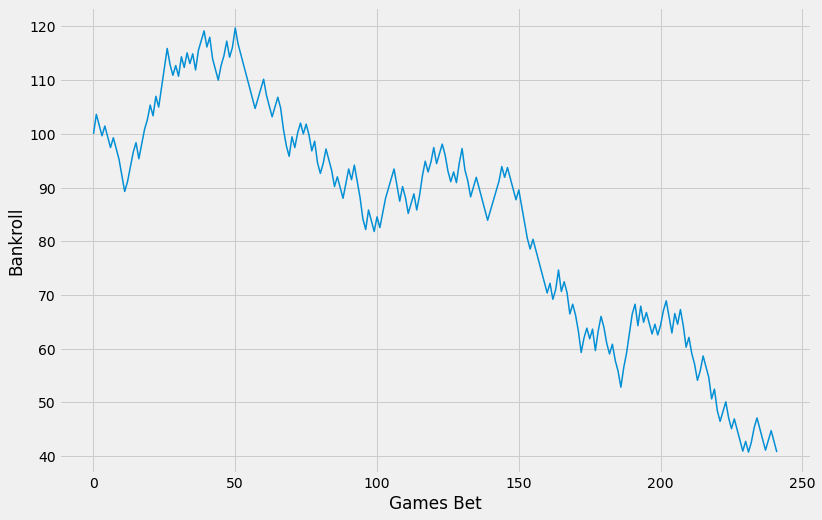

min balance: 40.727272727272705 
max balance: 119.72727272727275 
final balance: 42.54545454545453 
win percentage 46.28 
profit: -57.454545454545496 risk: 613.0 
ROI: -9.370000000000001
4
test set 1: 2020-12-25 - 2021-07-20


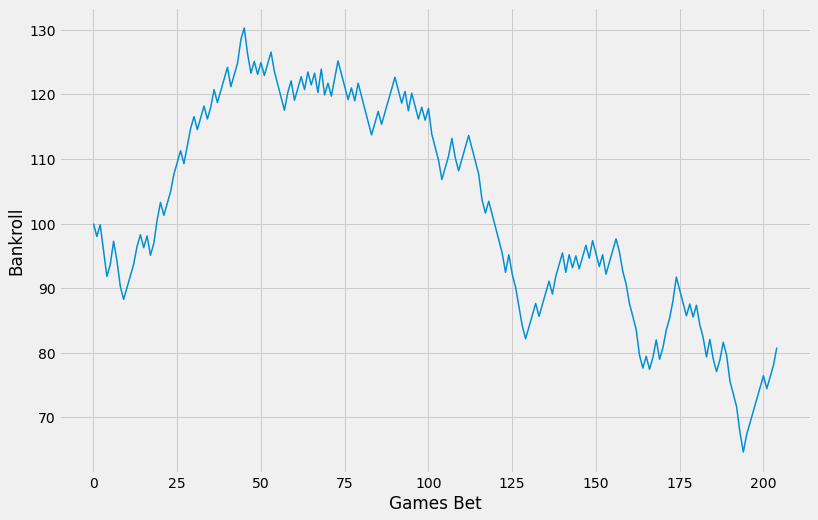

min balance: 64.63636363636343 
max balance: 130.2727272727272 
final balance: 82.6363636363634 
win percentage 51.71 
profit: -17.363636363636374 risk: 487.0 
ROI: -3.5700000000000003
5
test set 1: 2021-10-22 - 2021-10-26


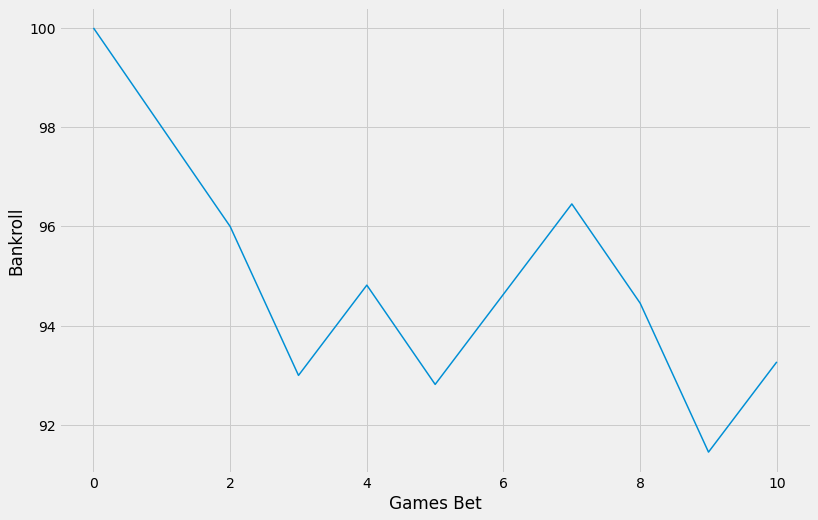

min balance: 91.45454545454544 
max balance: 98.0 
final balance: 95.09090909090907 
win percentage 45.45 
profit: -4.90909090909091 risk: 24.0 
ROI: -20.45

 RandomForestClassifier(max_depth=14, min_samples_leaf=0.011132401847594018,
                       min_samples_split=0.028510554930813045, random_state=23)
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.608108            222  0.180042   
1  (2017, -, 2018)            0.53  0.543796            274  0.032657   
2  (2018, -, 2019)            0.53  0.573529            272  0.122033   
3  (2019, -, 2020)            0.53  0.462810            242 -0.093727   
4  (2020, -, 2021)            0.53  0.517073            205 -0.035654   
5  (2021, -, 2021)            0.53  0.454545             11 -0.204545   

      profits  
0  101.363636  
1   23.545455  
2   85.545455  
3  -57.454545  
4  -17.363636  
5   -4.909091  
0
test set 1: 2016-10-27 - 2017-06-12


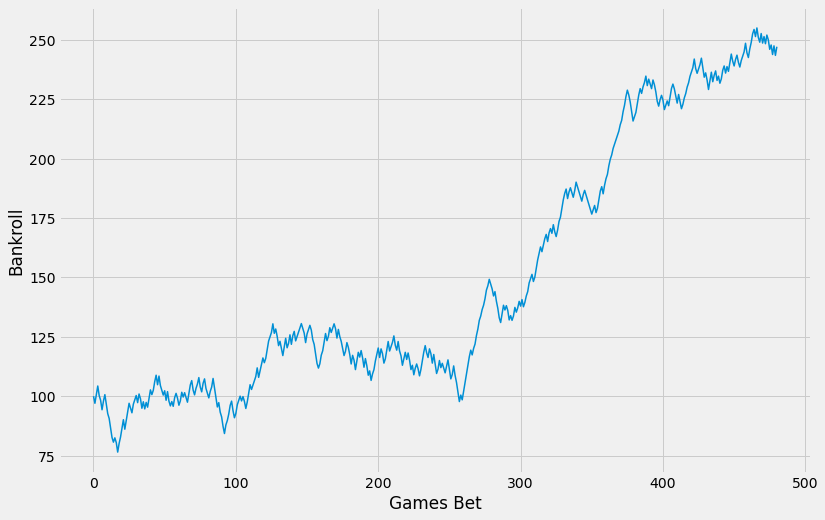

min balance: 76.45454545454547 
max balance: 254.99999999999923 
final balance: 243.09090909090827 
win percentage 57.379999999999995 
profit: 143.090909090909 risk: 1430.0 
ROI: 10.01
1
test set 1: 2017-10-20 - 2018-06-08


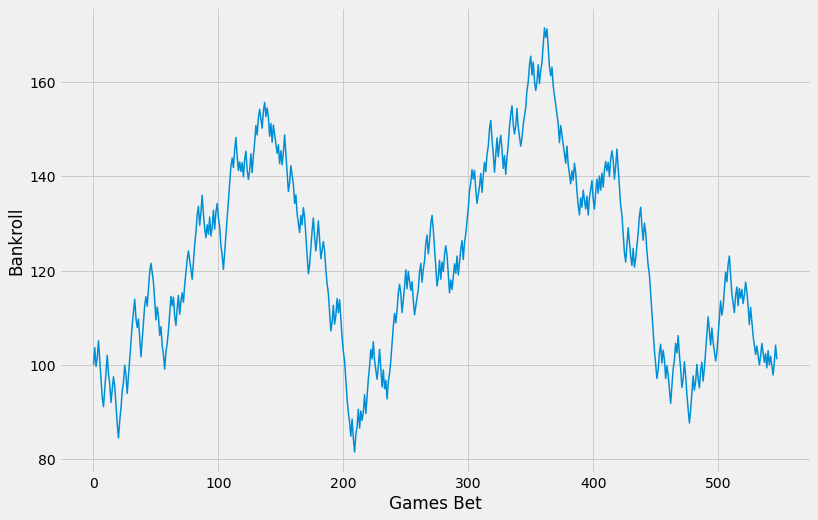

min balance: 81.45454545454524 
max balance: 171.5454545454541 
final balance: 98.18181818181762 
win percentage 51.28 
profit: -1.8181818181818699 risk: 1699.0 
ROI: -0.11
2
test set 1: 2018-10-19 - 2019-06-13


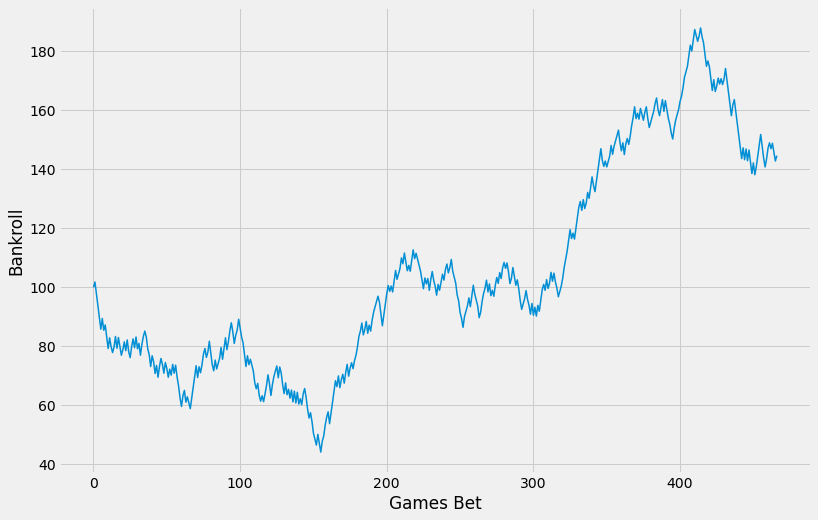

min balance: 44.1818181818183 
max balance: 187.90909090909076 
final balance: 142.6363636363633 
win percentage 53.53 
profit: 42.636363636363626 risk: 1435.0 
ROI: 2.97
3
test set 1: 2019-10-25 - 2020-10-11


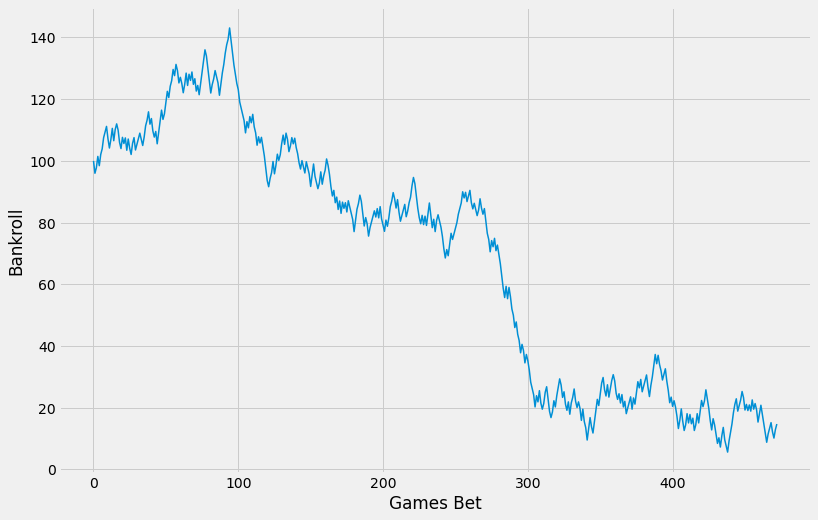

min balance: 5.636363636363596 
max balance: 143.090909090909 
final balance: 17.4545454545454 
win percentage 49.26 
profit: -82.54545454545462 risk: 1417.0 
ROI: -5.83
4
test set 1: 2020-12-25 - 2021-07-20


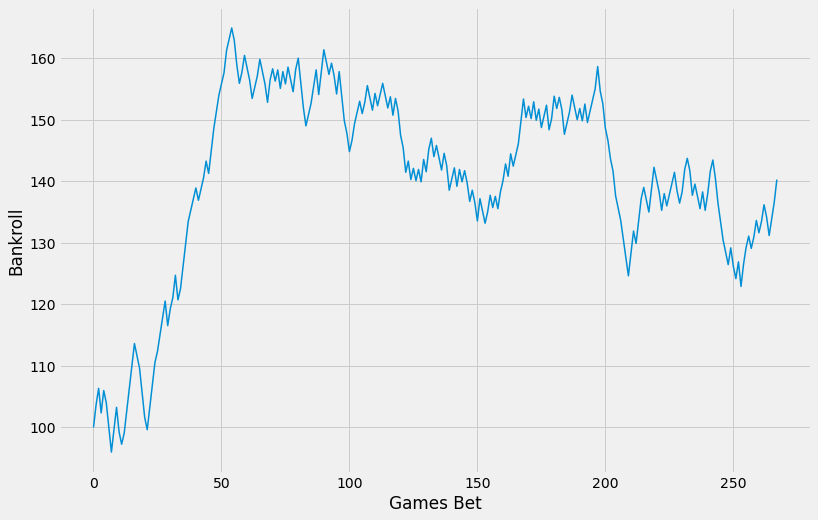

min balance: 96.00000000000001 
max balance: 164.90909090909085 
final balance: 142.99999999999923 
win percentage 53.73 
profit: 42.99999999999994 risk: 734.0 
ROI: 5.86
5
test set 1: 2021-10-22 - 2021-10-26


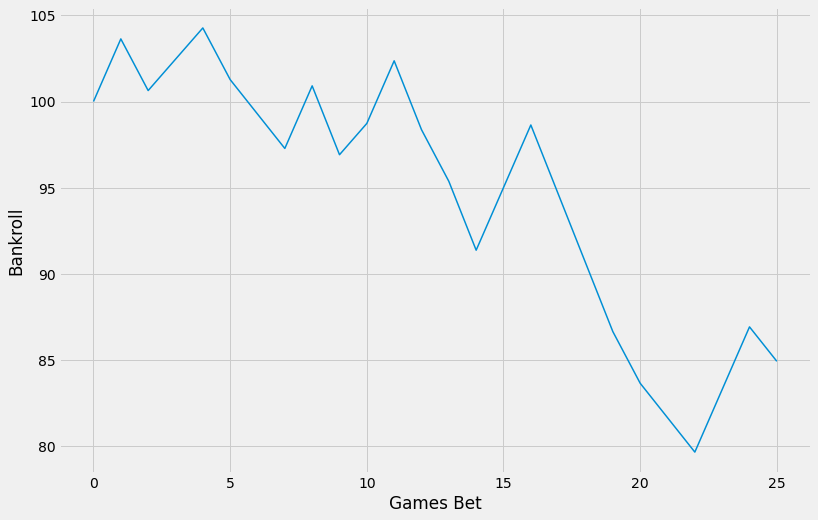

min balance: 79.63636363636364 
max balance: 104.27272727272727 
final balance: 80.90909090909092 
win percentage 38.46 
profit: -19.090909090909093 risk: 84.0 
ROI: -22.73

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.06226787404081285,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.573805            481  0.100064   
1  (2017, -, 2018)            0.53  0.512774            548 -0.001070   
2  (2018, -, 2019)            0.53  0.535332            467  0.029712   
3  (2019, -, 2020)            0.53  0.492600            473 -0.058254   
4  (2020, -, 2021)            0.53  0.537313            268  0.058583   
5  (2021, -, 2021)            0.53  0.384615             26 -0.227273   

      profits  
0  143.090909  
1   -1.818182  
2   42.636364  
3  -82.545455  
4   43.000000  
5  -19.090909

In [412]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_svc, best_sgd, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

stacked clf train_acc: 0.5640048250904705
stacked clf test_acc: 0.512938849513763
0
test set 1: 2016-10-27 - 2017-06-12


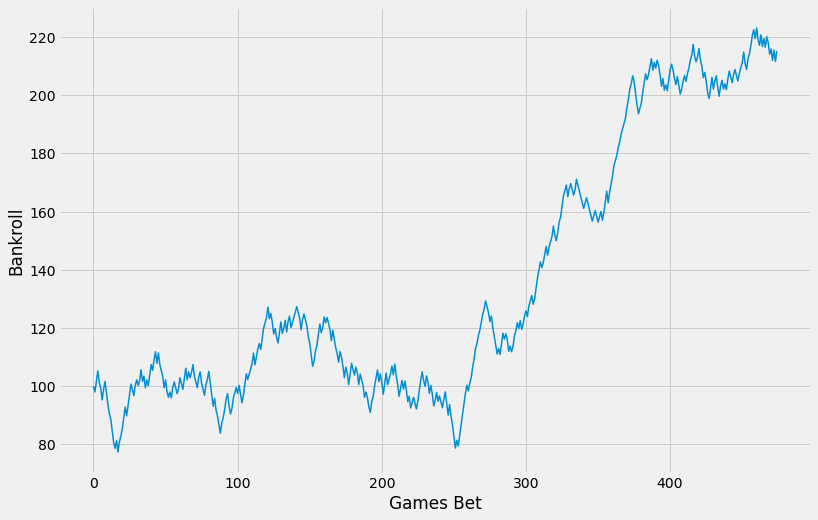

min balance: 77.36363636363639 
max balance: 223.0909090909086 
final balance: 211.18181818181765 
win percentage 55.78999999999999 
profit: 111.18181818181813 risk: 1397.0 
ROI: 7.960000000000001
1
test set 1: 2017-10-20 - 2018-06-08


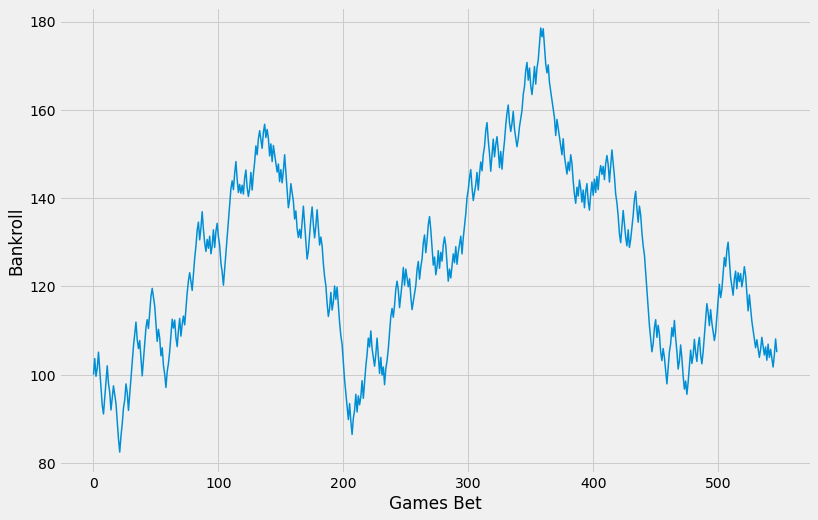

min balance: 82.45454545454548 
max balance: 178.54545454545396 
final balance: 102.0909090909083 
win percentage 51.28 
profit: 2.0909090909090082 risk: 1697.0 
ROI: 0.12
2
test set 1: 2018-10-19 - 2019-06-13


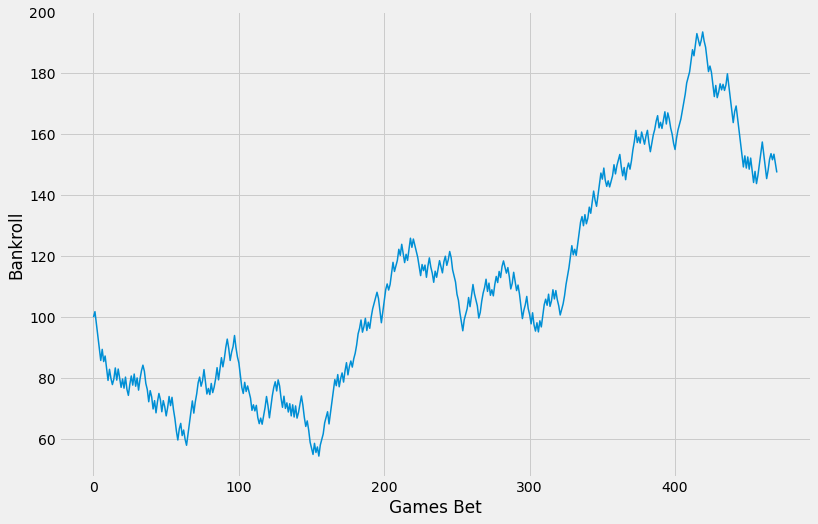

min balance: 54.45454545454561 
max balance: 193.54545454545445 
final balance: 149.272727272727 
win percentage 53.72 
profit: 49.27272727272725 risk: 1457.0 
ROI: 3.38
3
test set 1: 2019-10-25 - 2020-10-11


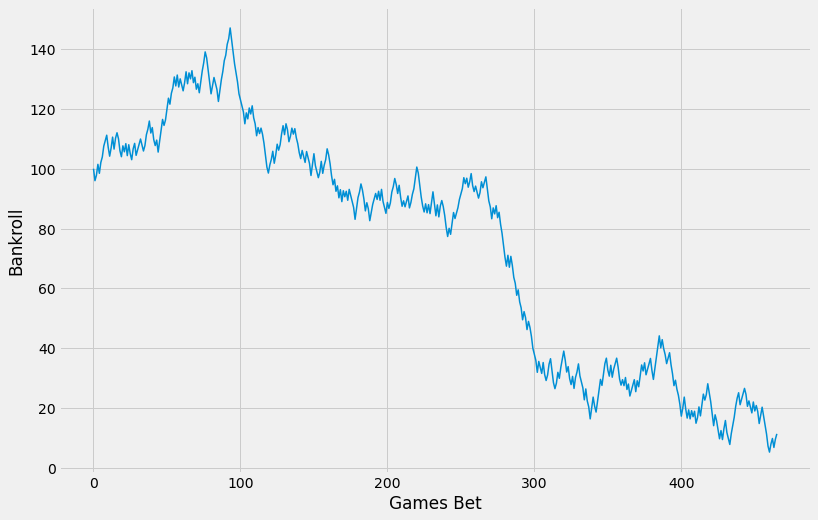

min balance: 5.363636363636289 
max balance: 146.99999999999986 
final balance: 14.181818181818105 
win percentage 48.93 
profit: -85.81818181818187 risk: 1405.0 
ROI: -6.11
4
test set 1: 2020-12-25 - 2021-07-20


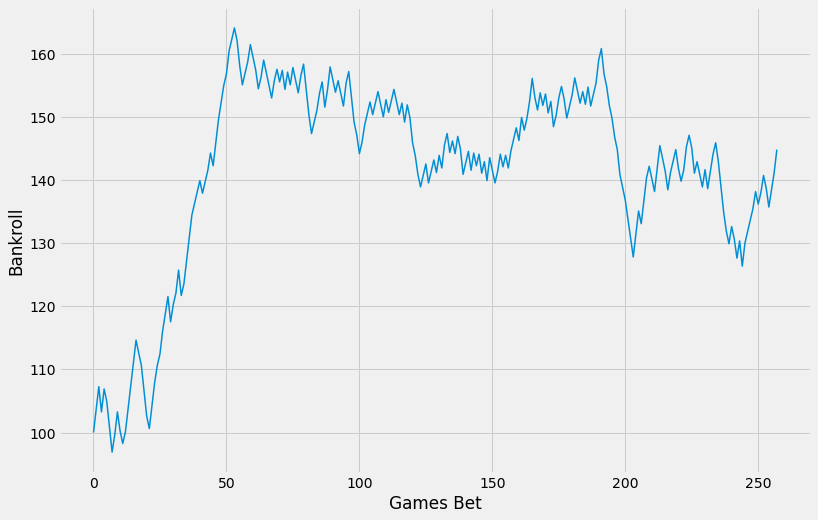

min balance: 96.90909090909092 
max balance: 164.09090909090904 
final balance: 147.5454545454538 
win percentage 54.65 
profit: 47.545454545454504 risk: 697.0 
ROI: 6.819999999999999
5
test set 1: 2021-10-22 - 2021-10-26


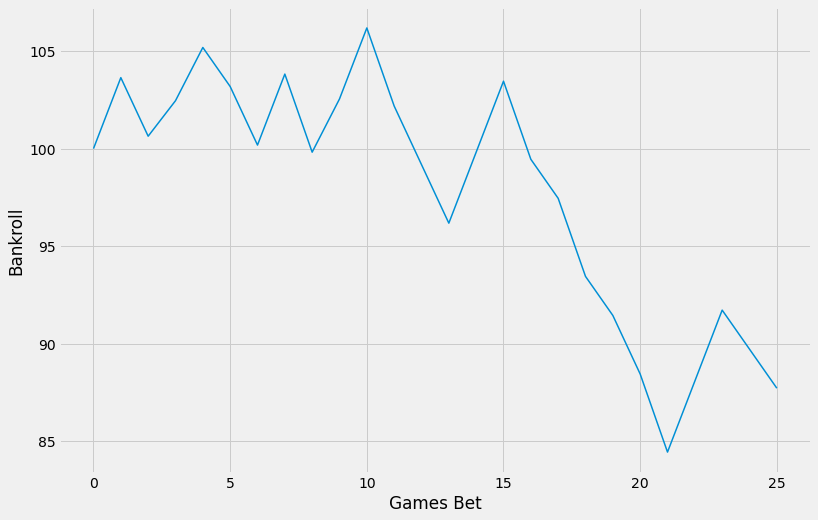

min balance: 83.72727272727276 
max balance: 106.1818181818182 
final balance: 83.72727272727276 
win percentage 38.46 
profit: -16.272727272727273 risk: 85.0 
ROI: -19.139999999999997

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.06226787404081285,
                                                                    max_iter=100000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                    

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.557895            475  0.079586   
1  (2017, -, 2018)            0.53  0.512774            548  0.001232   
2  (2018, -, 2019)            0.53  0.537155            471  0.033818   
3  (2019, -, 2020)            0.53  0.489270            466 -0.061081   
4  (2020, -, 2021)            0.53  0.546512            258  0.068214   
5  (2021, -, 2021)            0.53  0.384615             26 -0.191444   

      profits  
0  111.181818  
1    2.090909  
2   49.272727  
3  -85.818182  
4   47.545455  
5  -16.272727

In [414]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


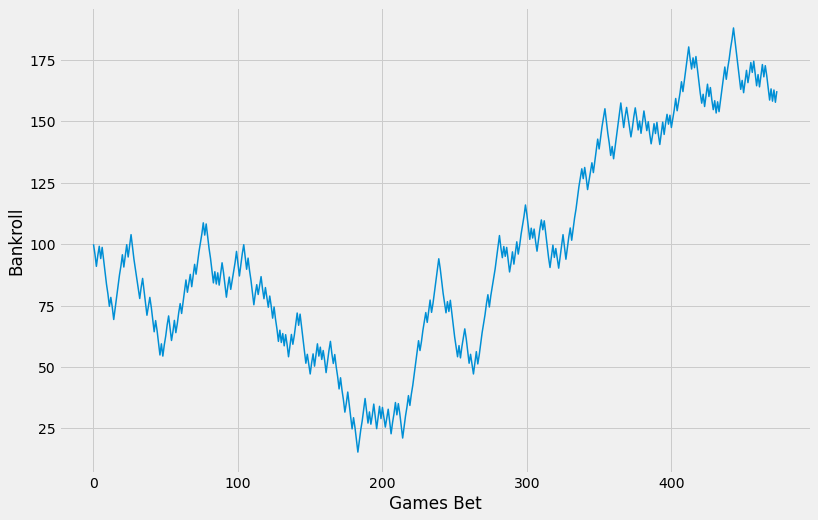

min balance: 15.36363636363648 
max balance: 188.09090909090864 
final balance: 157.36363636363575 
win percentage 53.800000000000004 
profit: 57.36363636363626 risk: 2203.0 
ROI: 2.6
1
test set 1: 2017-10-28 - 2018-06-08


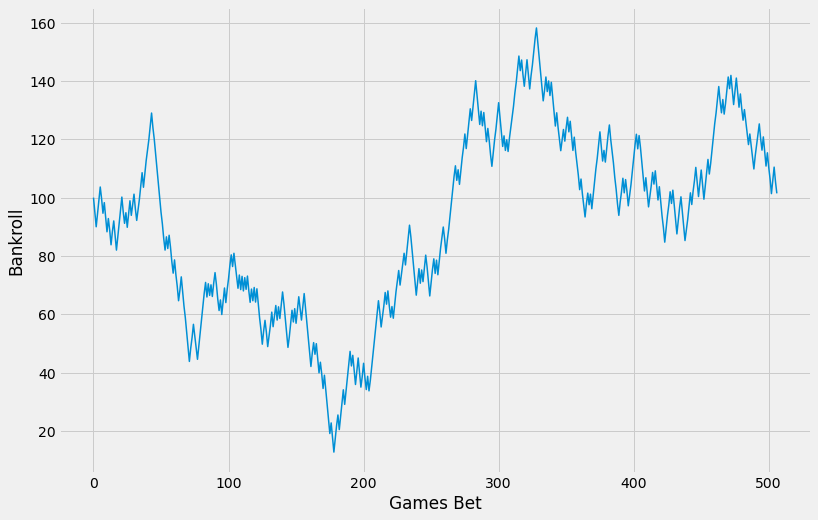

min balance: 12.727272727272808 
max balance: 158.18181818181813 
final balance: 97.45454545454537 
win percentage 52.27 
profit: -2.5454545454547315 risk: 2366.0 
ROI: -0.11
2
test set 1: 2018-10-26 - 2019-06-13


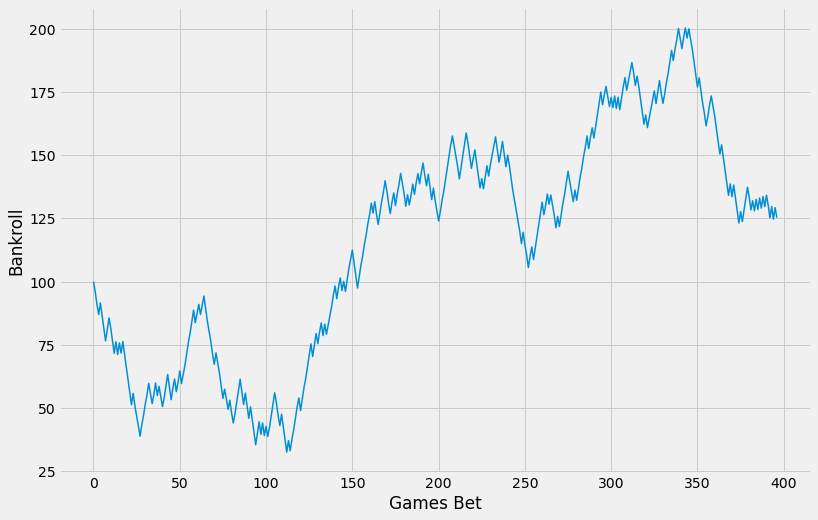

min balance: 32.545454545454554 
max balance: 200.3636363636354 
final balance: 128.90909090908974 
win percentage 52.900000000000006 
profit: 28.909090909090878 risk: 1821.0 
ROI: 1.59
3
test set 1: 2019-11-01 - 2020-10-11


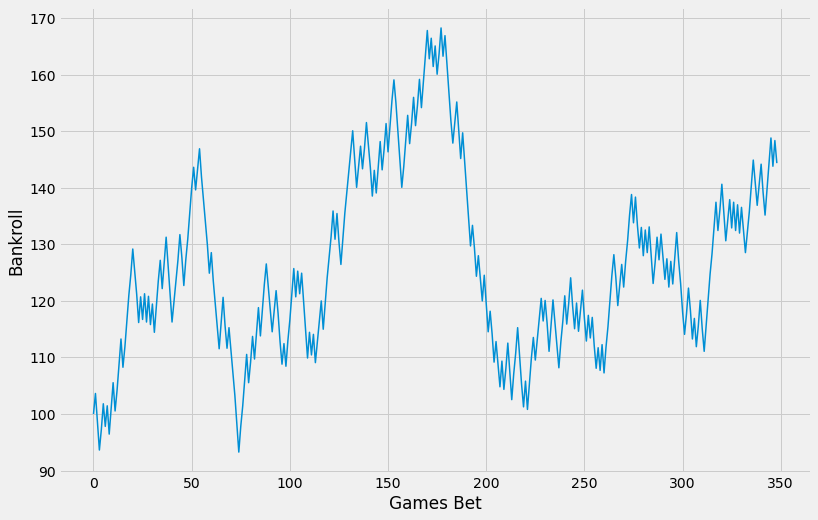

min balance: 93.27272727272727 
max balance: 168.27272727272694 
final balance: 147.9999999999994 
win percentage 54.15 
profit: 47.999999999999886 risk: 1590.0 
ROI: 3.02
4
test set 1: 2021-01-01 - 2021-07-20


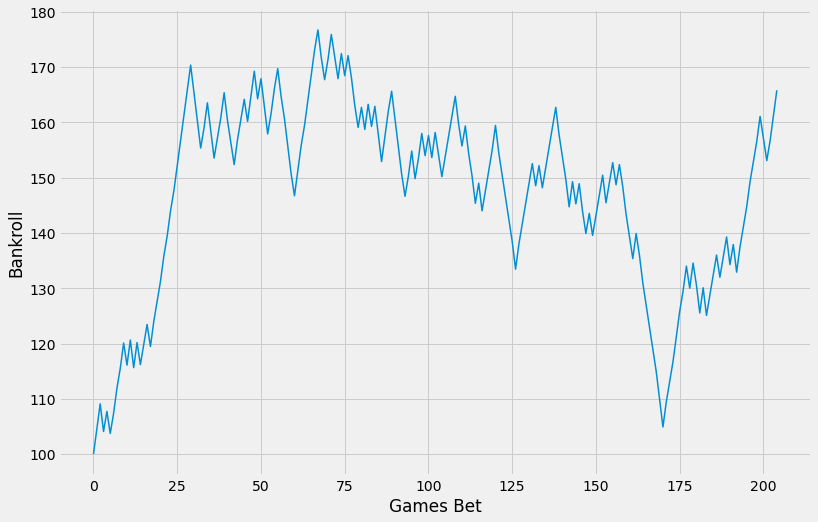

min balance: 103.72727272727273 
max balance: 176.7272727272724 
final balance: 170.36363636363532 
win percentage 56.589999999999996 
profit: 70.36363636363632 risk: 909.0 
ROI: 7.739999999999999

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.0011798799724438123,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                       

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537975            474  0.026039   
1  (2017, -, 2018)            0.53  0.522682            507 -0.001076   
2  (2018, -, 2019)            0.53  0.528967            397  0.015875   
3  (2019, -, 2020)            0.53  0.541547            349  0.030189   
4  (2021, -, 2021)            0.53  0.565854            205  0.077408   

     profits  
0  57.363636  
1  -2.545455  
2  28.909091  
3  48.000000  
4  70.363636

In [113]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [660]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


0
test set 1: 2016-11-04 - 2017-06-12


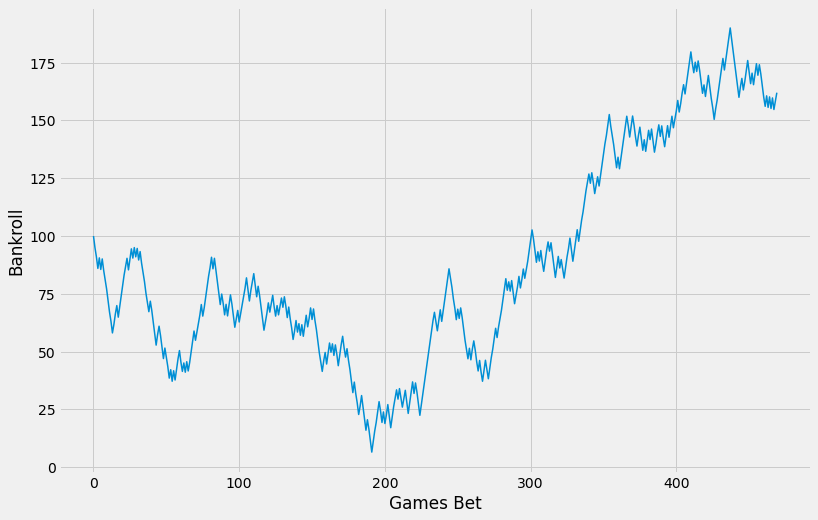

min balance: 6.545454545454625 
max balance: 189.99999999999957 
final balance: 165.63636363636303 
win percentage 53.620000000000005 
profit: 65.63636363636351 risk: 2189.0 
ROI: 3.0
1
test set 1: 2017-10-28 - 2018-06-08


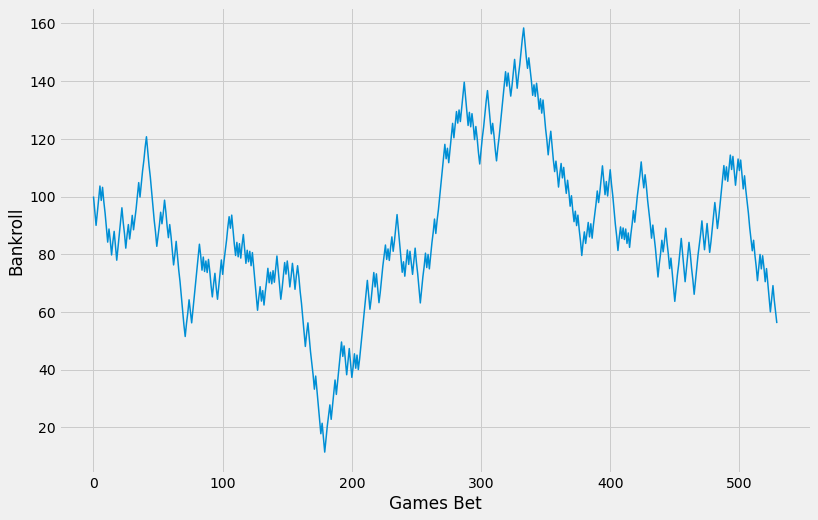

min balance: 11.36363636363652 
max balance: 158.45454545454544 
final balance: 52.09090909090921 
win percentage 51.32 
profit: -47.90909090909099 risk: 2482.0 
ROI: -1.9300000000000002
2
test set 1: 2018-10-26 - 2019-06-13


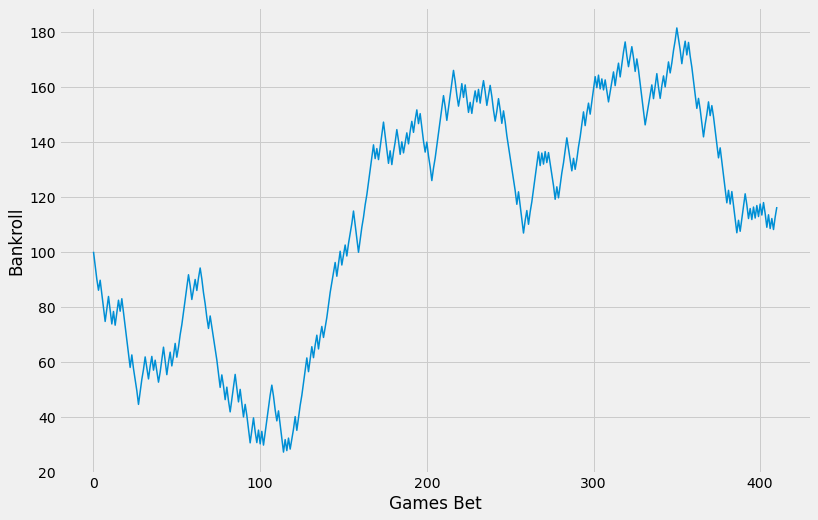

min balance: 27.090909090909136 
max balance: 181.4545454545445 
final balance: 119.90909090908988 
win percentage 52.55 
profit: 19.909090909090878 risk: 1893.0 
ROI: 1.05
3
test set 1: 2019-11-01 - 2020-10-11


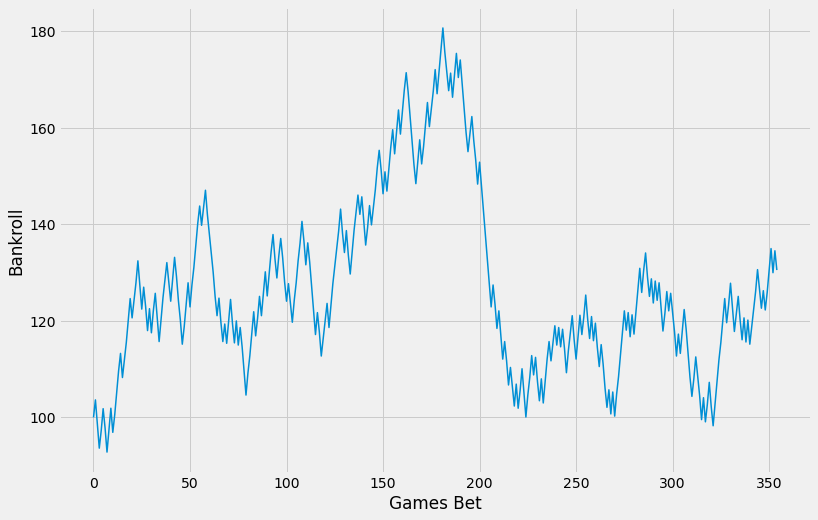

min balance: 92.81818181818183 
max balance: 180.7272727272722 
final balance: 134.18181818181765 
win percentage 53.52 
profit: 34.18181818181813 risk: 1621.0 
ROI: 2.11
4
test set 1: 2021-01-01 - 2021-07-20


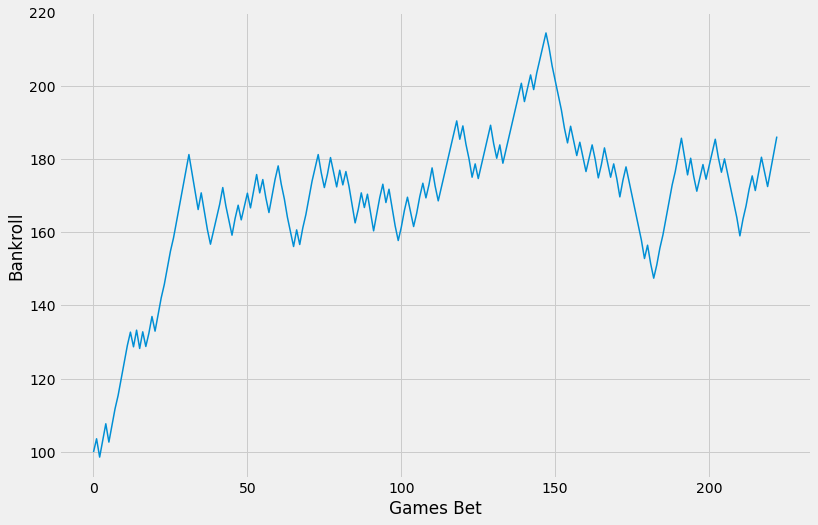

min balance: 98.63636363636364 
max balance: 214.36363636363544 
final balance: 190.6363636363623 
win percentage 56.95 
profit: 90.63636363636363 risk: 988.0 
ROI: 9.17

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SG

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.029985   
1  (2017, -, 2018)            0.53  0.513208            530 -0.019303   
2  (2018, -, 2019)            0.53  0.525547            411  0.010517   
3  (2019, -, 2020)            0.53  0.535211            355  0.021087   
4  (2021, -, 2021)            0.53  0.569507            223  0.091737   

     profits  
0  65.636364  
1 -47.909091  
2  19.909091  
3  34.181818  
4  90.636364

In [663]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


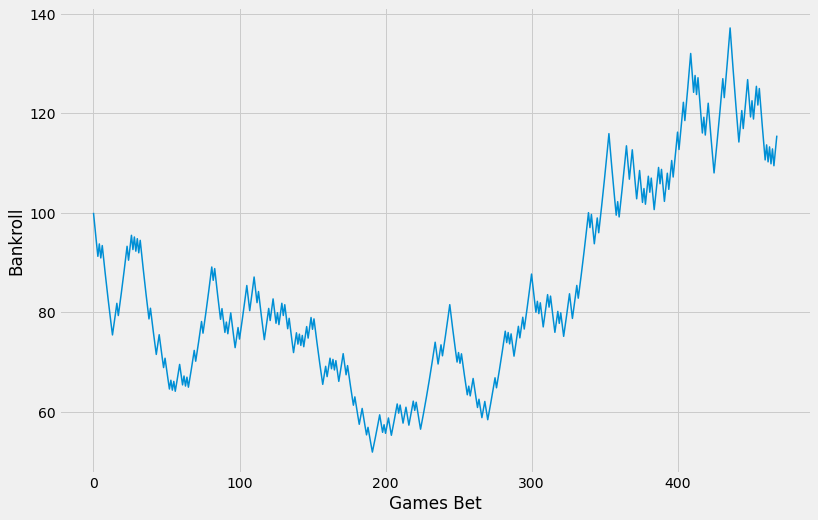

min balance: 51.95931418569775 
max balance: 137.1196961017868 
final balance: 118.65264767409444 
win percentage 53.73 
profit: 18.652647674094396 risk: 1192.5157733411133 
ROI: 1.5599999999999998
1
test set 1: 2017-10-28 - 2018-06-08


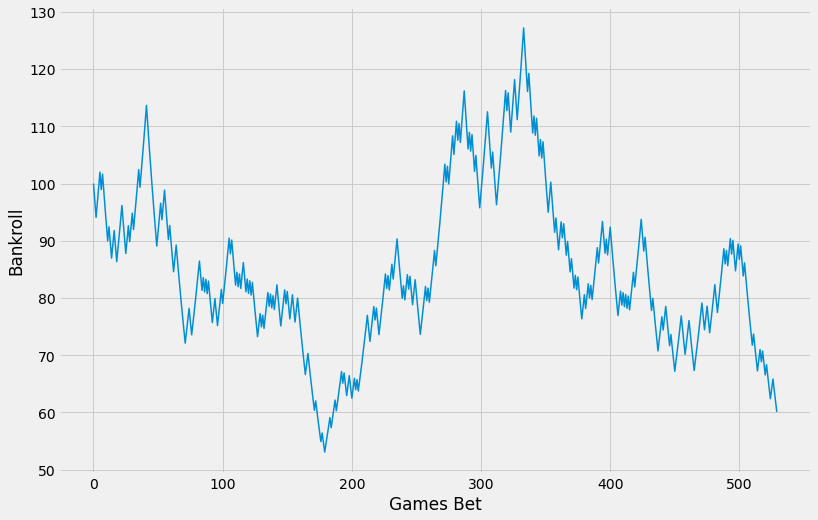

min balance: 53.078477196476335 
max balance: 127.18206300089665 
final balance: 58.29532195061766 
win percentage 51.32 
profit: -41.70467804938244 risk: 1350.6986843431337 
ROI: -3.09
2
test set 1: 2018-10-26 - 2019-06-13


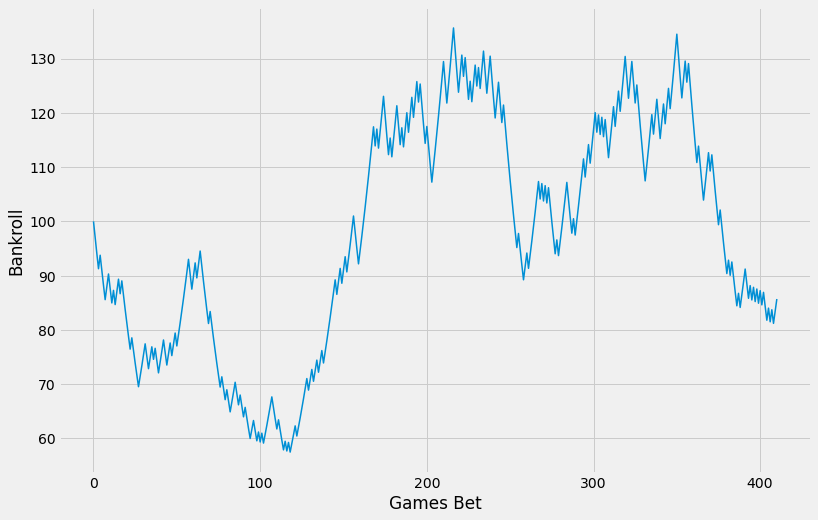

min balance: 57.47882989311353 
max balance: 135.63678545005874 
final balance: 88.02620525821162 
win percentage 52.55 
profit: -11.973794741788538 risk: 1205.5090846965707 
ROI: -0.9900000000000001
3
test set 1: 2019-11-01 - 2020-10-11


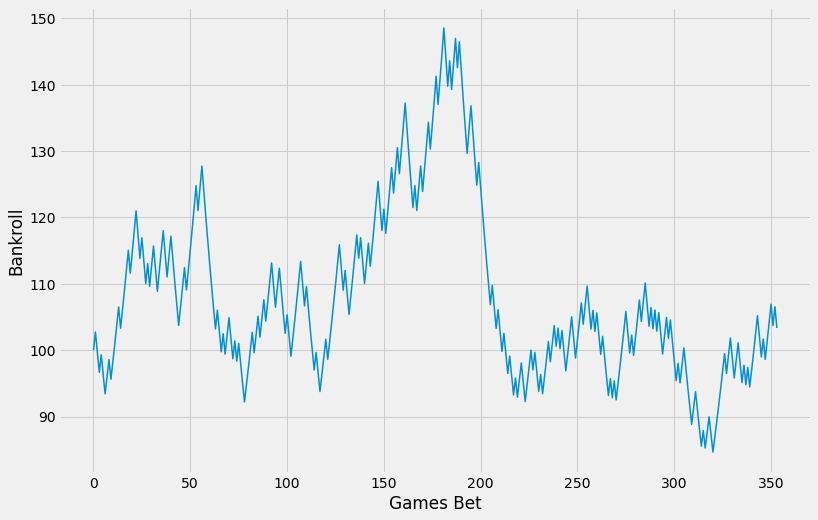

min balance: 84.64415680167593 
max balance: 148.53485625163472 
final balance: 106.15598328445795 
win percentage 53.39 
profit: 6.155983284457989 risk: 1146.171180097704 
ROI: 0.54
4
test set 1: 2021-01-01 - 2021-07-20


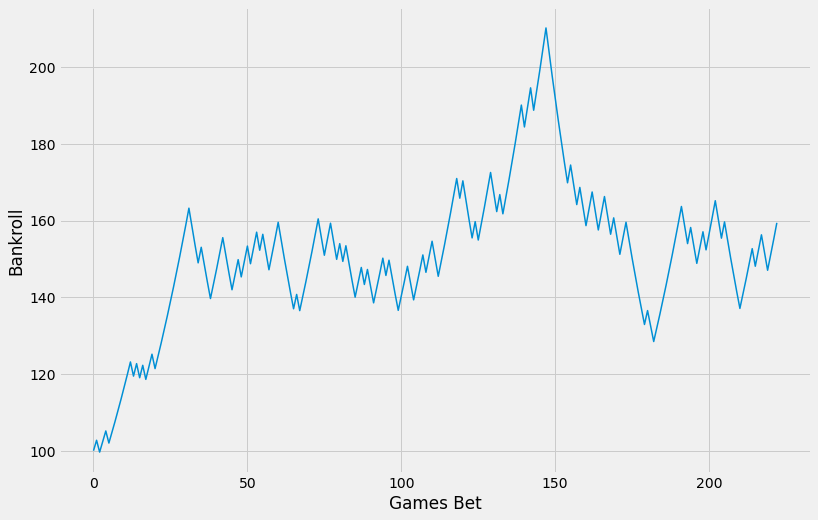

min balance: 99.64545454545456 
max balance: 210.19439280369414 
final balance: 163.74867588537154 
win percentage 56.95 
profit: 63.748675885371426 risk: 1011.0410842746564 
ROI: 6.3100000000000005

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                      

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537313            469  0.015641   
1  (2017, -, 2018)            0.53  0.513208            530 -0.030876   
2  (2018, -, 2019)            0.53  0.525547            411 -0.009933   
3  (2019, -, 2020)            0.53  0.533898            354  0.005371   
4  (2021, -, 2021)            0.53  0.569507            223  0.063053   

     profits  
0  18.652648  
1 -41.704678  
2 -11.973795  
3   6.155983  
4  63.748676

In [664]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_2(select_bets, unit_pct=0.03)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


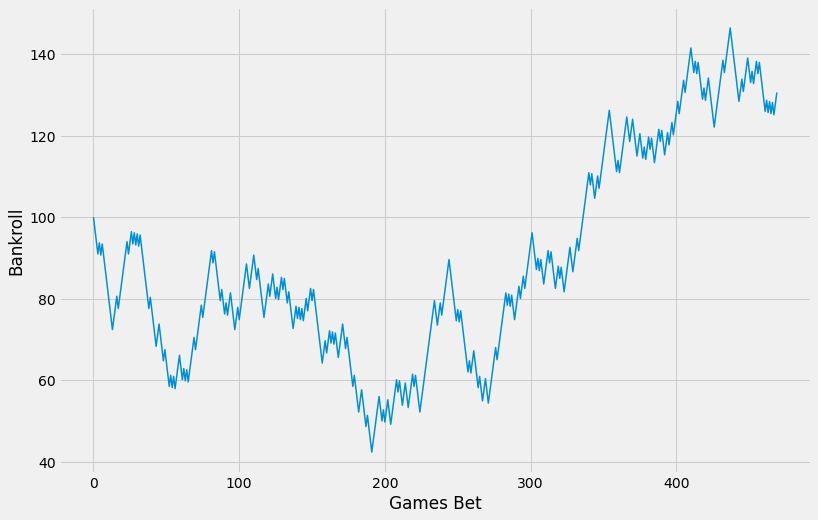

min balance: 42.45454545454595 
max balance: 146.3636363636373 
final balance: 133.27272727272813 
win percentage 53.620000000000005 
profit: 33.27272727272725 risk: 1410.0 
ROI: 2.36
1
test set 1: 2017-10-28 - 2018-06-08


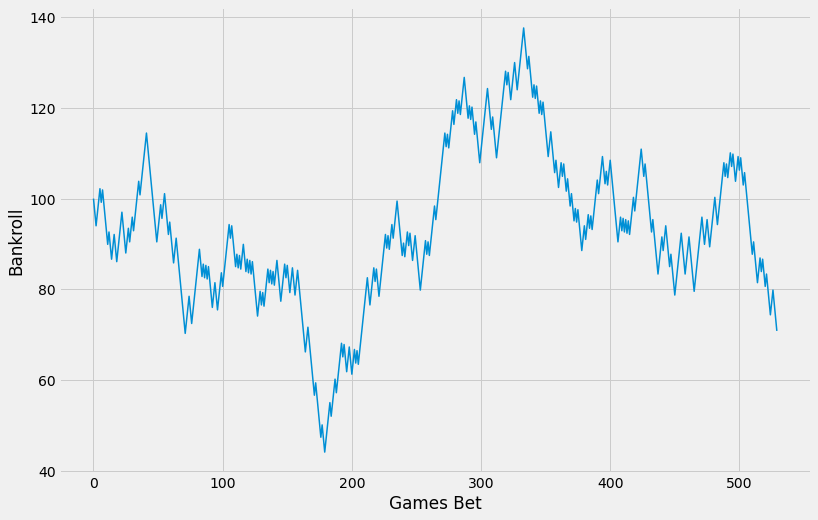

min balance: 44.09090909090962 
max balance: 137.63636363636468 
final balance: 67.81818181818343 
win percentage 51.32 
profit: -32.181818181818244 risk: 1590.0 
ROI: -2.02
2
test set 1: 2018-10-26 - 2019-06-13


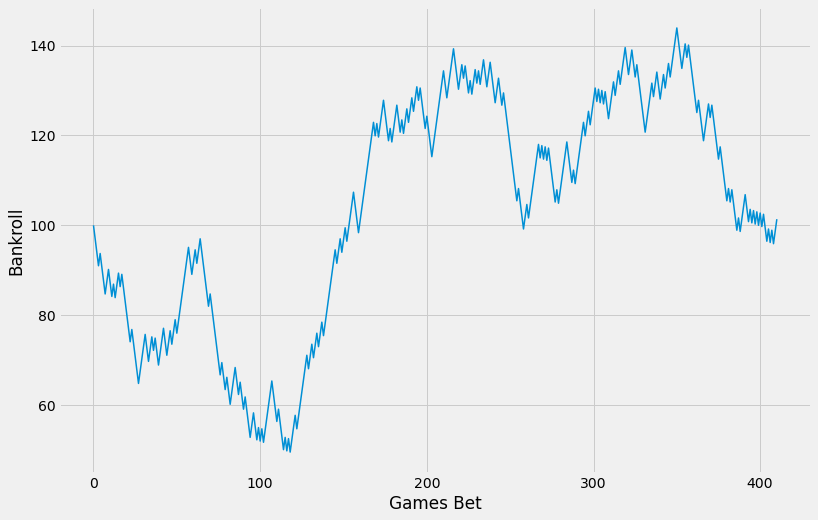

min balance: 49.54545454545478 
max balance: 143.9090909090913 
final balance: 104.0909090909096 
win percentage 52.55 
profit: 4.090909090909008 risk: 1233.0 
ROI: 0.33
3
test set 1: 2019-11-01 - 2020-10-11


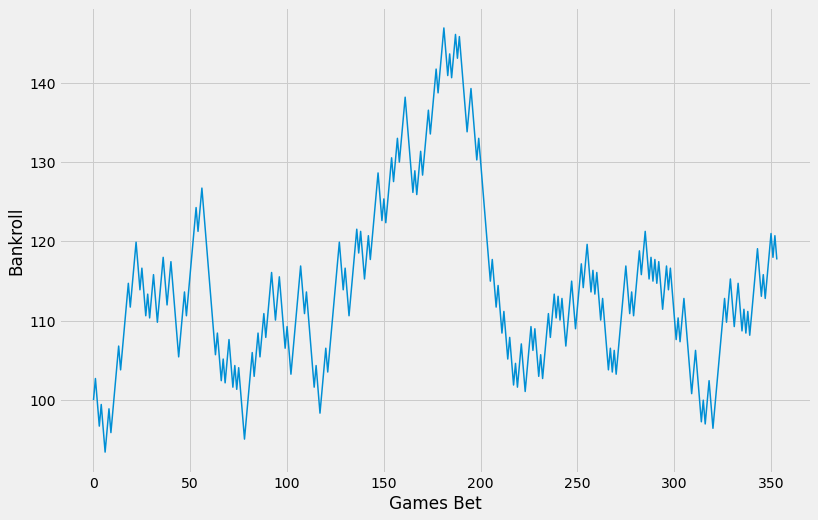

min balance: 93.45454545454547 
max balance: 146.90909090909133 
final balance: 120.45454545454633 
win percentage 53.39 
profit: 20.454545454545382 risk: 1062.0 
ROI: 1.9300000000000002
4
test set 1: 2021-01-01 - 2021-07-20


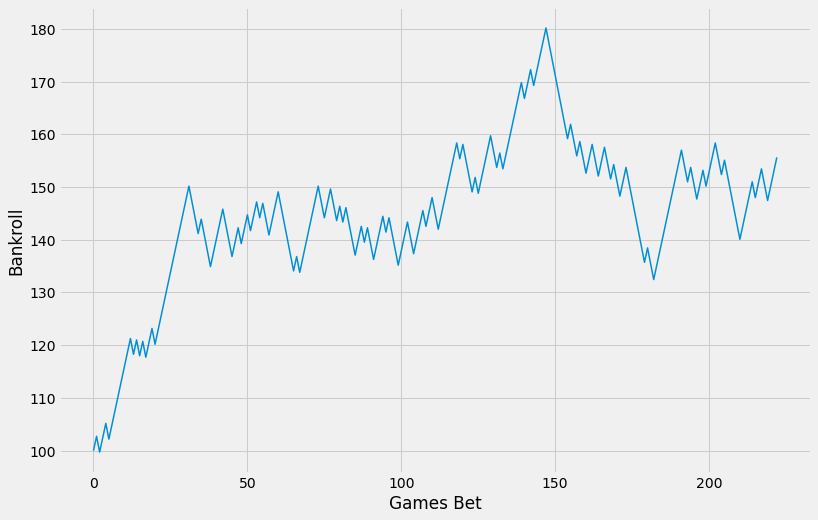

min balance: 99.72727272727273 
max balance: 180.1818181818177 
final balance: 158.3636363636356 
win percentage 56.95 
profit: 58.36363636363632 risk: 669.0 
ROI: 8.72

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SGD

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.023598   
1  (2017, -, 2018)            0.53  0.513208            530 -0.020240   
2  (2018, -, 2019)            0.53  0.525547            411  0.003318   
3  (2019, -, 2020)            0.53  0.533898            354  0.019260   
4  (2021, -, 2021)            0.53  0.569507            223  0.087240   

     profits  
0  33.272727  
1 -32.181818  
2   4.090909  
3  20.454545  
4  58.363636

In [665]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_1(select_bets, unit_size=3)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


## Make Predictions

ETL Pipeline

### Update Date

In [154]:
from src.data.update_data import update_all_data


# connection = sqlite3.connect('../data/nba.db')
# update_all_data(connection, season=2021)
# connection.close()



updating basic team boxscores
updating advanced team boxscores


progress:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]

num_games_updated: 5


progress: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


updating scoring boxscores


progress:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]

num_games_updated: 5


progress: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


updating moneyline data
moneyline table is up to date
updating spreads data
Updating spreads for 0 days
spreads table is up to date


In [43]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [44]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df



In [59]:
X_train.columns

Index(['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3M_team_diff', 'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff',
       'OREB_team_diff', 'DREB_team_diff', 'REB_team_diff', 'AST_team_diff',
       'STL_team_diff', 'BLK_team_diff', 'TOV_team_diff', 'PF_team_diff',
       'PTS_team_diff', 'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'E_NET_RATING_team_diff', 'POSS_team_diff',
       'PIE_team_diff', 'PTS_2PT_MR_team_diff', 'PTS_FB_team_diff',
       'PTS_OFF_TOV_team_diff', 'PTS_PAINT_team_diff', 'AST_2PM_team_diff',
       'AST_3PM_team_diff', 'UAST_2PM_team_diff', 'UAST_3PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG2A_opp_diff', 'FG3M_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff',
       'FTA_opp_diff', 'OREB_opp_diff', 'DREB_opp_diff', 'REB_opp_diff',
       'AST_opp_diff', 'STL_opp_diff', 'BLK_opp_diff', 'TOV_opp_diff',
       'PF_opp_diff', 'PTS_opp_diff', 'PLUS_MINUS_opp_diff'

In [45]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



# create_matchups(df)
# get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True)


# connection.close()
# betting_data_21

In [46]:
def get_team_and_opp_ewm(df, min_periods=1, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values(
            'GAME_DATE_team')

        avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

        avg_ml = team_df['ML_team'].shift(1).expanding().mean()

        record = team_df['RECORD_team'].shift(1).expanding().mean()

        ATS_rec = team_df['TEAM_COVERED_team'].shift(
            1).expanding().mean()

        ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
            1).expanding().mean()

        records = pd.DataFrame({'WL_PCT': record,
                               'ATS_PCT': ATS_rec,
                                'AVG_SPREAD': avg_spread,
                                'AVG_ML': avg_ml,
                                'AVG_ATS_DIFF': ATS_avg_diff
                                })

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
            1).ewm(alpha=alpha, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df



In [47]:
from datetime import date
date.today()

datetime.date(2021, 11, 5)

In [48]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


In [49]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=prev_season_final_elo.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# final_elo_2020 = pd.read_csv("../data/final_elo_ratings_2020")
# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [50]:
X_train

RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
41189             -0.612905               

In [51]:
def create_matchup_rows_for_model(df, home_team, away_team, home_spread, away_spread,
                                  home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    home_diffs = home_stats.iloc[-1, 14:-6] - away_stats.iloc[-1, 14:-6]
    home_diffs = home_diffs.values.reshape(1, -1)    
#     home_diffs = np.concatenate([home_diffs, home_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)

    away_diffs = away_stats.iloc[-1, 14:-6] - home_stats.iloc[-1, 14:-6]
    away_diffs = away_diffs.values.reshape(1, -1)
#     away_diffs = np.concatenate([away_diffs, away_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)
    
    diffs = np.concatenate([home_diffs, away_diffs], axis=0)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:-6]]
#     new_cols.extend(home_stats.columns[-6:])
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
    
    home_rating_i = home_stats.iloc[-1, -5]
    away_rating_i = away_stats.iloc[-1, -5]
    
    diffs['team_rating_i'] = np.nan
    diffs['opp_rating_i'] = np.nan
    
    diffs.at[0, 'team_rating_i'] = home_rating_i
    diffs.at[0, 'opp_rating_i'] = away_rating_i
    
    diffs.at[1, 'team_rating_i'] = away_rating_i
    diffs.at[1, 'opp_rating_i'] = home_rating_i
    
    diffs.at[0, 'team_elo_pred'] = elo_prediction(home_rating_i+69, away_rating_i)
    diffs.at[1, 'team_elo_pred'] = elo_prediction(away_rating_i, home_rating_i+69)

    diffs['elo_MOV_pred'] = np.nan
    diffs.at[0, 'elo_MOV_pred'] = round((home_rating_i + 69 - away_rating_i)/28, 2)
    diffs.at[1, 'elo_MOV_pred'] = round((away_rating_i - (home_rating_i + 69))/28, 2)

    diffs['SPREAD_team'] = np.nan
    diffs['ML_team'] = np.nan
    
    diffs.at[0, 'SPREAD_team'] = home_spread
    diffs.at[1, 'SPREAD_team'] = away_spread 
    
    diffs.at[0, 'ML_team'] = home_ml
    diffs.at[1, 'ML_team'] = away_ml
    
    diffs = diffs[X_train.columns].astype(float)
    
    return diffs


In [52]:
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spreads_df(todays_spreads)

todays_mls = get_days_moneylines(todays_date)
todays_mls = clean_moneyline_df(todays_mls)

todays_lines = pd.concat([todays_spreads, todays_mls.iloc[:, -2:]], axis=1)
todays_lines

GM_DATE AWAY_TEAM HOME_TEAM                 AWAY_SPREAD  \
0  2021-11-05       SAS       ORL   -3½-110,-,-3½-112,-3½-118   
1  2021-11-05       BKN       DET  -10-110,-,-10-110,-10½-105   
2  2021-11-05       MEM       WAS      +2-110,-,+1-112,+2-110   
3  2021-11-05       NYK       MIL      +4-110,-,+5-110,+6-165   
4  2021-11-05       CLE       TOR    +5½-110,-,+6-110,+7½-175   
5  2021-11-05       LAC       MIN     -2½-110,-,-3-112,-3-105   
6  2021-11-05       NOP       GSW   +9½-110,-,+9-110,+10½-130   
7  2021-11-05       CHA       SAC     +2-110,-,+1½-110,+2-110   
8  2021-11-05       IND       POR     +5-110,-,+3½-109,+5-110   

   HIGHEST_HOME_SPREAD  HIGHEST_AWAY_SPREAD  HIGHEST_HOME_ML  HIGHEST_AWAY_ML  
0                  3.5                 -3.5         2.400000         1.625000  
1                 10.5                -10.5         4.900000         1.188679  
2                 -2.0                  2.0         1.740741         2.150000  
3                 -6.0                  6.0         1.512821         2.600000  
4                 -7.5                  7.5         1.425532         2.880000  
5                  3.0                 -3.0         2.200000         1.675676  
6                 -9.5                 10.5         1.216920         4.500000  
7                 -2.0                  2.0         1.769231         2.100000  
8                 -5.0                  5.0         1.465116         2.750000

In [53]:
from src.models.model_preparation import get_draftking_lines, clean_draftking_lines

todays_date = datetime.today().strftime('%Y-%m-%d')


todays_lines = get_draftking_lines(todays_date)

todays_lines = clean_draftking_lines(todays_lines)

todays_lines

game_date away_team home_team  away_spread  home_spread  away_moneyline  \
0  2021-11-05       SAS       ORL         -3.5          3.5        1.625000   
1  2021-11-05       MEM       WAS          2.0         -2.0        2.100000   
2  2021-11-05       BKN       DET         -9.5          9.5        1.210526   
3  2021-11-05       CLE       TOR          5.5         -5.5        2.750000   
4  2021-11-05       NYK       MIL          3.5         -3.5        2.450000   
5  2021-11-05       LAC       MIN         -2.5          2.5        1.714286   
6  2021-11-05       CHA       SAC          2.0         -2.0        2.100000   
7  2021-11-05       IND       POR          5.0         -5.0        2.750000   
8  2021-11-05       NOP       GSW          9.0         -9.0        4.100000   

   home_moneyline  
0        2.400000  
1        1.769231  
2        4.500000  
3        1.476190  
4        1.606061  
5        2.200000  
6        1.769231  
7        1.476190  
8        1.243902

### Make Predictions

In [54]:
clean_data = pd.read_csv("../data/clean/processed_data.csv")

clean_data



ML_team  SPREAD_team  TEAM_COVERED_team  RECORD_team_diff  \
0      3.000000          6.0                  1         -0.473684   
1      1.416667         -6.0                  0          0.473684   
2      3.800000          8.0                  0          0.000000   
3      1.277778         -8.0                  1          0.000000   
4      1.666667         -3.5                  0          0.526316   
...         ...          ...                ...               ...   
33533  1.588235         -4.0                  1         -0.340506   
33534  2.400000          5.5                  0         -0.264612   
33535  1.606061         -5.5                  1          0.264612   
33536  3.800000         10.0                  0          0.244194   
33537  1.277778        -10.0                  1         -0.244194   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0           -3.473684       10.105263       -3.473684       -1.684211   
1            3.473684      -10.105263        3.473684        1.684211   
2           -0.157895       10.368421        2.210526        4.736842   
3            0.157895      -10.368421       -2.210526       -4.736842   
4            5.105263       11.052632       -2.210526       -7.842105   
...               ...             ...             ...             ...   
33533        5.807211        3.052050       -3.441117       -9.926141   
33534       -0.071242        3.548124       -1.634778        1.493167   
33535        0.071242       -3.548124        1.634778       -1.493167   
33536       -3.850138       -6.258651       -5.715880       -9.002564   
33537        3.850138        6.258651        5.715880        9.002564   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0          -0.263158      -2.789474       10.052632        3.526316   
1           0.263158       2.789474      -10.052632       -3.526316   
2           0.526316       4.157895        6.315789       -1.578947   
3          -0.526316      -4.157895       -6.315789        1.578947   
4           0.000000       0.263158       -1.368421        0.947368   
...              ...            ...             ...             ...   
33533      -2.495784      -3.406804       -3.973830       -2.686828   
33534      -4.267520      -5.184356       -0.485315       -7.112823   
33535       4.267520       5.184356        0.485315        7.112823   
33536       1.781983       0.181412        0.549974       -0.625162   
33537      -1.781983      -0.181412       -0.549974        0.625162   

       REB_team_diff  AST_team_diff  STL_team_diff  BLK_team_diff  \
0          13.578947      -8.473684       1.578947      -0.368421   
1         -13.578947       8.473684      -1.578947       0.368421   
2           4.736842      -5.526316       3.000000      -1.000000   
3          -4.736842       5.526316      -3.000000       1.000000   
4          -0.421053       2.842105       2.052632      -0.578947   
...              ...            ...            ...            ...   
33533      -6.660657       1.622855       3.081710      -3.576040   
33534      -7.598139       4.437627       3.810992      -1.511195   
33535       7.598139      -4.437627      -3.810992       1.511195   
33536      -0.075187      -2.897927      -1.241264      -2.237284   
33537       0.075187       2.897927       1.241264       2.237284   

       TOV_team_diff  PF_team_diff  PTS_team_diff  PLUS_MINUS_team_diff  \
0           2.526316     -5.263158     -17.631579            -21.000000   
1          -2.526316      5.263158      17.631579             21.000000   
2           0.421053      7.421053       6.842105              3.315789   
3          -0.421053     -7.421053      -6.842105             -3.315789   
4           0.263158     -1.315789       3.578947             10.789474   
...              ...           ...            ...                   ...   
33533       5.506252      0.715615      -1.204711             -3.116604   
33534      -5.145100

In [55]:

def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_lines = get_draftking_lines(todays_date)
    todays_lines = clean_draftking_lines(todays_lines)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []
    away_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_spread = row['home_spread'] 
        away_spread = row['away_spread']
        home_ml = row['home_moneyline']
        away_ml = row['away_moneyline']
        game_date = row['game_date']
        matchup = create_matchup_rows_for_model(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        away_cover_probs.append(probs[1, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs,
                                      'away_cover_probs':away_cover_probs})

    todays_predictions['home_cover_avg'] = (todays_predictions['home_cover_probs'] 
                                            + (1-todays_predictions['away_cover_probs']))/2
    return todays_predictions

In [99]:
# X_full = pd.concat([X_train, X_test])
# y_full = pd.concat([y_train, y_test])

# X_full.shape, y_full.shape

# estimators = [('log', best_lr), ('sgd', best_sgd),
#               ('svc', best_svc), ('lgbc', best_lgbc),
#              ('rf', best_rf), ('knn', best_knn)]


# final_stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
#                                  n_jobs=-1, verbose=1)


# final_stacked_clf.fit(X_full, y_full)


# filename = '../models/finalized_stacked_model'

# joblib.dump(final_stacked_clf, filename)

NameError: name 'final_stacked_clf' is not defined

In [56]:
final_stacked_model = joblib.load('../models/finalized_stacked_model')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")

In [57]:
def main(conn, season, model, prev_season_elo, append = True):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    if append == True:
        todays_predictions.to_csv("../results/predictions_2021.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [58]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")
todays_predictions = main(connection, 2021, final_stacked_model, prev_season_elo, append=True)

connection.close()

todays_predictions

progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.30s/it]
progress:: 246it [00:00, 5234.18it/s]


game_date home_team away_team  home_spread  home_cover_probs  \
0  2021-11-05       ORL       SAS          3.5          0.488947   
1  2021-11-05       WAS       MEM         -2.0          0.469567   
2  2021-11-05       DET       BKN          9.5          0.584176   
3  2021-11-05       TOR       CLE         -5.5          0.545707   
4  2021-11-05       MIL       NYK         -3.5          0.539298   
5  2021-11-05       MIN       LAC          2.5          0.483033   
6  2021-11-05       SAC       CHA         -2.0          0.488880   
7  2021-11-05       POR       IND         -5.0          0.490277   
8  2021-11-05       GSW       NOP         -9.0          0.463747   

   away_cover_probs  home_cover_avg  
0          0.511076        0.488935  
1          0.529852        0.469857  
2          0.415521        0.584328  
3          0.453990        0.545859  
4          0.458778        0.540260  
5          0.516645        0.483194  
6          0.510569        0.489155  
7          0.509095        0.490591  
8          0.536113        0.463817

In [194]:
season = 2021
home_team = 'WAS'
away_team = 'TOR'
home_spread = -3.5
away_spread = -home_spread
home_ml = 1.63
away_ml = 2.4

conn = sqlite3.connect('../data/nba.db')

# update_all_data(conn, season=season)

df = load_current_season_team_data(conn, season)

df = clean_team_data(df)

df = prep_for_aggregation(df)

spreads, moneylines = load_current_season_betting_data(conn, 2021)
clean_moneylines = clean_moneyline_df(df=moneylines)
clean_spreads = clean_spreads_df(df=spreads)


full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
full_df = create_matchups(full_df)
full_df = get_team_and_opp_ewm(full_df)

full_df = add_percentage_features(full_df)
full_df = add_rest_days_for_model(full_df)

current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)

matchup = create_matchup_rows_for_model(full_df, home_team, away_team,
                                        home_spread, away_spread, home_ml, away_ml)

conn.close()

# print(matchup)

# full_df
matchup



progress:: 214it [00:00, 4196.26it/s]


RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0          0.211779        1.062682        1.309506        0.138052   
1         -0.211779       -1.062682       -1.309506       -0.138052   

   FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0        1.089786       6.346542       6.428222       -3.419356   
1       -1.089786      -6.346542      -6.428222        3.419356   

   DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  BLK_team_diff  \
0        7.077812       3.658456       0.732907      -3.995283        2.52715   
1       -7.077812      -3.658456      -0.732907       3.995283       -2.52715   

   TOV_team_diff  PF_team_diff  PTS_team_diff  PLUS_MINUS_team_diff  \
0      -1.261892      0.466413       8.886063             -0.049723   
1       1.261892     -0.466413      -8.886063              0.049723   

   E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  E_NET_RATING_team_diff  \
0                1.188743                0.984287                0.181607   
1               -1.188743               -0.984287               -0.181607   

   POSS_team_diff  PIE_team_diff  PTS_2PT_MR_team_diff  PTS_FB_team_diff  \
0        8.951091       0.018177             -2.811783         -7.499169   
1       -8.951091      -0.018177              2.811783          7.499169   

   PTS_OFF_TOV_team_diff  PTS_PAINT_team_diff  AST_2PM_team_diff  \
0                -6.2188              5.45391           2.039382   
1                 6.2188             -5.45391          -2.039382   

   AST_3PM_team_diff  UAST_2PM_team_diff  UAST_3PM_team_diff  \
0          -1.101309            -0.94986            1.325884   
1           1.101309             0.94986           -1.325884   

   ATS_DIFF_team_diff  RECORD_opp_diff  FG2M_opp_diff  FG2A_opp_diff  \
0            2.297855        -0.211779       9.242479      16.945801   
1           -2.297855         0.211779      -9.242479     -16.945801   

   FG3M_opp_diff  FG3A_opp_diff  FTM_opp_diff  FTA_opp_diff  OREB_opp_diff  \
0      -4.150095      -5.176845      2.901114      3.384959       -0.12719   
1       4.150095       5.176845     -2.901114     -3.384959        0.12719   

   DREB_opp_diff  REB_opp_diff  AST_opp_diff  STL_opp_diff  BLK_opp_diff  \
0       5.292726      5.165536      -0.16418     -0.109045     -1.671744   
1      -5.292726     -5.165536       0.16418      0.109045      1.671744   

   TOV_opp_diff  PF_opp_diff  PTS_opp_diff  PLUS_MINUS_opp_diff  \
0     -5.576033     2.982544      8.935786             0.049723   
1      5.576033    -2.982544     -8.935786            -0.049723   

   E_OFF_RATING_opp_diff  E_DEF_RATING_opp_diff  E_NET_RATING_opp_diff  \
0               0.984287               1.188743              -0.181607   
1              -0.984287              -1.188743               0.181607   

   POSS_opp_diff  PIE_opp_diff  PTS_2PT_MR_opp_diff  PTS_FB_opp_diff  \
0       8.744063     -0.018177             0.638093        -0.066234   
1      -8.744063      0.018177            -0.638093         0.066234   

   PTS_OFF_TOV_opp_diff  PTS_PAINT_opp_diff  AST_2PM_opp_diff  \
0             -1.796198           17.727849          3.083999   
1              1.796198          -17.727849         -3.083999   

   AST_3PM_opp_diff  UAST_2PM_opp_diff  UAST_3PM_opp_diff  ATS_DIFF_opp_diff  \
0         -3.241633           6.229211          -0.743883          -2.297855   
1          3.241633          -6.229211           0.743883           2.297855   

   TEAM_COVERED_opp_diff  WL_PCT_diff  ATS_PCT_diff  AVG_SPREAD_diff  \
0              -0.104531     0.261905      0.095238         2.202381   
1               0.104531    -0.261905     -0.095238        -2.202381   

   AVG_ML_diff  AVG_ATS_DIFF_diff  REST_diff  OREB_PCT_team_diff  \
0      0.26595           2.369048        0.0           -0.081694   
1     -0.26595          -2.369048        0.0            0.081694   

   OREB_PCT_opp_diff  DREB_PCT_team_diff  DREB_PCT_opp_diff  \
0          -0.032495     

In [171]:
final_stacked_model.predict_proba(matchup)

array([[0.44918038, 0.55081962],
       [0.54953585, 0.45046415]])

In [195]:
df.loc[df['TEAM_ABBREVIATION'] == 'TOR']

SEASON     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
53685  2021-22  1610612761               TOR  Toronto Raptors  0022100006   
53714  2021-22  1610612761               TOR  Toronto Raptors  0022100020   
53733  2021-22  1610612761               TOR  Toronto Raptors  0022100029   
53773  2021-22  1610612761               TOR  Toronto Raptors  0022100046   
53790  2021-22  1610612761               TOR  Toronto Raptors  0022100058   
53816  2021-22  1610612761               TOR  Toronto Raptors  0022100071   
53840  2021-22  1610612761               TOR  Toronto Raptors  0022100081   
53878  2021-22  1610612761               TOR  Toronto Raptors  0022100099   

       GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  WL  RECORD  \
53685 2021-10-20  TOR vs. WAS          1          83         -15   0       0   
53714 2021-10-22    TOR @ BOS          0         115          32   1       1   
53733 2021-10-23  TOR vs. DAL          1          95          -8   0       0   
53773 2021-10-25  TOR vs. CHI          1         108          -3   0       0   
53790 2021-10-27  TOR vs. IND          1         118          18   1       1   
53816 2021-10-29  TOR vs. ORL          1         110           1   1       1   
53840 2021-10-30    TOR @ IND          0          97           3   1       1   
53878 2021-11-01    TOR @ NYK          0         113           9   1       1   

       FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  STL  BLK  TOV  \
53685    23    63     7    34   16   22    19    35   54   14   10    4   19   
53714    32    65    10    35   21   21    21    39   60   22   16    2   12   
53733    23    48    11    37   16   23    11    38   49   17    7    6   12   
53773    28    53    12    30   16   20    13    34   47   27    8    1   21   
53790    32    70    14    30   12   19    16    25   41   22   18    6   12   
53816    34    56     9    30   15   22     9    31   40   18   11    2    8   
53840    28    60    11    32    8   12    12    36   48   18    8    4   18   
53878    29    57    14    42   13   14    13    35   48   24   12    4    9   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
53685  21   83         -15          77.8        77.6          91.2   
53714  13  115          32         114.7       113.9          81.5   
53733  23   95          -8          98.8       102.2         108.5   
53773  18  108          -3         109.3       110.2         113.6   
53790  20  118          18         113.1       121.6          99.5   
53816  18  110           1         116.2       118.3         110.1   
53840  17   97           3          93.9        98.0          94.0   
53878  20  113           9         111.7       115.3         107.7   

       DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  PTS_2PT_MR  PTS_FB  \
53685        92.5         -13.4       -14.9  107.0  0.300           5      18   
53714        82.2          33.2        31.7  101.0  0.693           5      21   
53733       110.8          -9.7        -8.6   93.0  0.445           9      11   
53773       115.6          -4.3        -5.4   98.0  0.489           7      18   
53790       103.1          13.5        18.6   97.0  0.564           6      10   
53816       116.0           6.1         2.3   93.0  0.541          30      12   
53840        94.9           0.0         3.0   99.0  0.484           9      12   
53878       107.2           4.0         8.1   98.0  0.543          16      21   

       PTS_OFF_TOV  PTS_PAINT  AST_2PM  AST_3PM  UAST_2PM  UAST_3PM HOME_TEAM  \
53685           17         40        8        5        14         1       TOR   
53714           27         57       14        8        18         2       BOS   
53733            3         36        8        8        14         2       TOR   
53773           11         47       15       12        12         0       TOR   
53790           31         58       12        9        19         4       TOR   
53816           22       

In [196]:
df.loc[df['TEAM_ABBREVIATION'] == 'WAS']

SEASON     TEAM_ID TEAM_ABBREVIATION           TEAM_NAME     GAME_ID  \
53684  2021-22  1610612764               WAS  Washington Wizards  0022100006   
53712  2021-22  1610612764               WAS  Washington Wizards  0022100019   
53758  2021-22  1610612764               WAS  Washington Wizards  0022100044   
53795  2021-22  1610612764               WAS  Washington Wizards  0022100056   
53804  2021-22  1610612764               WAS  Washington Wizards  0022100066   
53833  2021-22  1610612764               WAS  Washington Wizards  0022100078   
53870  2021-22  1610612764               WAS  Washington Wizards  0022100097   

       GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  WL  RECORD  \
53684 2021-10-20    WAS @ TOR          0          98          15   1       1   
53712 2021-10-22  WAS vs. IND          1         135           1   1       1   
53758 2021-10-25    WAS @ BKN          0          90         -14   0       0   
53795 2021-10-27    WAS @ BOS          0         116           9   1       1   
53804 2021-10-28  WAS vs. ATL          1         122          11   1       1   
53833 2021-10-30  WAS vs. BOS          1         115           3   1       1   
53870 2021-11-01    WAS @ ATL          0         111          -7   0       0   

       FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  STL  BLK  TOV  \
53684    31    54     5    27   21   26     7    44   51   20   14    8   22   
53712    30    56    19    38   18   19     6    32   38   24    5    6    9   
53758    24    56     9    39   15   20    10    43   53   16    5    5   12   
53795    34    59     9    25   21   29    11    36   47   18    8    7   16   
53804    33    65    13    34   17   21    14    37   51   26    6    4    9   
53833    28    68    10    36   29   36    12    50   62   19    6    7   13   
53870    28    47    13    39   16   16     7    29   36   27    7    4   12   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
53684  17   98          15          91.2        92.5          77.8   
53712  21  135           1         128.1       128.6         120.9   
53758  17   90         -14          85.1        86.5         100.5   
53795  20  116           9         114.0       116.0         106.7   
53804  16  122          11         118.2       120.8         109.7   
53833  22  115           3          95.2        95.0          91.8   
53870  24  111          -7         113.2       116.8         125.9   

       DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  PTS_2PT_MR  PTS_FB  \
53684        77.6          13.4        14.9  106.0  0.700           5       8   
53712       127.6           7.2         1.0  105.0  0.503          12       2   
53758       101.0         -15.4       -14.4  104.0  0.395           8      16   
53795       108.1           7.3         7.9  100.0  0.556           9      11   
53804       109.9           8.4        10.9  101.0  0.521           5       0   
53833        93.3           3.4         1.7  121.0  0.510          10       4   
53870       122.9         -12.6        -6.1   95.0  0.449           7      14   

       PTS_OFF_TOV  PTS_PAINT  AST_2PM  AST_3PM  UAST_2PM  UAST_3PM HOME_TEAM  \
53684           18         55       15        5        15         0       TOR   
53712           26         48       12       12        18         6       WAS   
53758           10         39       10        5        13         3       BKN   
53795           17         58       12        6        21         2       BOS   
53804           10         60       16        9        16         3       WAS   
53833           10         46       12        6        15         4       WAS   
53870           16         47       15       10        12         2       ATL   

      AWAY_TEAM  
53684       WAS  
53712       IND  
53758       WAS  
53795       WAS  
53804       ATL  
53833       BOS  
53870       WAS

In [104]:
full_df.loc[full_df['TEAM_ABBREVIATION_team'] == 'TOR']

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team   TEAM_NAME_team  \
11      2021-22    1610612761                    TOR  Toronto Raptors   
38      2021-22    1610612761                    TOR  Toronto Raptors   
57      2021-22    1610612761                    TOR  Toronto Raptors   
91      2021-22    1610612761                    TOR  Toronto Raptors   
115     2021-22    1610612761                    TOR  Toronto Raptors   
141     2021-22    1610612761                    TOR  Toronto Raptors   
160     2021-22    1610612761                    TOR  Toronto Raptors   

        GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  TEAM_SCORE_team  \
11   0022100006     2021-10-20  TOR vs. WAS               1               83   
38   0022100020     2021-10-22    TOR @ BOS               0               15   
57   0022100029     2021-10-23  TOR vs. DAL               1               95   
91   0022100046     2021-10-25  TOR vs. CHI               1              108   
115  0022100058     2021-10-27  TOR vs. IND               1              118   
141  0022100071     2021-10-29  TOR vs. ORL               1              110   
160  0022100081     2021-10-30    TOR @ IND               0               97   

     POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
11               -15        0  1.699301         -4.5                  0   
38                -5        0  3.200000          6.5                  1   
57                -8        0  2.550000          4.5                  0   
91                -3        0  2.250000          4.0                  1   
115               18        1  2.200000          3.0                  1   
141                1        1  1.216920        -11.5                  0   
160                3        1  2.300000          3.0                  1   

     RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
11           NaN        NaN        NaN        NaN        NaN        NaN   
38      0.000000  23.000000  63.000000   7.000000  34.000000  16.000000   
57      0.000000  12.473684  36.684211   4.894737  20.842105   7.578947   
91      0.000000  16.357934  40.859779   7.147601  26.804428  10.686347   
115     0.000000  19.743239  44.389939   8.558593  27.733644  12.231463   
141     0.244194  22.736270  50.643769   9.887353  28.287075  12.174941   
160     0.405499  25.140179  51.786898   9.697974  28.652648  12.777866   

      FTA_team  OREB_team  DREB_team   REB_team   AST_team   STL_team  \
11         NaN        NaN        NaN        NaN        NaN        NaN   
38   22.000000  19.000000  35.000000  54.000000  14.000000  10.000000   
57   10.421053  11.105263  19.736842  30.842105   8.210526   6.315789   
91   15.062731  11.066421  26.476015  37.542435  11.453875   6.568266   
115  16.498401  11.919453  28.663856  40.583309  15.974411   6.693806   
141  17.109277  12.915899  27.769163  40.685063  17.445825   9.454714   
160  18.153056  12.080167  28.458689  40.538856  17.564098   9.784510   

     BLK_team   TOV_team    PF_team   PTS_team  PLUS_MINUS_team  \
11        NaN        NaN        NaN        NaN              NaN   
38   4.000000  19.000000  21.000000  83.000000       -15.000000   
57   1.894737  10.052632  11.000000  47.210526        -9.736842   
91   3.409594  10.771218  15.428044  64.845018        -9.095941   
115  2.708927  13.745566  16.175923  77.393719        -7.323350   
141  3.512588  13.319308  17.109741  87.309541        -1.139533   
160  3.189771  12.184060  17.299740  92.152145        -0.682913   

     E_OFF_RATING_team  E_DEF_RATING_team  E_NET_RATING_team   POSS_team  \
11                 NaN                NaN                NaN         NaN   
38           77.800000          91.200000         -13.400000  107.000000   
57           97.221053          86.094737          11.126316  103.842105   
91           97.803690          94.362362           3.441328   99.841328   
115         101.146612          99.956325           1.190288   99.305903  